# **MLP**


*Kết nối Drive*

In [27]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Colab Notebooks/PTDLKD/Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/PTDLKD/Project


*Thêm thư viện*

In [28]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from typing import Tuple

### **BITCOIN**

#### *Tiền xử lý*

In [29]:
# Cell: Tiền xử lý dữ liệu
# Đọc file
BTC = pd.read_csv('Bitcoin Historical Data.csv')

# Loại bỏ dấu phẩy và chuyển đổi thành float
for col in ['Price', 'Open']:
    BTC[col] = BTC[col].str.replace(',', '', regex=False).astype(float)

# Xử lý cột 'Vol.' chứa hậu tố 'K', 'M', 'B'
def convert_volume(val):
    val = str(val).replace(',', '').strip()
    if 'K' in val:
        return float(val.replace('K', '')) * 1_000
    elif 'M' in val:
        return float(val.replace('M', '')) * 1_000_000
    elif 'B' in val:
        return float(val.replace('B', '')) * 1_000_000_000
    else:
        return float(val)

BTC['Vol.'] = BTC['Vol.'].apply(convert_volume)

# Đổi Date sang datetime và đặt làm index
BTC['Date'] = pd.to_datetime(BTC['Date'])
BTC.set_index('Date', inplace=True)
BTC.sort_index(inplace=True)

print("Data shape:", BTC.shape)
print("Columns:", BTC.columns.tolist())
print("\nFirst 5 rows:")
print(BTC[['Price', 'Open', 'Vol.']].head())

# Kiểm tra số lượng dữ liệu
print(f"Tổng số dữ liệu: {len(BTC)} dòng")

Data shape: (3370, 6)
Columns: ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

First 5 rows:
            Price   Open     Vol.
Date                             
2016-03-10  415.8  412.8  55740.0
2016-03-11  419.1  415.8  60630.0
2016-03-12  410.4  419.1  59640.0
2016-03-13  412.4  410.4  34980.0
2016-03-14  414.3  412.4  49330.0
Tổng số dữ liệu: 3370 dòng


#### *Chuẩn hóa dữ liệu*

In [30]:
# Cell: Chuẩn hóa dữ liệu
# Lấy 3 cột Price, Open, Vol. để làm đầu vào và Price làm đầu ra
input_features = BTC[['Price', 'Open', 'Vol.']].values
target_feature = BTC[['Price']].values

# Áp dụng MinMaxScaler cho input features
scaler_input = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler_input.fit_transform(input_features)

# Áp dụng MinMaxScaler cho target feature
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_feature)

#### *Chọn 80% dữ liệu cho training*

In [31]:
# Cell: Chia dữ liệu train/test
# Chia tập train, test
train_size = int(len(BTC) * 0.8)
train_btc = BTC.iloc[0:train_size,:]
test_btc = BTC.iloc[train_size:len(BTC),:]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input = scaled_input[0:train_size,:]
scaled_test_input = scaled_input[train_size:,:]
scaled_train_target = scaled_target[0:train_size,:]
scaled_test_target = scaled_target[train_size:,:]

print(f"Kích thước tập train: {len(train_btc)}")
print(f"Kích thước tập test: {len(test_btc)}")

Kích thước tập train: 2696
Kích thước tập test: 674


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def build_mlp_model_with_regularization(time_step: int, num_features: int) -> Sequential:
    """
    Xây dựng mô hình MLP với regularization (Sẽ nhận input 3D (None, time_step, num_features) và Flatten)

    Args:
        time_step: Số time steps để nhìn về quá khứ
        num_features: Số features đầu vào (Price, Open, Vol = 3)

    Returns:
        Sequential model
    """
    model = Sequential()

    # Flatten input từ (time_step, num_features) về vector 1 chiều (time_step * num_features)
    # This layer now correctly receives the 3D input and flattens it for the Dense layers
    # Corrected input_shape argument name
    model.add(Flatten(input_shape=(time_step, num_features)))

    # Dense layer với L2 regularization
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))

    model.add(Dropout(0.3))

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))

    model.add(Dropout(0.2))

    # Output layer: dự đoán 1 giá trị (Price)
    model.add(Dense(1))

    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

In [33]:
def forecast_multivariate_prices(model: Sequential, input_data: np.ndarray, time_step: int,
                                forecast_days: int, scaler_target: MinMaxScaler) -> np.ndarray:
    # Change the initial reshaping: The MLP model expects (1, time_step, num_features)
    # because it has an internal Flatten layer configured with input_shape=(time_step, num_features).
    temp_input = input_data[-time_step:].reshape(1, time_step, input_data.shape[1])
    lst_output = []

    num_features = input_data.shape[1] # Define num_features here

    for _ in range(forecast_days):
        # model.predict expects the 3D shape (1, time_step, num_features) for this MLP model
        predicted_price = model.predict(temp_input, verbose=0)
        lst_output.append(predicted_price[0].tolist())

        # Update temp_input for the next prediction
        # Extract the last timestep from the current temp_input
        last_timestep_data = temp_input[0, -1, :].copy()

        # Update the Price feature (first feature) in the last timestep
        last_timestep_data[0] = predicted_price[0, 0] # predicted_price is already scaled

        # Shift temp_input: remove the first timestep and append the updated last_timestep_data
        temp_input = np.roll(temp_input, -num_features, axis=1) # Shift timesteps
        temp_input[0, -1, :] = last_timestep_data # Replace the last timestep with the updated one

    lst_output = np.array(lst_output).reshape(-1, 1)
    return scaler_target.inverse_transform(lst_output)

In [34]:
def create_multivariate_time_series_data(input_data: np.ndarray, target_data: np.ndarray, time_step: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Tạo dữ liệu chuỗi thời gian đa biến (multivariate time series data)
    với cấu trúc X_data (samples, time_step, features) và y_data (samples, 1).

    Args:
        input_data: Dữ liệu đầu vào (features).
        target_data: Dữ liệu mục tiêu (target).
        time_step: Số bước thời gian để nhìn về quá khứ.

    Returns:
        Tuple chứa (X_data, y_data) dưới dạng np.ndarray.
    """
    X_data, y_data = [], []
    # num_features = input_data.shape[1] # No longer strictly needed for shape creation this way

    for i in range(len(input_data) - time_step):
        # Lấy cửa sổ thời gian cho input features
        # Shape: (time_step, num_features)
        X_data.append(input_data[i:(i + time_step), :])
        # Lấy giá trị mục tiêu (Price) ở bước thời gian tiếp theo
        # Shape: (1,)
        y_data.append(target_data[i + time_step, 0])

    # Convert list of arrays to numpy array
    # The resulting shape will be (samples, time_step, num_features) for X_data
    # and (samples,) for y_data
    return np.array(X_data), np.array(y_data)

In [35]:
# Giữ nguyên phần tạo dữ liệu (đã chuẩn bị phù hợp cho MLP với Flatten)
time_step = 50
# Call the modified function to get 3D data
X_train, y_train = create_multivariate_time_series_data(scaled_train_input, scaled_train_target, time_step)
X_test, y_test = create_multivariate_time_series_data(scaled_test_input, scaled_test_target, time_step)

# After fixing create_multivariate_time_series_data, the shape should be (samples, time_step, num_features)
print(f"X_train shape: {X_train.shape}")  # Expected shape: (samples, 50, 3)
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")    # Expected shape: (samples, 50, 3)
print(f"y_test shape: {y_test.shape}")

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint # Ensure these are imported if not globally

# Xây dựng mô hình MLP với regularization
# If you intended an MLP, uncomment the MLP build function above and use it here instead
model_btc = build_mlp_model_with_regularization(time_step, 3)  # 3 features

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model_btc_optimized.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

history_btc = model_btc.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

X_train shape: (2646, 50, 3)
y_train shape: (2646,)
X_test shape: (624, 50, 3)
y_test shape: (624,)
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3481 - mae: 0.0527
Epoch 1: val_loss improved from inf to 0.28791, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.3479 - mae: 0.0526 - val_loss: 0.2879 - val_mae: 0.0634 - learning_rate: 1.0000e-04
Epoch 2/60
155/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2712 - mae: 0.0335
Epoch 2: val_loss improved from 0.28791 to 0.22869, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2701 - mae: 0.0333 - val_loss: 0.2287 - val_mae: 0.0666 - learning_rate: 1.0000e-04
Epoch 3/60
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2127 - mae: 0.0256
Epoch 3: val_loss improved from 0.22869 to 0.18378, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2122 - mae: 0.0255 - val_loss: 0.1838 - val_mae: 0.0772 - learning_rate: 1.0000e-04
Epoch 4/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1683 - mae: 0.0247
Epoch 4: val_loss improved from 0.18378 to 0.14928, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1682 - mae: 0.0247 - val_loss: 0.1493 - val_mae: 0.0877 - learning_rate: 1.0000e-04
Epoch 5/60
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1335 - mae: 0.0204
Epoch 5: val_loss improved from 0.14928 to 0.12687, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1334 - mae: 0.0204 - val_loss: 0.1269 - val_mae: 0.1141 - learning_rate: 1.0000e-04
Epoch 6/60
154/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1071 - mae: 0.0203
Epoch 6: val_loss improved from 0.12687 to 0.09734, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1067 - mae: 0.0203 - val_loss: 0.0973 - val_mae: 0.0781 - learning_rate: 1.0000e-04
Epoch 7/60
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0863 - mae: 0.0197
Epoch 7: val_loss improved from 0.09734 to 0.08312, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0860 - mae: 0.0197 - val_loss: 0.0831 - val_mae: 0.0936 - learning_rate: 1.0000e-04
Epoch 8/60
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0700 - mae: 0.0197
Epoch 8: val_loss improved from 0.08312 to 0.06085, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0698 - mae: 0.0196 - val_loss: 0.0609 - val_mae: 0.0333 - learning_rate: 1.0000e-04
Epoch 9/60
158/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0572 - mae: 0.0192
Epoch 9: val_loss improved from 0.06085 to 0.05471, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0571 - mae: 0.0192 - val_loss: 0.0547 - val_mae: 0.0700 - learning_rate: 1.0000e-04
Epoch 10/60
150/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0470 - mae: 0.0170
Epoch 10: val_loss improved from 0.05471 to 0.04236, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0468 - mae: 0.0170 - val_loss: 0.0424 - val_mae: 0.0397 - learning_rate: 1.0000e-04
Epoch 11/60
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0388 - mae: 0.0167
Epoch 11: val_loss improved from 0.04236 to 0.03448, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0387 - mae: 0.0167 - val_loss: 0.0345 - val_mae: 0.0299 - learning_rate: 1.0000e-04
Epoch 12/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0321 - mae: 0.0172
Epoch 12: val_loss improved from 0.03448 to 0.03007, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0321 - mae: 0.0172 - val_loss: 0.0301 - val_mae: 0.0422 - learning_rate: 1.0000e-04
Epoch 13/60
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0268 - mae: 0.0174
Epoch 13: val_loss did not improve from 0.03007
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0267 - mae: 0.0174 - val_loss: 0.0305 - val_mae: 0.0788 - learning_rate: 1.0000e-04
Epoch 14/60
153/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0222 - mae: 0.0161
Epoch 14: val_loss improved from 0.03007 to 0.02638, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0221 - mae: 0.0162 - val_loss: 0.0264 - val_mae: 0.0774 - learning_rate: 1.0000e-04
Epoch 15/60
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184 - mae: 0.0163
Epoch 15: val_loss improved from 0.02638 to 0.01967, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0184 - mae: 0.0163 - val_loss: 0.0197 - val_mae: 0.0542 - learning_rate: 1.0000e-04
Epoch 16/60
151/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154 - mae: 0.0161
Epoch 16: val_loss improved from 0.01967 to 0.01402, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0154 - mae: 0.0161 - val_loss: 0.0140 - val_mae: 0.0268 - learning_rate: 1.0000e-04
Epoch 17/60
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0128 - mae: 0.0165
Epoch 17: val_loss improved from 0.01402 to 0.01369, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0128 - mae: 0.0165 - val_loss: 0.0137 - val_mae: 0.0457 - learning_rate: 1.0000e-04
Epoch 18/60
155/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108 - mae: 0.0173
Epoch 18: val_loss improved from 0.01369 to 0.01087, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0107 - mae: 0.0172 - val_loss: 0.0109 - val_mae: 0.0361 - learning_rate: 1.0000e-04
Epoch 19/60
151/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - mae: 0.0166
Epoch 19: val_loss improved from 0.01087 to 0.00919, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0089 - mae: 0.0166 - val_loss: 0.0092 - val_mae: 0.0347 - learning_rate: 1.0000e-04
Epoch 20/60
155/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - mae: 0.0171
Epoch 20: val_loss improved from 0.00919 to 0.00691, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0075 - mae: 0.0171 - val_loss: 0.0069 - val_mae: 0.0252 - learning_rate: 1.0000e-04
Epoch 21/60
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - mae: 0.0174
Epoch 21: val_loss did not improve from 0.00691
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0064 - mae: 0.0174 - val_loss: 0.0096 - val_mae: 0.0571 - learning_rate: 1.0000e-04
Epoch 22/60
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - mae: 0.0170
Epoch 22: val_loss improved from 0.00691 to 0.00553, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0054 - mae: 0.0170 - val_loss: 0.0055 - val_mae: 0.0287 - learning_rate: 1.0000e-04
Epoch 23/60
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 - mae: 0.0157
Epoch 23: val_loss improved from 0.00553 to 0.00443, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0044 - mae: 0.0157 - val_loss: 0.0044 - val_mae: 0.0257 - learning_rate: 1.0000e-04
Epoch 24/60
155/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - mae: 0.0161
Epoch 24: val_loss did not improve from 0.00443
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0038 - mae: 0.0160 - val_loss: 0.0082 - val_mae: 0.0618 - learning_rate: 1.0000e-04
Epoch 25/60
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - mae: 0.0162
Epoch 25: val_loss improved from 0.00443 to 0.00357, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033 - mae: 0.0163 - val_loss: 0.0036 - val_mae: 0.0259 - learning_rate: 1.0000e-04
Epoch 26/60
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - mae: 0.0159
Epoch 26: val_loss did not improve from 0.00357
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - mae: 0.0159 - val_loss: 0.0041 - val_mae: 0.0343 - learning_rate: 1.0000e-04
Epoch 27/60
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - mae: 0.0156
Epoch 27: val_loss improved from 0.00357 to 0.00304, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0025 - mae: 0.0156 - val_loss: 0.0030 - val_mae: 0.0273 - learning_rate: 1.0000e-04
Epoch 28/60
151/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - mae: 0.0159
Epoch 28: val_loss did not improve from 0.00304
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0023 - mae: 0.0158 - val_loss: 0.0038 - val_mae: 0.0369 - learning_rate: 1.0000e-04
Epoch 29/60
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - mae: 0.0161
Epoch 29: val_loss improved from 0.00304 to 0.00258, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0021 - mae: 0.0161 - val_loss: 0.0026 - val_mae: 0.0270 - learning_rate: 1.0000e-04
Epoch 30/60
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - mae: 0.0160
Epoch 30: val_loss did not improve from 0.00258
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018 - mae: 0.0160 - val_loss: 0.0077 - val_mae: 0.0692 - learning_rate: 1.0000e-04
Epoch 31/60
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - mae: 0.0153
Epoch 31: val_loss improved from 0.00258 to 0.00247, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016 - mae: 0.0154 - val_loss: 0.0025 - val_mae: 0.0287 - learning_rate: 1.0000e-04
Epoch 32/60
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - mae: 0.0157
Epoch 32: val_loss improved from 0.00247 to 0.00239, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015 - mae: 0.0158 - val_loss: 0.0024 - val_mae: 0.0290 - learning_rate: 1.0000e-04
Epoch 33/60
158/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - mae: 0.0163
Epoch 33: val_loss did not improve from 0.00239
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - mae: 0.0163 - val_loss: 0.0068 - val_mae: 0.0658 - learning_rate: 1.0000e-04
Epoch 34/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mae: 0.0163
Epoch 34: val_loss improved from 0.00239 to 0.00186, saving model to best_model_btc_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - mae: 0.0163 - val_loss: 0.0019 - val_mae: 0.0260 - learning_rate: 1.0000e-04
Epoch 35/60
150/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mae: 0.0165
Epoch 35: val_loss did not improve from 0.00186
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - mae: 0.0165 - val_loss: 0.0044 - val_mae: 0.0491 - learning_rate: 1.0000e-04
Epoch 36/60
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mae: 0.0169
Epoch 36: val_loss did not improve from 0.00186
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - mae: 0.0169 - val_loss: 0.0033 - val_mae: 0.0403 - learning_rate: 1.0000e-04
Epoch 37/60
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - mae: 0.0160
Epoch 37: val_loss did not improve from 0.00186
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0013 - mae: 0.0160 - val_loss: 0.0041 - val_mae: 0.0478 - learning_rate: 1.0000e-04
Epoch 38/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - 

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010 - mae: 0.0157 - val_loss: 0.0018 - val_mae: 0.0276 - learning_rate: 5.0000e-05
Epoch 46/60
158/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - mae: 0.0168
Epoch 46: val_loss did not improve from 0.00180
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011 - mae: 0.0167 - val_loss: 0.0025 - val_mae: 0.0345 - learning_rate: 5.0000e-05
Epoch 47/60
155/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8487e-04 - mae: 0.0144
Epoch 47: val_loss did not improve from 0.00180
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.8847e-04 - mae: 0.0145 - val_loss: 0.0025 - val_mae: 0.0344 - learning_rate: 5.0000e-05
Epoch 48/60
158/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5360e-04 - mae: 0.0147
Epoch 48: val_loss did not improve from 0.00180
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.5349e-04 - mae: 0.0147 - val_loss: 0.0025 - val_mae: 0.0338 - learning_rate: 5.0000e-05
Epoch 49/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step -

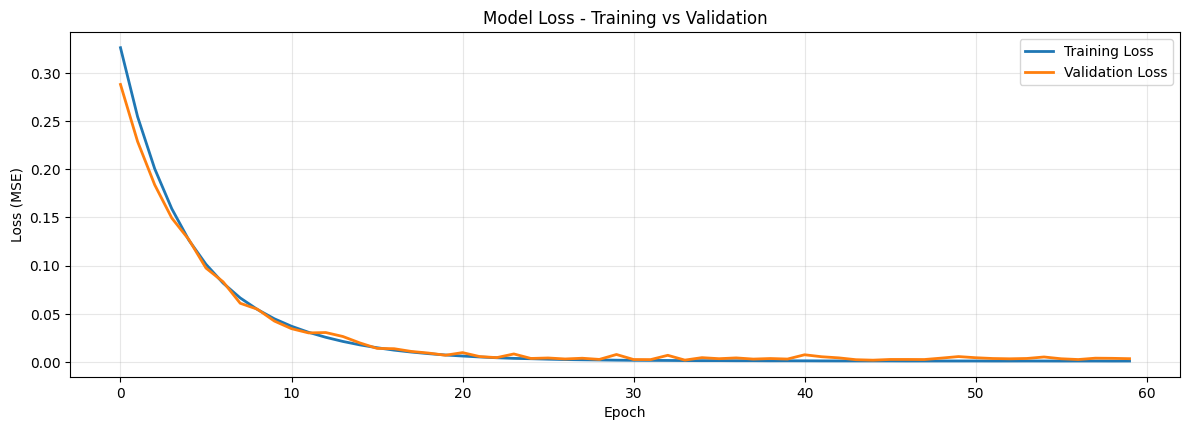

Epoch tốt nhất: 45 với val_loss: 0.001798


In [36]:
# Cell: Vẽ val_loss để đánh giá overfitting
import matplotlib.pyplot as plt

# Trực quan hóa lịch sử huấn luyện để đánh giá overfitting
plt.figure(figsize=(12, 8))

# Subplot 1: Loss
plt.subplot(2, 1, 1)
plt.plot(history_btc.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_btc.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss - Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất
best_epoch = np.argmin(history_btc.history['val_loss']) + 1
best_val_loss = min(history_btc.history['val_loss'])
print(f"Epoch tốt nhất: {best_epoch} với val_loss: {best_val_loss:.6f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


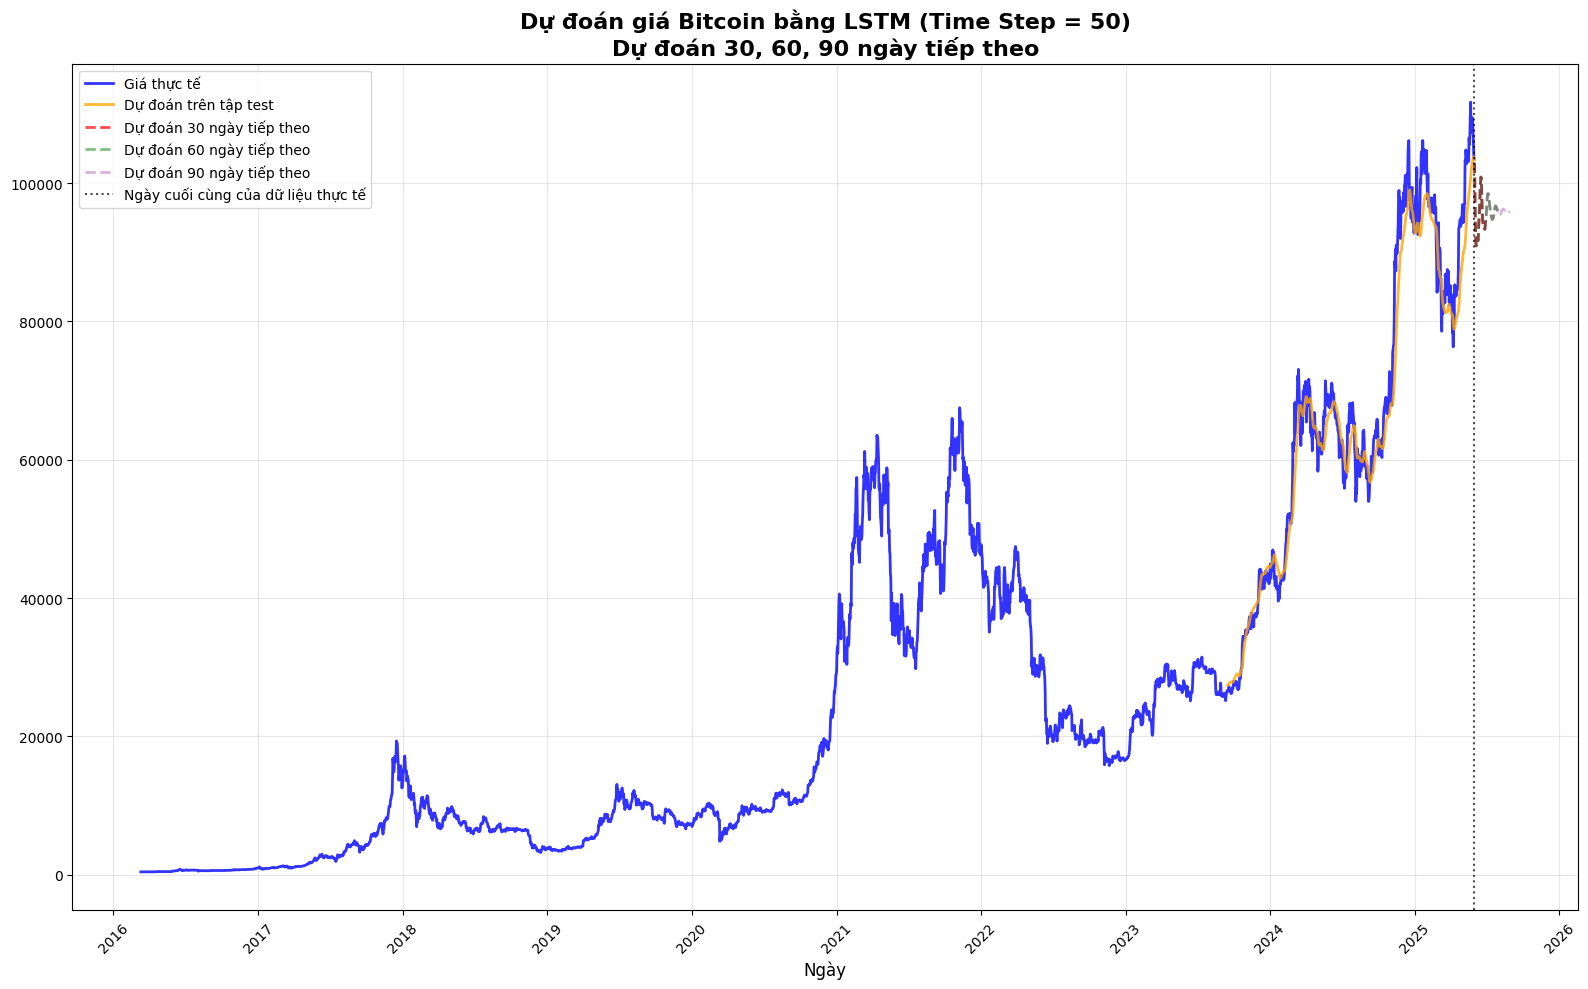

In [37]:
# Dự đoán 30, 60, 90 ngày tiếp theo
# Sử dụng scaled_test_input thay vì scaled_test_btc_82
last_data_scaled = scaled_test_input[-time_step:]

# Sử dụng hàm forecast_multivariate_prices và model_btc
# Sử dụng scaler_target cho inverse_transform
forecasted_prices_30 = forecast_multivariate_prices(model_btc, last_data_scaled, time_step, 30, scaler_target)
forecasted_prices_60 = forecast_multivariate_prices(model_btc, last_data_scaled, time_step, 60, scaler_target)
forecasted_prices_90 = forecast_multivariate_prices(model_btc, last_data_scaled, time_step, 90, scaler_target)

# Dự đoán giá trên tập kiểm tra
# Sử dụng X_test và model_btc
test_predict_scaled = model_btc.predict(X_test)
# Sử dụng scaler_target cho inverse_transform
test_predict_btc = scaler_target.inverse_transform(test_predict_scaled)

# Tạo DataFrame cho các dự đoán
forecast_dates_30 = pd.date_range(start=BTC.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=BTC.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=BTC.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30 = pd.DataFrame(forecasted_prices_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecasted_prices_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecasted_prices_90, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa kết quả với tất cả các dự đoán
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế
plt.plot(BTC.index, BTC['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test
# Sử dụng test_btc
plt.plot(test_btc.index[time_step:], test_predict_btc,
         label='Dự đoán trên tập test', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'],
         label='Dự đoán 30 ngày tiếp theo', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60.index, forecast_df_60['Price'],
         label='Dự đoán 60 ngày tiếp theo', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90.index, forecast_df_90['Price'],
         label='Dự đoán 90 ngày tiếp theo', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Thêm đường thẳng đứng để phân biệt vùng dữ liệu
plt.axvline(x=BTC.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá Bitcoin bằng MLP (Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

# Cải thiện hiển thị trục x
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [38]:
# Cell: Đánh giá mô hình
# Import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_percentage_error

# Lấy giá trị thực tế trên tập test
y_test_actual = test_btc['Price'].values[time_step:]

# Tính toán các metrics
# Sử dụng test_predict_btc thay vì test_predict
mape = mean_absolute_percentage_error(y_test_actual, test_predict_btc.flatten())
mse = mean_squared_error(y_test_actual, test_predict_btc.flatten())
rmse = np.sqrt(mse)

print(f'Kết quả đánh giá mô hình Multivariate MLP (Time Step = {time_step}):')
print(f'MAPE: {mape:.2f}%')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Số epochs huấn luyện: {len(history_btc.history["loss"])}')

# Hiển thị thông tin dự đoán 30 ngày
# Sử dụng forecasted_prices_30 thay vì forecasted_prices
print(f'\nDự đoán giá Bitcoin 30 ngày tiếp theo:')
print(f'Giá cao nhất: {forecasted_prices_30.max():.2f}')
print(f'Giá thấp nhất: {forecasted_prices_30.min():.2f}')
print(f'Giá trung bình: {forecasted_prices_30.mean():.2f}')

Kết quả đánh giá mô hình Multivariate MLP (Time Step = 50):
MAPE: 0.04%
MSE: 17267681.65
RMSE: 4155.44
Số epochs huấn luyện: 60

Dự đoán giá Bitcoin 30 ngày tiếp theo:
Giá cao nhất: 102918.37
Giá thấp nhất: 90912.43
Giá trung bình: 95095.37


#### *Chọn 70% dữ liệu cho training*

In [39]:
# Cell: Chia dữ liệu train/test
# Chia tập train, test
train_size = int(len(BTC) * 0.7)
train_btc = BTC.iloc[0:train_size,:]
test_btc = BTC.iloc[train_size:len(BTC),:]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input = scaled_input[0:train_size,:]
scaled_test_input = scaled_input[train_size:,:]
scaled_train_target = scaled_target[0:train_size,:]
scaled_test_target = scaled_target[train_size:,:]

print(f"Kích thước tập train: {len(train_btc)}")
print(f"Kích thước tập test: {len(test_btc)}")

Kích thước tập train: 2359
Kích thước tập test: 1011


In [40]:
# Giữ nguyên phần tạo dữ liệu (đã chuẩn bị phù hợp cho MLP hoặc MLP với Flatten)
time_step = 50
# Call the modified function to get 3D data
X_train, y_train = create_multivariate_time_series_data(scaled_train_input, scaled_train_target, time_step)
X_test, y_test = create_multivariate_time_series_data(scaled_test_input, scaled_test_target, time_step)

# After fixing create_multivariate_time_series_data, the shape should be (samples, time_step, num_features)
print(f"X_train shape: {X_train.shape}")  # Expected shape: (samples, 50, 3)
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")    # Expected shape: (samples, 50, 3)
print(f"y_test shape: {y_test.shape}")

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint # Ensure these are imported if not globally

# Xây dựng mô hình MLP với regularization
model_btc = build_mlp_model_with_regularization(time_step, 3)  # 3 features

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model_btc_optimized.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

history_btc = model_btc.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

X_train shape: (2309, 50, 3)
y_train shape: (2309,)
X_test shape: (961, 50, 3)
y_test shape: (961,)
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3668 - mae: 0.0820
Epoch 1: val_loss improved from inf to 0.29405, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.3658 - mae: 0.0811 - val_loss: 0.2940 - val_mae: 0.0294 - learning_rate: 1.0000e-04
Epoch 2/60
135/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2848 - mae: 0.0400
Epoch 2: val_loss improved from 0.29405 to 0.24096, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2838 - mae: 0.0399 - val_loss: 0.2410 - val_mae: 0.0262 - learning_rate: 1.0000e-04
Epoch 3/60
139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2327 - mae: 0.0336
Epoch 3: val_loss improved from 0.24096 to 0.19983, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2321 - mae: 0.0334 - val_loss: 0.1998 - val_mae: 0.0330 - learning_rate: 1.0000e-04
Epoch 4/60
141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1916 - mae: 0.0278
Epoch 4: val_loss improved from 0.19983 to 0.16754, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1913 - mae: 0.0277 - val_loss: 0.1675 - val_mae: 0.0446 - learning_rate: 1.0000e-04
Epoch 5/60
131/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1594 - mae: 0.0230
Epoch 5: val_loss improved from 0.16754 to 0.13933, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1587 - mae: 0.0231 - val_loss: 0.1393 - val_mae: 0.0332 - learning_rate: 1.0000e-04
Epoch 6/60
137/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1337 - mae: 0.0233
Epoch 6: val_loss improved from 0.13933 to 0.11840, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1333 - mae: 0.0232 - val_loss: 0.1184 - val_mae: 0.0381 - learning_rate: 1.0000e-04
Epoch 7/60
139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1129 - mae: 0.0218
Epoch 7: val_loss improved from 0.11840 to 0.10152, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1127 - mae: 0.0218 - val_loss: 0.1015 - val_mae: 0.0416 - learning_rate: 1.0000e-04
Epoch 8/60
142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0962 - mae: 0.0201
Epoch 8: val_loss improved from 0.10152 to 0.08892, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0961 - mae: 0.0201 - val_loss: 0.0889 - val_mae: 0.0522 - learning_rate: 1.0000e-04
Epoch 9/60
140/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0827 - mae: 0.0182
Epoch 9: val_loss improved from 0.08892 to 0.07758, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0826 - mae: 0.0182 - val_loss: 0.0776 - val_mae: 0.0536 - learning_rate: 1.0000e-04
Epoch 10/60
142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0717 - mae: 0.0180
Epoch 10: val_loss improved from 0.07758 to 0.06528, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0716 - mae: 0.0180 - val_loss: 0.0653 - val_mae: 0.0282 - learning_rate: 1.0000e-04
Epoch 11/60
142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0627 - mae: 0.0191
Epoch 11: val_loss improved from 0.06528 to 0.05963, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0627 - mae: 0.0191 - val_loss: 0.0596 - val_mae: 0.0491 - learning_rate: 1.0000e-04
Epoch 12/60
136/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0551 - mae: 0.0186
Epoch 12: val_loss improved from 0.05963 to 0.05041, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0549 - mae: 0.0186 - val_loss: 0.0504 - val_mae: 0.0264 - learning_rate: 1.0000e-04
Epoch 13/60
140/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0483 - mae: 0.0168
Epoch 13: val_loss improved from 0.05041 to 0.04390, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0482 - mae: 0.0168 - val_loss: 0.0439 - val_mae: 0.0203 - learning_rate: 1.0000e-04
Epoch 14/60
134/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0427 - mae: 0.0166
Epoch 14: val_loss improved from 0.04390 to 0.04026, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0426 - mae: 0.0166 - val_loss: 0.0403 - val_mae: 0.0335 - learning_rate: 1.0000e-04
Epoch 15/60
131/145 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0379 - mae: 0.0174
Epoch 15: val_loss improved from 0.04026 to 0.03459, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0378 - mae: 0.0174 - val_loss: 0.0346 - val_mae: 0.0226 - learning_rate: 1.0000e-04
Epoch 16/60
131/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0335 - mae: 0.0170
Epoch 16: val_loss improved from 0.03459 to 0.03081, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0334 - mae: 0.0169 - val_loss: 0.0308 - val_mae: 0.0239 - learning_rate: 1.0000e-04
Epoch 17/60
138/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0296 - mae: 0.0180
Epoch 17: val_loss improved from 0.03081 to 0.02875, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0296 - mae: 0.0180 - val_loss: 0.0288 - val_mae: 0.0373 - learning_rate: 1.0000e-04
Epoch 18/60
135/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0261 - mae: 0.0161
Epoch 18: val_loss improved from 0.02875 to 0.02380, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0260 - mae: 0.0162 - val_loss: 0.0238 - val_mae: 0.0217 - learning_rate: 1.0000e-04
Epoch 19/60
139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0230 - mae: 0.0169
Epoch 19: val_loss improved from 0.02380 to 0.02115, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0230 - mae: 0.0169 - val_loss: 0.0211 - val_mae: 0.0224 - learning_rate: 1.0000e-04
Epoch 20/60
135/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0203 - mae: 0.0171
Epoch 20: val_loss improved from 0.02115 to 0.01954, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0203 - mae: 0.0170 - val_loss: 0.0195 - val_mae: 0.0306 - learning_rate: 1.0000e-04
Epoch 21/60
136/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0179 - mae: 0.0177
Epoch 21: val_loss improved from 0.01954 to 0.01634, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0179 - mae: 0.0177 - val_loss: 0.0163 - val_mae: 0.0222 - learning_rate: 1.0000e-04
Epoch 22/60
141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0155 - mae: 0.0155
Epoch 22: val_loss improved from 0.01634 to 0.01544, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0155 - mae: 0.0155 - val_loss: 0.0154 - val_mae: 0.0315 - learning_rate: 1.0000e-04
Epoch 23/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138 - mae: 0.0167
Epoch 23: val_loss improved from 0.01544 to 0.01303, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0138 - mae: 0.0167 - val_loss: 0.0130 - val_mae: 0.0256 - learning_rate: 1.0000e-04
Epoch 24/60
131/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - mae: 0.0161
Epoch 24: val_loss improved from 0.01303 to 0.01302, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0119 - mae: 0.0161 - val_loss: 0.0130 - val_mae: 0.0390 - learning_rate: 1.0000e-04
Epoch 25/60
131/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104 - mae: 0.0153
Epoch 25: val_loss improved from 0.01302 to 0.00998, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0104 - mae: 0.0154 - val_loss: 0.0100 - val_mae: 0.0243 - learning_rate: 1.0000e-04
Epoch 26/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - mae: 0.0163
Epoch 26: val_loss improved from 0.00998 to 0.00843, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0092 - mae: 0.0163 - val_loss: 0.0084 - val_mae: 0.0232 - learning_rate: 1.0000e-04
Epoch 27/60
139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081 - mae: 0.0173
Epoch 27: val_loss did not improve from 0.00843
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0081 - mae: 0.0173 - val_loss: 0.0091 - val_mae: 0.0359 - learning_rate: 1.0000e-04
Epoch 28/60
138/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - mae: 0.0169
Epoch 28: val_loss improved from 0.00843 to 0.00805, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0071 - mae: 0.0169 - val_loss: 0.0081 - val_mae: 0.0348 - learning_rate: 1.0000e-04
Epoch 29/60
139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - mae: 0.0157
Epoch 29: val_loss improved from 0.00805 to 0.00637, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0060 - mae: 0.0157 - val_loss: 0.0064 - val_mae: 0.0267 - learning_rate: 1.0000e-04
Epoch 30/60
139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - mae: 0.0172
Epoch 30: val_loss improved from 0.00637 to 0.00503, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0054 - mae: 0.0172 - val_loss: 0.0050 - val_mae: 0.0236 - learning_rate: 1.0000e-04
Epoch 31/60
132/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 - mae: 0.0163
Epoch 31: val_loss improved from 0.00503 to 0.00497, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0048 - mae: 0.0163 - val_loss: 0.0050 - val_mae: 0.0261 - learning_rate: 1.0000e-04
Epoch 32/60
133/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - mae: 0.0168
Epoch 32: val_loss improved from 0.00497 to 0.00417, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0042 - mae: 0.0167 - val_loss: 0.0042 - val_mae: 0.0232 - learning_rate: 1.0000e-04
Epoch 33/60
135/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - mae: 0.0162
Epoch 33: val_loss did not improve from 0.00417
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0037 - mae: 0.0162 - val_loss: 0.0067 - val_mae: 0.0467 - learning_rate: 1.0000e-04
Epoch 34/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - mae: 0.0172
Epoch 34: val_loss did not improve from 0.00417
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0033 - mae: 0.0172 - val_loss: 0.0049 - val_mae: 0.0357 - learning_rate: 1.0000e-04
Epoch 35/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - mae: 0.0156
Epoch 35: val_loss improved from 0.00417 to 0.00312, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - mae: 0.0156 - val_loss: 0.0031 - val_mae: 0.0243 - learning_rate: 1.0000e-04
Epoch 36/60
136/145 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - mae: 0.0165
Epoch 36: val_loss did not improve from 0.00312
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0027 - mae: 0.0165 - val_loss: 0.0042 - val_mae: 0.0342 - learning_rate: 1.0000e-04
Epoch 37/60
136/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - mae: 0.0157
Epoch 37: val_loss did not improve from 0.00312
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0024 - mae: 0.0157 - val_loss: 0.0032 - val_mae: 0.0289 - learning_rate: 1.0000e-04
Epoch 38/60
132/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - mae: 0.0164
Epoch 38: val_loss did not improve from 0.00312
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022 - mae: 0.0163 - val_loss: 0.0033 - val_mae: 0.0301 - learning_rate: 1.0000e-04
Epoch 39/60
131/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - 

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019 - mae: 0.0162 - val_loss: 0.0027 - val_mae: 0.0272 - learning_rate: 1.0000e-04
Epoch 41/60
137/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - mae: 0.0155
Epoch 41: val_loss improved from 0.00267 to 0.00213, saving model to best_model_btc_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017 - mae: 0.0155 - val_loss: 0.0021 - val_mae: 0.0244 - learning_rate: 1.0000e-04
Epoch 42/60
134/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - mae: 0.0162
Epoch 42: val_loss did not improve from 0.00213
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - mae: 0.0162 - val_loss: 0.0031 - val_mae: 0.0326 - learning_rate: 1.0000e-04
Epoch 43/60
134/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - mae: 0.0153
Epoch 43: val_loss did not improve from 0.00213
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - mae: 0.0154 - val_loss: 0.0068 - val_mae: 0.0582 - learning_rate: 1.0000e-04
Epoch 44/60
132/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mae: 0.0157
Epoch 44: val_loss did not improve from 0.00213
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - mae: 0.0157 - val_loss: 0.0037 - val_mae: 0.0377 - learning_rate: 1.0000e-04
Epoch 45/60
129/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - 

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013 - mae: 0.0155 - val_loss: 0.0016 - val_mae: 0.0256 - learning_rate: 1.0000e-04
Epoch 47/60
141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - mae: 0.0163
Epoch 47: val_loss did not improve from 0.00159
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013 - mae: 0.0163 - val_loss: 0.0018 - val_mae: 0.0256 - learning_rate: 1.0000e-04
Epoch 48/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - mae: 0.0159
Epoch 48: val_loss did not improve from 0.00159
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013 - mae: 0.0159 - val_loss: 0.0017 - val_mae: 0.0240 - learning_rate: 1.0000e-04
Epoch 49/60
136/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - mae: 0.0162
Epoch 49: val_loss did not improve from 0.00159
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012 - mae: 0.0162 - val_loss: 0.0032 - val_mae: 0.0360 - learning_rate: 1.0000e-04
Epoch 50/60
139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - 

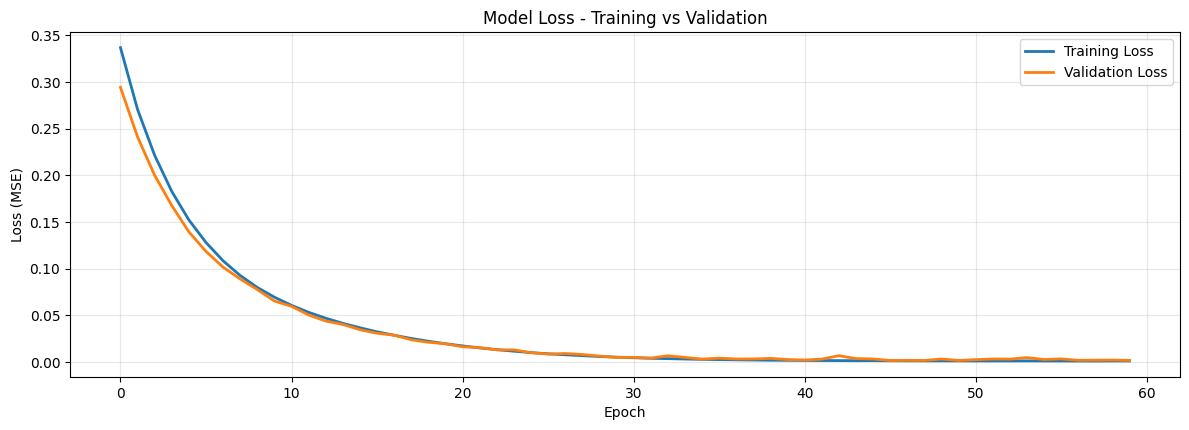

Epoch tốt nhất: 46 với val_loss: 0.001594


In [41]:
# Cell: Vẽ val_loss để đánh giá overfitting
import matplotlib.pyplot as plt

# Trực quan hóa lịch sử huấn luyện để đánh giá overfitting
plt.figure(figsize=(12, 8))

# Subplot 1: Loss
plt.subplot(2, 1, 1)
plt.plot(history_btc.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_btc.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss - Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất
best_epoch = np.argmin(history_btc.history['val_loss']) + 1
best_val_loss = min(history_btc.history['val_loss'])
print(f"Epoch tốt nhất: {best_epoch} với val_loss: {best_val_loss:.6f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


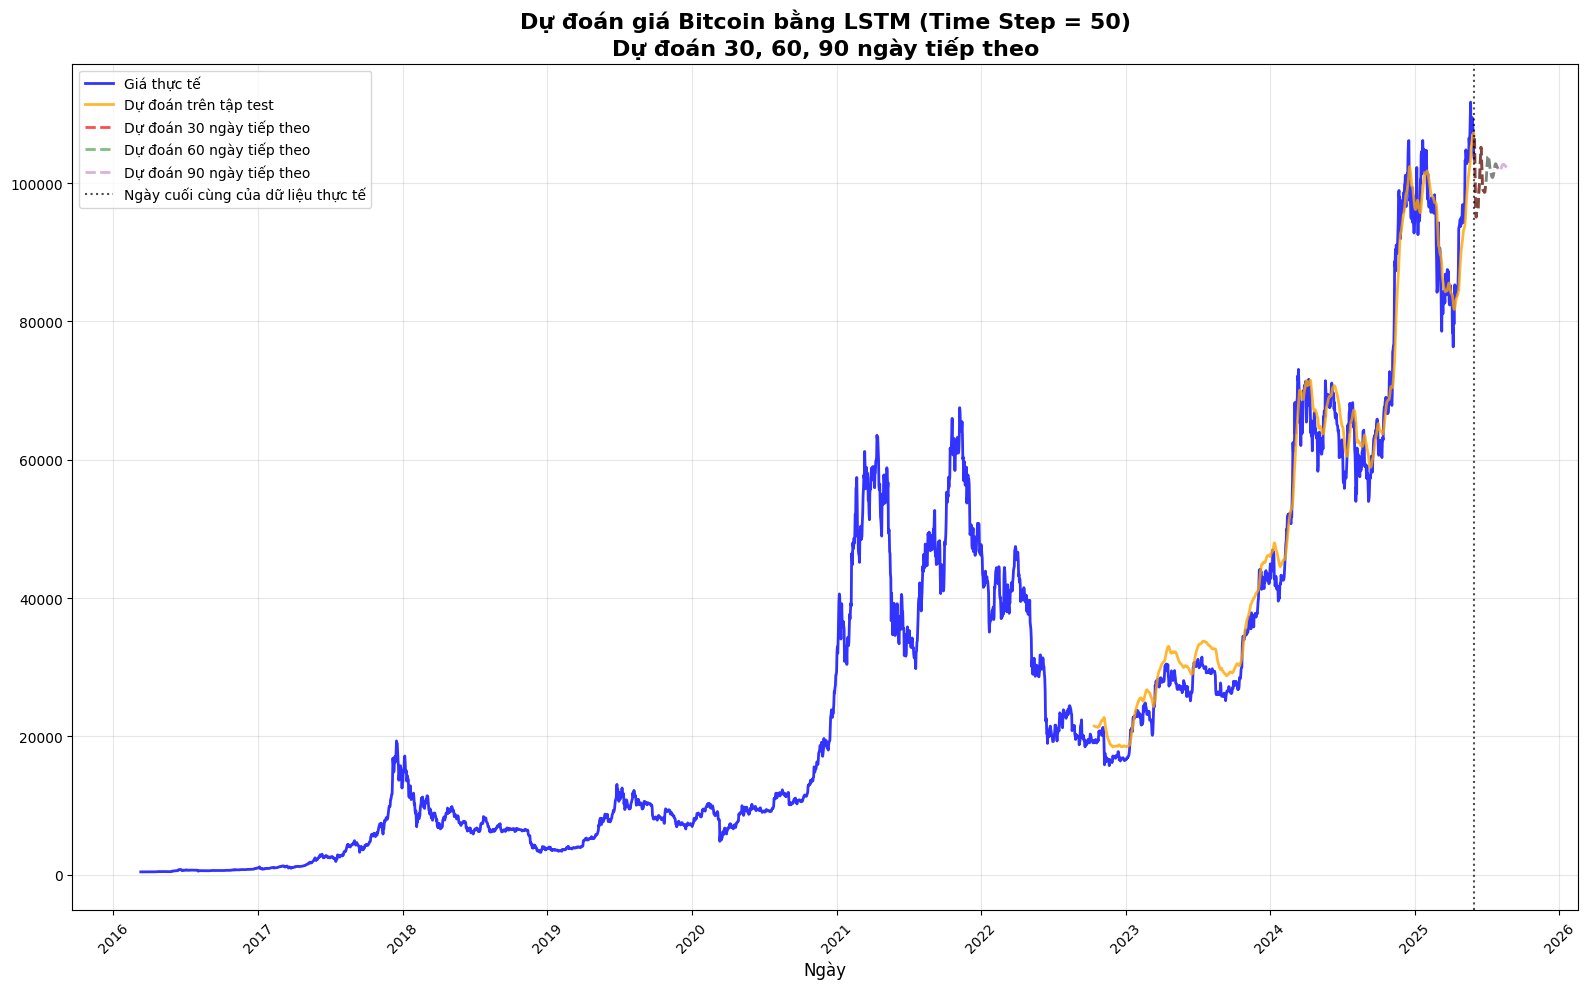

In [42]:
# Dự đoán 30, 60, 90 ngày tiếp theo
# Sử dụng scaled_test_input thay vì scaled_test_btc_82
last_data_scaled = scaled_test_input[-time_step:]

# Sử dụng hàm forecast_multivariate_prices và model_btc
# Sử dụng scaler_target cho inverse_transform
forecasted_prices_30 = forecast_multivariate_prices(model_btc, last_data_scaled, time_step, 30, scaler_target)
forecasted_prices_60 = forecast_multivariate_prices(model_btc, last_data_scaled, time_step, 60, scaler_target)
forecasted_prices_90 = forecast_multivariate_prices(model_btc, last_data_scaled, time_step, 90, scaler_target)

# Dự đoán giá trên tập kiểm tra
# Sử dụng X_test và model_btc
test_predict_scaled = model_btc.predict(X_test)
# Sử dụng scaler_target cho inverse_transform
test_predict_btc = scaler_target.inverse_transform(test_predict_scaled)

# Tạo DataFrame cho các dự đoán
forecast_dates_30 = pd.date_range(start=BTC.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=BTC.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=BTC.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30 = pd.DataFrame(forecasted_prices_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecasted_prices_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecasted_prices_90, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa kết quả với tất cả các dự đoán
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế
plt.plot(BTC.index, BTC['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test
# Sử dụng test_btc
plt.plot(test_btc.index[time_step:], test_predict_btc,
         label='Dự đoán trên tập test', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'],
         label='Dự đoán 30 ngày tiếp theo', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60.index, forecast_df_60['Price'],
         label='Dự đoán 60 ngày tiếp theo', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90.index, forecast_df_90['Price'],
         label='Dự đoán 90 ngày tiếp theo', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Thêm đường thẳng đứng để phân biệt vùng dữ liệu
plt.axvline(x=BTC.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá Bitcoin bằng MLP (Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

# Cải thiện hiển thị trục x
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
# Cell: Đánh giá mô hình
# Import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_percentage_error

# Lấy giá trị thực tế trên tập test
y_test_actual = test_btc['Price'].values[time_step:]

# Tính toán các metrics
# Sử dụng test_predict_btc thay vì test_predict
mape = mean_absolute_percentage_error(y_test_actual, test_predict_btc.flatten())
mse = mean_squared_error(y_test_actual, test_predict_btc.flatten())
rmse = np.sqrt(mse)

print(f'Kết quả đánh giá mô hình Multivariate MLP (Time Step = {time_step}):')
print(f'MAPE: {mape:.2f}%')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Số epochs huấn luyện: {len(history_btc.history["loss"])}')

# Hiển thị thông tin dự đoán 30 ngày
# Sử dụng forecasted_prices_30 thay vì forecasted_prices
print(f'\nDự đoán giá Bitcoin 30 ngày tiếp theo:')
print(f'Giá cao nhất: {forecasted_prices_30.max():.2f}')
print(f'Giá thấp nhất: {forecasted_prices_30.min():.2f}')
print(f'Giá trung bình: {forecasted_prices_30.mean():.2f}')

Kết quả đánh giá mô hình Multivariate LSTM (Time Step = 50):
MAPE: 0.07%
MSE: 11861992.86
RMSE: 3444.12
Số epochs huấn luyện: 60

Dự đoán giá Bitcoin 30 ngày tiếp theo:
Giá cao nhất: 106453.87
Giá thấp nhất: 95084.70
Giá trung bình: 99587.36


#### *Chọn 90% dữ liệu cho training*

In [44]:
# Cell: Chia dữ liệu train/test
# Chia tập train, test
train_size = int(len(BTC) * 0.9)
train_btc = BTC.iloc[0:train_size,:]
test_btc = BTC.iloc[train_size:len(BTC),:]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input = scaled_input[0:train_size,:]
scaled_test_input = scaled_input[train_size:,:]
scaled_train_target = scaled_target[0:train_size,:]
scaled_test_target = scaled_target[train_size:,:]

print(f"Kích thước tập train: {len(train_btc)}")
print(f"Kích thước tập test: {len(test_btc)}")

Kích thước tập train: 3033
Kích thước tập test: 337


In [45]:
# Giữ nguyên phần tạo dữ liệu (đã chuẩn bị phù hợp cho MLP với Flatten)
time_step = 50
# Call the modified function to get 3D data
X_train, y_train = create_multivariate_time_series_data(scaled_train_input, scaled_train_target, time_step)
X_test, y_test = create_multivariate_time_series_data(scaled_test_input, scaled_test_target, time_step)

# After fixing create_multivariate_time_series_data, the shape should be (samples, time_step, num_features)
print(f"X_train shape: {X_train.shape}")  # Expected shape: (samples, 50, 3)
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")    # Expected shape: (samples, 50, 3)
print(f"y_test shape: {y_test.shape}")

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint # Ensure these are imported if not globally

# Xây dựng mô hình MLP với regularization
model_btc = build_mlp_model_with_regularization(time_step, 3)  # 3 features

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model_btc_optimized.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

history_btc = model_btc.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

X_train shape: (2983, 50, 3)
y_train shape: (2983,)
X_test shape: (287, 50, 3)
y_test shape: (287,)
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


180/187 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3600 - mae: 0.0836
Epoch 1: val_loss improved from inf to 0.30173, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.3587 - mae: 0.0827 - val_loss: 0.3017 - val_mae: 0.1426 - learning_rate: 1.0000e-04
Epoch 2/60
178/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2678 - mae: 0.0361
Epoch 2: val_loss improved from 0.30173 to 0.24494, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2669 - mae: 0.0360 - val_loss: 0.2449 - val_mae: 0.1539 - learning_rate: 1.0000e-04
Epoch 3/60
184/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2098 - mae: 0.0289
Epoch 3: val_loss improved from 0.24494 to 0.18925, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2095 - mae: 0.0289 - val_loss: 0.1893 - val_mae: 0.1152 - learning_rate: 1.0000e-04
Epoch 4/60
175/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1680 - mae: 0.0273
Epoch 4: val_loss improved from 0.18925 to 0.16411, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1674 - mae: 0.0272 - val_loss: 0.1641 - val_mae: 0.1480 - learning_rate: 1.0000e-04
Epoch 5/60
177/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1361 - mae: 0.0254
Epoch 5: val_loss improved from 0.16411 to 0.13024, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1357 - mae: 0.0254 - val_loss: 0.1302 - val_mae: 0.1163 - learning_rate: 1.0000e-04
Epoch 6/60
174/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1119 - mae: 0.0231
Epoch 6: val_loss improved from 0.13024 to 0.11403, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1115 - mae: 0.0231 - val_loss: 0.1140 - val_mae: 0.1294 - learning_rate: 1.0000e-04
Epoch 7/60
180/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0933 - mae: 0.0220
Epoch 7: val_loss improved from 0.11403 to 0.10567, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0931 - mae: 0.0220 - val_loss: 0.1057 - val_mae: 0.1532 - learning_rate: 1.0000e-04
Epoch 8/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0786 - mae: 0.0208
Epoch 8: val_loss improved from 0.10567 to 0.08281, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0786 - mae: 0.0208 - val_loss: 0.0828 - val_mae: 0.1137 - learning_rate: 1.0000e-04
Epoch 9/60
174/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0674 - mae: 0.0221
Epoch 9: val_loss improved from 0.08281 to 0.06996, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0672 - mae: 0.0220 - val_loss: 0.0700 - val_mae: 0.1002 - learning_rate: 1.0000e-04
Epoch 10/60
174/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0577 - mae: 0.0204
Epoch 10: val_loss improved from 0.06996 to 0.06153, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0576 - mae: 0.0204 - val_loss: 0.0615 - val_mae: 0.0992 - learning_rate: 1.0000e-04
Epoch 11/60
183/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0494 - mae: 0.0196
Epoch 11: val_loss improved from 0.06153 to 0.05689, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0494 - mae: 0.0196 - val_loss: 0.0569 - val_mae: 0.1109 - learning_rate: 1.0000e-04
Epoch 12/60
184/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0427 - mae: 0.0203
Epoch 12: val_loss improved from 0.05689 to 0.04338, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0426 - mae: 0.0203 - val_loss: 0.0434 - val_mae: 0.0716 - learning_rate: 1.0000e-04
Epoch 13/60
178/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0367 - mae: 0.0200
Epoch 13: val_loss improved from 0.04338 to 0.04087, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0366 - mae: 0.0199 - val_loss: 0.0409 - val_mae: 0.0895 - learning_rate: 1.0000e-04
Epoch 14/60
175/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0314 - mae: 0.0198
Epoch 14: val_loss improved from 0.04087 to 0.03518, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0313 - mae: 0.0198 - val_loss: 0.0352 - val_mae: 0.0833 - learning_rate: 1.0000e-04
Epoch 15/60
183/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0268 - mae: 0.0191
Epoch 15: val_loss improved from 0.03518 to 0.02790, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0268 - mae: 0.0191 - val_loss: 0.0279 - val_mae: 0.0628 - learning_rate: 1.0000e-04
Epoch 16/60
181/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0228 - mae: 0.0184
Epoch 16: val_loss improved from 0.02790 to 0.02178, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0227 - mae: 0.0184 - val_loss: 0.0218 - val_mae: 0.0406 - learning_rate: 1.0000e-04
Epoch 17/60
174/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0194 - mae: 0.0194
Epoch 17: val_loss did not improve from 0.02178
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0194 - mae: 0.0194 - val_loss: 0.0255 - val_mae: 0.0898 - learning_rate: 1.0000e-04
Epoch 18/60
178/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0164 - mae: 0.0189
Epoch 18: val_loss improved from 0.02178 to 0.01817, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0163 - mae: 0.0189 - val_loss: 0.0182 - val_mae: 0.0592 - learning_rate: 1.0000e-04
Epoch 19/60
178/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138 - mae: 0.0183
Epoch 19: val_loss improved from 0.01817 to 0.01389, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0138 - mae: 0.0183 - val_loss: 0.0139 - val_mae: 0.0407 - learning_rate: 1.0000e-04
Epoch 20/60
174/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 - mae: 0.0188
Epoch 20: val_loss improved from 0.01389 to 0.01185, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117 - mae: 0.0188 - val_loss: 0.0118 - val_mae: 0.0394 - learning_rate: 1.0000e-04
Epoch 21/60
180/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098 - mae: 0.0174
Epoch 21: val_loss did not improve from 0.01185
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0097 - mae: 0.0175 - val_loss: 0.0125 - val_mae: 0.0596 - learning_rate: 1.0000e-04
Epoch 22/60
173/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - mae: 0.0183
Epoch 22: val_loss did not improve from 0.01185
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0083 - mae: 0.0183 - val_loss: 0.0203 - val_mae: 0.1113 - learning_rate: 1.0000e-04
Epoch 23/60
183/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - mae: 0.0196
Epoch 23: val_loss improved from 0.01185 to 0.00661, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0072 - mae: 0.0196 - val_loss: 0.0066 - val_mae: 0.0274 - learning_rate: 1.0000e-04
Epoch 24/60
177/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - mae: 0.0190
Epoch 24: val_loss did not improve from 0.00661
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0060 - mae: 0.0190 - val_loss: 0.0066 - val_mae: 0.0367 - learning_rate: 1.0000e-04
Epoch 25/60
175/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - mae: 0.0181
Epoch 25: val_loss improved from 0.00661 to 0.00543, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0051 - mae: 0.0181 - val_loss: 0.0054 - val_mae: 0.0321 - learning_rate: 1.0000e-04
Epoch 26/60
179/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 - mae: 0.0179
Epoch 26: val_loss did not improve from 0.00543
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0043 - mae: 0.0179 - val_loss: 0.0083 - val_mae: 0.0636 - learning_rate: 1.0000e-04
Epoch 27/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - mae: 0.0189
Epoch 27: val_loss did not improve from 0.00543
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0039 - mae: 0.0189 - val_loss: 0.0056 - val_mae: 0.0446 - learning_rate: 1.0000e-04
Epoch 28/60
179/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - mae: 0.0179
Epoch 28: val_loss improved from 0.00543 to 0.00511, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033 - mae: 0.0179 - val_loss: 0.0051 - val_mae: 0.0440 - learning_rate: 1.0000e-04
Epoch 29/60
179/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0185
Epoch 29: val_loss improved from 0.00511 to 0.00448, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0029 - mae: 0.0185 - val_loss: 0.0045 - val_mae: 0.0413 - learning_rate: 1.0000e-04
Epoch 30/60
176/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - mae: 0.0183
Epoch 30: val_loss did not improve from 0.00448
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0026 - mae: 0.0183 - val_loss: 0.0045 - val_mae: 0.0442 - learning_rate: 1.0000e-04
Epoch 31/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - mae: 0.0176
Epoch 31: val_loss improved from 0.00448 to 0.00359, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0023 - mae: 0.0176 - val_loss: 0.0036 - val_mae: 0.0372 - learning_rate: 1.0000e-04
Epoch 32/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - mae: 0.0184
Epoch 32: val_loss did not improve from 0.00359
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0021 - mae: 0.0184 - val_loss: 0.0078 - val_mae: 0.0732 - learning_rate: 1.0000e-04
Epoch 33/60
177/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - mae: 0.0186
Epoch 33: val_loss did not improve from 0.00359
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0020 - mae: 0.0186 - val_loss: 0.0050 - val_mae: 0.0531 - learning_rate: 1.0000e-04
Epoch 34/60
173/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - mae: 0.0187
Epoch 34: val_loss improved from 0.00359 to 0.00299, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0019 - mae: 0.0187 - val_loss: 0.0030 - val_mae: 0.0353 - learning_rate: 1.0000e-04
Epoch 35/60
180/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - mae: 0.0184
Epoch 35: val_loss improved from 0.00299 to 0.00263, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017 - mae: 0.0184 - val_loss: 0.0026 - val_mae: 0.0327 - learning_rate: 1.0000e-04
Epoch 36/60
173/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - mae: 0.0187
Epoch 36: val_loss did not improve from 0.00263
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017 - mae: 0.0186 - val_loss: 0.0029 - val_mae: 0.0360 - learning_rate: 1.0000e-04
Epoch 37/60
183/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - mae: 0.0198
Epoch 37: val_loss improved from 0.00263 to 0.00214, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017 - mae: 0.0198 - val_loss: 0.0021 - val_mae: 0.0290 - learning_rate: 1.0000e-04
Epoch 38/60
172/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mae: 0.0178
Epoch 38: val_loss did not improve from 0.00214
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0014 - mae: 0.0179 - val_loss: 0.0032 - val_mae: 0.0410 - learning_rate: 1.0000e-04
Epoch 39/60
177/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - mae: 0.0189
Epoch 39: val_loss did not improve from 0.00214
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015 - mae: 0.0189 - val_loss: 0.0043 - val_mae: 0.0513 - learning_rate: 1.0000e-04
Epoch 40/60
180/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - mae: 0.0189
Epoch 40: val_loss improved from 0.00214 to 0.00173, saving model to best_model_btc_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0015 - mae: 0.0188 - val_loss: 0.0017 - val_mae: 0.0263 - learning_rate: 1.0000e-04
Epoch 41/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - mae: 0.0192
Epoch 41: val_loss did not improve from 0.00173
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014 - mae: 0.0191 - val_loss: 0.0050 - val_mae: 0.0581 - learning_rate: 1.0000e-04
Epoch 42/60
176/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - mae: 0.0186
Epoch 42: val_loss did not improve from 0.00173
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - mae: 0.0186 - val_loss: 0.0086 - val_mae: 0.0824 - learning_rate: 1.0000e-04
Epoch 43/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mae: 0.0188
Epoch 43: val_loss did not improve from 0.00173
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - mae: 0.0188 - val_loss: 0.0030 - val_mae: 0.0402 - learning_rate: 1.0000e-04
Epoch 44/60
183/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - 

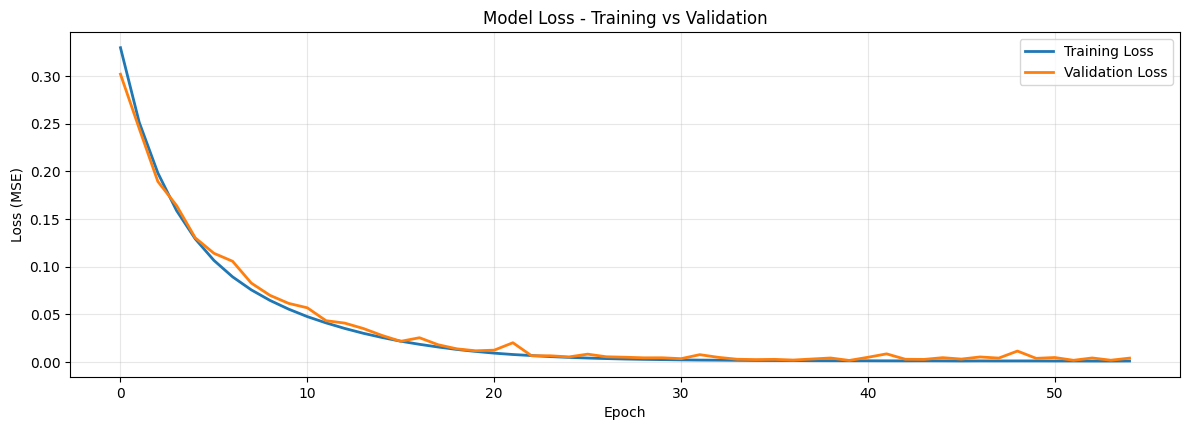

Epoch tốt nhất: 40 với val_loss: 0.001730


In [46]:
# Cell: Vẽ val_loss để đánh giá overfitting
import matplotlib.pyplot as plt

# Trực quan hóa lịch sử huấn luyện để đánh giá overfitting
plt.figure(figsize=(12, 8))

# Subplot 1: Loss
plt.subplot(2, 1, 1)
plt.plot(history_btc.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_btc.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss - Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất
best_epoch = np.argmin(history_btc.history['val_loss']) + 1
best_val_loss = min(history_btc.history['val_loss'])
print(f"Epoch tốt nhất: {best_epoch} với val_loss: {best_val_loss:.6f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


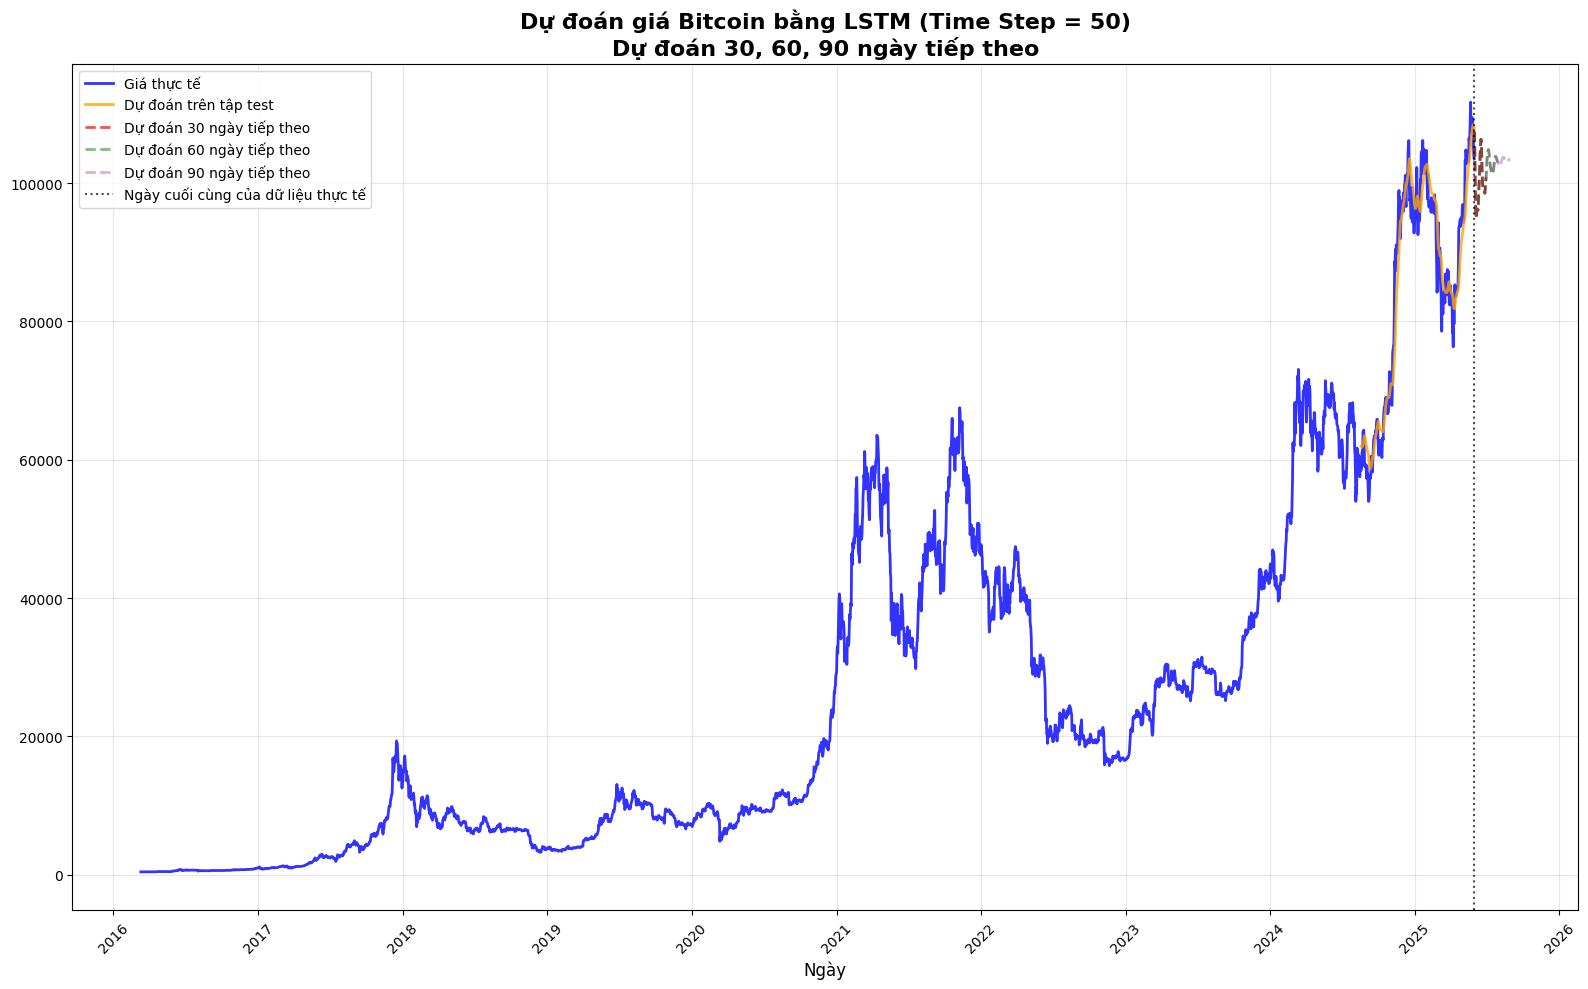

In [47]:
# Dự đoán 30, 60, 90 ngày tiếp theo
# Sử dụng scaled_test_input thay vì scaled_test_btc_82
last_data_scaled = scaled_test_input[-time_step:]

# Sử dụng hàm forecast_multivariate_prices và model_btc
# Sử dụng scaler_target cho inverse_transform
forecasted_prices_30 = forecast_multivariate_prices(model_btc, last_data_scaled, time_step, 30, scaler_target)
forecasted_prices_60 = forecast_multivariate_prices(model_btc, last_data_scaled, time_step, 60, scaler_target)
forecasted_prices_90 = forecast_multivariate_prices(model_btc, last_data_scaled, time_step, 90, scaler_target)

# Dự đoán giá trên tập kiểm tra
# Sử dụng X_test và model_btc
test_predict_scaled = model_btc.predict(X_test)
# Sử dụng scaler_target cho inverse_transform
test_predict_btc = scaler_target.inverse_transform(test_predict_scaled)

# Tạo DataFrame cho các dự đoán
forecast_dates_30 = pd.date_range(start=BTC.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=BTC.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=BTC.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30 = pd.DataFrame(forecasted_prices_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecasted_prices_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecasted_prices_90, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa kết quả với tất cả các dự đoán
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế
plt.plot(BTC.index, BTC['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test
# Sử dụng test_btc
plt.plot(test_btc.index[time_step:], test_predict_btc,
         label='Dự đoán trên tập test', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'],
         label='Dự đoán 30 ngày tiếp theo', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60.index, forecast_df_60['Price'],
         label='Dự đoán 60 ngày tiếp theo', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90.index, forecast_df_90['Price'],
         label='Dự đoán 90 ngày tiếp theo', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Thêm đường thẳng đứng để phân biệt vùng dữ liệu
plt.axvline(x=BTC.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá Bitcoin bằng MLP (Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

# Cải thiện hiển thị trục x
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [48]:
# Cell: Đánh giá mô hình
# Import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_percentage_error

# Lấy giá trị thực tế trên tập test
y_test_actual = test_btc['Price'].values[time_step:]

# Tính toán các metrics
# Sử dụng test_predict_btc thay vì test_predict
mape = mean_absolute_percentage_error(y_test_actual, test_predict_btc.flatten())
mse = mean_squared_error(y_test_actual, test_predict_btc.flatten())
rmse = np.sqrt(mse)

print(f'Kết quả đánh giá mô hình Multivariate MLP (Time Step = {time_step}):')
print(f'MAPE: {mape:.2f}%')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Số epochs huấn luyện: {len(history_btc.history["loss"])}')

# Hiển thị thông tin dự đoán 30 ngày
# Sử dụng forecasted_prices_30 thay vì forecasted_prices
print(f'\nDự đoán giá Bitcoin 30 ngày tiếp theo:')
print(f'Giá cao nhất: {forecasted_prices_30.max():.2f}')
print(f'Giá thấp nhất: {forecasted_prices_30.min():.2f}')
print(f'Giá trung bình: {forecasted_prices_30.mean():.2f}')

Kết quả đánh giá mô hình Multivariate LSTM (Time Step = 50):
MAPE: 0.03%
MSE: 14076710.02
RMSE: 3751.89
Số epochs huấn luyện: 55

Dự đoán giá Bitcoin 30 ngày tiếp theo:
Giá cao nhất: 107443.26
Giá thấp nhất: 94901.62
Giá trung bình: 100037.15


### **ETHEREUM**

#### *Tiền xử lý dữ liệu*

In [49]:
# Đọc file
ETH = pd.read_csv('Ethereum Historical Data.csv')

# Loại bỏ dấu phẩy và chuyển đổi thành float cho Price và Open
for col in ['Price', 'Open']:
    ETH[col] = ETH[col].str.replace(',', '', regex=False).astype(float)

# Xử lý cột 'Vol.' chứa hậu tố 'K', 'M', 'B' thành số thực
def convert_volume(val):
    val = str(val).replace(',', '').strip()
    if 'K' in val:
        return float(val.replace('K', '')) * 1_000
    elif 'M' in val:
        return float(val.replace('M', '')) * 1_000_000
    elif 'B' in val:
        return float(val.replace('B', '')) * 1_000_000_000
    else:
        try:
            return float(val)
        except ValueError:
            return np.nan  # Trường hợp val là '' hoặc không chuyển được

ETH['Vol.'] = ETH['Vol.'].apply(convert_volume)

# Kiểm tra NaN ban đầu trong Vol.
print(f"Trước khi xử lý, số NaN ở Vol.: {ETH['Vol.'].isna().sum()}")

# Nội suy giá trị Vol. (chỉ sau khi đã convert sang số)
ETH['Vol.'] = ETH['Vol.'].interpolate(method='linear')

# Điền 0 cho NaN còn lại
ETH['Vol.'] = ETH['Vol.'].fillna(0)

# Kiểm tra NaN sau xử lý
print(f"Sau khi xử lý, số NaN ở Vol.: {ETH['Vol.'].isna().sum()}")

# Đổi Date sang datetime và đặt làm index
ETH['Date'] = pd.to_datetime(ETH['Date'])
ETH.set_index('Date', inplace=True)
ETH.sort_index(inplace=True)

# Thông tin dữ liệu
print("Data shape:", ETH.shape)
print("Columns:", ETH.columns.tolist())
print("\nFirst 5 rows:")
print(ETH[['Price', 'Open', 'Vol.']].head())

print(f"Tổng số dữ liệu: {len(ETH)} dòng")

Trước khi xử lý, số NaN ở Vol.: 8
Sau khi xử lý, số NaN ở Vol.: 0
Data shape: (3370, 6)
Columns: ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

First 5 rows:
            Price   Open     Vol.
Date                             
2016-03-10  11.75  11.20      0.0
2016-03-11  11.95  11.75    180.0
2016-03-12  12.92  11.95    830.0
2016-03-13  15.07  12.92   1300.0
2016-03-14  12.50  15.07  92180.0
Tổng số dữ liệu: 3370 dòng


#### *Chuẩn hóa dữ liệu*

In [50]:
# Cell: Chuẩn hóa dữ liệu cho Ethereum

# Lấy 3 cột Price, Open, Vol. để làm đầu vào và Price làm đầu ra
input_features = ETH[['Price', 'Open', 'Vol.']].values
target_feature = ETH[['Price']].values

# Áp dụng MinMaxScaler cho input features
scaler_input = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler_input.fit_transform(input_features)

# Áp dụng MinMaxScaler cho target feature
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_feature)

#### *Chọn 80% dữ liệu cho training*

In [51]:
# Cell: Chia dữ liệu train/test cho Ethereum

# Chia tập train, test
train_size = int(len(ETH) * 0.8)
train_eth = ETH.iloc[0:train_size, :]
test_eth = ETH.iloc[train_size:len(ETH), :]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input = scaled_input[0:train_size, :]
scaled_test_input = scaled_input[train_size:, :]
scaled_train_target = scaled_target[0:train_size, :]
scaled_test_target = scaled_target[train_size:, :]

print(f"Kích thước tập train: {len(train_eth)}")
print(f"Kích thước tập test: {len(test_eth)}")

Kích thước tập train: 2696
Kích thước tập test: 674


In [57]:
# Cell: Huấn luyện mô hình cho Ethereum

# Tạo dữ liệu train và test với time_step = 50
time_step = 50
X_train, y_train = create_multivariate_time_series_data(scaled_train_input, scaled_train_target, time_step)
X_test, y_test = create_multivariate_time_series_data(scaled_test_input, scaled_test_target, time_step)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Xây dựng mô hình MLP cho ETH
model_eth = build_mlp_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

# Callbacks tối ưu hóa
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model_eth_optimized.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

# Huấn luyện mô hình
history_eth = model_eth.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

X_train shape: (2646, 50, 3)
y_train shape: (2646,)
X_test shape: (624, 50, 3)
y_test shape: (624,)
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3772 - mae: 0.1009
Epoch 1: val_loss improved from inf to 0.30488, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.3757 - mae: 0.0999 - val_loss: 0.3049 - val_mae: 0.0673 - learning_rate: 1.0000e-04
Epoch 2/60
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2982 - mae: 0.0572
Epoch 2: val_loss improved from 0.30488 to 0.25826, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2977 - mae: 0.0570 - val_loss: 0.2583 - val_mae: 0.0449 - learning_rate: 1.0000e-04
Epoch 3/60
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2531 - mae: 0.0448
Epoch 3: val_loss improved from 0.25826 to 0.22550, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2525 - mae: 0.0447 - val_loss: 0.2255 - val_mae: 0.0566 - learning_rate: 1.0000e-04
Epoch 4/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2200 - mae: 0.0431
Epoch 4: val_loss improved from 0.22550 to 0.20322, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2199 - mae: 0.0431 - val_loss: 0.2032 - val_mae: 0.0871 - learning_rate: 1.0000e-04
Epoch 5/60
150/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1928 - mae: 0.0355
Epoch 5: val_loss improved from 0.20322 to 0.19272, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1922 - mae: 0.0356 - val_loss: 0.1927 - val_mae: 0.1367 - learning_rate: 1.0000e-04
Epoch 6/60
152/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1715 - mae: 0.0356
Epoch 6: val_loss improved from 0.19272 to 0.16944, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1711 - mae: 0.0355 - val_loss: 0.1694 - val_mae: 0.1158 - learning_rate: 1.0000e-04
Epoch 7/60
155/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1534 - mae: 0.0323
Epoch 7: val_loss improved from 0.16944 to 0.14629, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1531 - mae: 0.0323 - val_loss: 0.1463 - val_mae: 0.0759 - learning_rate: 1.0000e-04
Epoch 8/60
151/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1388 - mae: 0.0298
Epoch 8: val_loss improved from 0.14629 to 0.13102, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1385 - mae: 0.0299 - val_loss: 0.1310 - val_mae: 0.0593 - learning_rate: 1.0000e-04
Epoch 9/60
153/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1265 - mae: 0.0305
Epoch 9: val_loss improved from 0.13102 to 0.13032, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1263 - mae: 0.0304 - val_loss: 0.1303 - val_mae: 0.1151 - learning_rate: 1.0000e-04
Epoch 10/60
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1153 - mae: 0.0284
Epoch 10: val_loss improved from 0.13032 to 0.12195, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1151 - mae: 0.0284 - val_loss: 0.1220 - val_mae: 0.1209 - learning_rate: 1.0000e-04
Epoch 11/60
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1060 - mae: 0.0288
Epoch 11: val_loss improved from 0.12195 to 0.10149, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1059 - mae: 0.0288 - val_loss: 0.1015 - val_mae: 0.0590 - learning_rate: 1.0000e-04
Epoch 12/60
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0970 - mae: 0.0260
Epoch 12: val_loss improved from 0.10149 to 0.09659, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0969 - mae: 0.0260 - val_loss: 0.0966 - val_mae: 0.0793 - learning_rate: 1.0000e-04
Epoch 13/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0890 - mae: 0.0241
Epoch 13: val_loss improved from 0.09659 to 0.09266, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0890 - mae: 0.0241 - val_loss: 0.0927 - val_mae: 0.0966 - learning_rate: 1.0000e-04
Epoch 14/60
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0822 - mae: 0.0253
Epoch 14: val_loss improved from 0.09266 to 0.07967, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0821 - mae: 0.0253 - val_loss: 0.0797 - val_mae: 0.0585 - learning_rate: 1.0000e-04
Epoch 15/60
153/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0757 - mae: 0.0249
Epoch 15: val_loss improved from 0.07967 to 0.07335, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0756 - mae: 0.0250 - val_loss: 0.0733 - val_mae: 0.0567 - learning_rate: 1.0000e-04
Epoch 16/60
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0697 - mae: 0.0247
Epoch 16: val_loss improved from 0.07335 to 0.06663, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0696 - mae: 0.0247 - val_loss: 0.0666 - val_mae: 0.0481 - learning_rate: 1.0000e-04
Epoch 17/60
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0636 - mae: 0.0225
Epoch 17: val_loss improved from 0.06663 to 0.06336, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0636 - mae: 0.0225 - val_loss: 0.0634 - val_mae: 0.0644 - learning_rate: 1.0000e-04
Epoch 18/60
151/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0586 - mae: 0.0235
Epoch 18: val_loss improved from 0.06336 to 0.05985, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0585 - mae: 0.0236 - val_loss: 0.0599 - val_mae: 0.0741 - learning_rate: 1.0000e-04
Epoch 19/60
152/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0538 - mae: 0.0237
Epoch 19: val_loss improved from 0.05985 to 0.05048, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0537 - mae: 0.0237 - val_loss: 0.0505 - val_mae: 0.0342 - learning_rate: 1.0000e-04
Epoch 20/60
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0494 - mae: 0.0240
Epoch 20: val_loss improved from 0.05048 to 0.04799, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0494 - mae: 0.0239 - val_loss: 0.0480 - val_mae: 0.0517 - learning_rate: 1.0000e-04
Epoch 21/60
149/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0451 - mae: 0.0241
Epoch 21: val_loss improved from 0.04799 to 0.04431, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0450 - mae: 0.0241 - val_loss: 0.0443 - val_mae: 0.0538 - learning_rate: 1.0000e-04
Epoch 22/60
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0411 - mae: 0.0227
Epoch 22: val_loss improved from 0.04431 to 0.03885, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0410 - mae: 0.0227 - val_loss: 0.0389 - val_mae: 0.0371 - learning_rate: 1.0000e-04
Epoch 23/60
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0375 - mae: 0.0222
Epoch 23: val_loss improved from 0.03885 to 0.03562, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0374 - mae: 0.0222 - val_loss: 0.0356 - val_mae: 0.0386 - learning_rate: 1.0000e-04
Epoch 24/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0341 - mae: 0.0230
Epoch 24: val_loss improved from 0.03562 to 0.03164, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0341 - mae: 0.0230 - val_loss: 0.0316 - val_mae: 0.0281 - learning_rate: 1.0000e-04
Epoch 25/60
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0310 - mae: 0.0224
Epoch 25: val_loss improved from 0.03164 to 0.02913, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0310 - mae: 0.0224 - val_loss: 0.0291 - val_mae: 0.0327 - learning_rate: 1.0000e-04
Epoch 26/60
153/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0281 - mae: 0.0224
Epoch 26: val_loss improved from 0.02913 to 0.02689, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0281 - mae: 0.0224 - val_loss: 0.0269 - val_mae: 0.0376 - learning_rate: 1.0000e-04
Epoch 27/60
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0256 - mae: 0.0230
Epoch 27: val_loss improved from 0.02689 to 0.02357, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0256 - mae: 0.0230 - val_loss: 0.0236 - val_mae: 0.0265 - learning_rate: 1.0000e-04
Epoch 28/60
150/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0233 - mae: 0.0233
Epoch 28: val_loss improved from 0.02357 to 0.02317, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0232 - mae: 0.0232 - val_loss: 0.0232 - val_mae: 0.0473 - learning_rate: 1.0000e-04
Epoch 29/60
152/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212 - mae: 0.0249
Epoch 29: val_loss improved from 0.02317 to 0.01919, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0212 - mae: 0.0248 - val_loss: 0.0192 - val_mae: 0.0250 - learning_rate: 1.0000e-04
Epoch 30/60
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189 - mae: 0.0224
Epoch 30: val_loss improved from 0.01919 to 0.01775, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0189 - mae: 0.0224 - val_loss: 0.0178 - val_mae: 0.0303 - learning_rate: 1.0000e-04
Epoch 31/60
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173 - mae: 0.0227
Epoch 31: val_loss improved from 0.01775 to 0.01567, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0172 - mae: 0.0227 - val_loss: 0.0157 - val_mae: 0.0248 - learning_rate: 1.0000e-04
Epoch 32/60
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157 - mae: 0.0222
Epoch 32: val_loss improved from 0.01567 to 0.01419, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0156 - mae: 0.0222 - val_loss: 0.0142 - val_mae: 0.0248 - learning_rate: 1.0000e-04
Epoch 33/60
150/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142 - mae: 0.0228
Epoch 33: val_loss improved from 0.01419 to 0.01309, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0142 - mae: 0.0228 - val_loss: 0.0131 - val_mae: 0.0278 - learning_rate: 1.0000e-04
Epoch 34/60
158/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0134 - mae: 0.0246
Epoch 34: val_loss improved from 0.01309 to 0.01288, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0133 - mae: 0.0245 - val_loss: 0.0129 - val_mae: 0.0393 - learning_rate: 1.0000e-04
Epoch 35/60
149/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 - mae: 0.0222
Epoch 35: val_loss improved from 0.01288 to 0.01058, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117 - mae: 0.0222 - val_loss: 0.0106 - val_mae: 0.0247 - learning_rate: 1.0000e-04
Epoch 36/60
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - mae: 0.0204
Epoch 36: val_loss improved from 0.01058 to 0.00970, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0105 - mae: 0.0204 - val_loss: 0.0097 - val_mae: 0.0249 - learning_rate: 1.0000e-04
Epoch 37/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098 - mae: 0.0233
Epoch 37: val_loss improved from 0.00970 to 0.00884, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0098 - mae: 0.0233 - val_loss: 0.0088 - val_mae: 0.0246 - learning_rate: 1.0000e-04
Epoch 38/60
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - mae: 0.0228
Epoch 38: val_loss did not improve from 0.00884
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0090 - mae: 0.0228 - val_loss: 0.0098 - val_mae: 0.0443 - learning_rate: 1.0000e-04
Epoch 39/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - mae: 0.0208
Epoch 39: val_loss improved from 0.00884 to 0.00824, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0081 - mae: 0.0209 - val_loss: 0.0082 - val_mae: 0.0341 - learning_rate: 1.0000e-04
Epoch 40/60
155/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - mae: 0.0226
Epoch 40: val_loss improved from 0.00824 to 0.00694, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0076 - mae: 0.0226 - val_loss: 0.0069 - val_mae: 0.0250 - learning_rate: 1.0000e-04
Epoch 41/60
155/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - mae: 0.0228
Epoch 41: val_loss improved from 0.00694 to 0.00670, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0071 - mae: 0.0227 - val_loss: 0.0067 - val_mae: 0.0291 - learning_rate: 1.0000e-04
Epoch 42/60
153/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - mae: 0.0216
Epoch 42: val_loss improved from 0.00670 to 0.00631, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0065 - mae: 0.0217 - val_loss: 0.0063 - val_mae: 0.0310 - learning_rate: 1.0000e-04
Epoch 43/60
158/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - mae: 0.0216
Epoch 43: val_loss improved from 0.00631 to 0.00596, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0061 - mae: 0.0216 - val_loss: 0.0060 - val_mae: 0.0305 - learning_rate: 1.0000e-04
Epoch 44/60
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 - mae: 0.0224
Epoch 44: val_loss improved from 0.00596 to 0.00532, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0057 - mae: 0.0224 - val_loss: 0.0053 - val_mae: 0.0269 - learning_rate: 1.0000e-04
Epoch 45/60
158/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - mae: 0.0217
Epoch 45: val_loss improved from 0.00532 to 0.00478, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0052 - mae: 0.0218 - val_loss: 0.0048 - val_mae: 0.0250 - learning_rate: 1.0000e-04
Epoch 46/60
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - mae: 0.0227
Epoch 46: val_loss improved from 0.00478 to 0.00444, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0051 - mae: 0.0226 - val_loss: 0.0044 - val_mae: 0.0236 - learning_rate: 1.0000e-04
Epoch 47/60
158/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046 - mae: 0.0215
Epoch 47: val_loss did not improve from 0.00444
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0046 - mae: 0.0215 - val_loss: 0.0050 - val_mae: 0.0336 - learning_rate: 1.0000e-04
Epoch 48/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 - mae: 0.0236
Epoch 48: val_loss improved from 0.00444 to 0.00438, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0048 - mae: 0.0236 - val_loss: 0.0044 - val_mae: 0.0290 - learning_rate: 1.0000e-04
Epoch 49/60
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - mae: 0.0228
Epoch 49: val_loss did not improve from 0.00438
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0043 - mae: 0.0228 - val_loss: 0.0057 - val_mae: 0.0461 - learning_rate: 1.0000e-04
Epoch 50/60
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - mae: 0.0218
Epoch 50: val_loss improved from 0.00438 to 0.00391, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0040 - mae: 0.0218 - val_loss: 0.0039 - val_mae: 0.0298 - learning_rate: 1.0000e-04
Epoch 51/60
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - mae: 0.0220
Epoch 51: val_loss improved from 0.00391 to 0.00338, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0038 - mae: 0.0221 - val_loss: 0.0034 - val_mae: 0.0243 - learning_rate: 1.0000e-04
Epoch 52/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - mae: 0.0227
Epoch 52: val_loss improved from 0.00338 to 0.00330, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0038 - mae: 0.0227 - val_loss: 0.0033 - val_mae: 0.0253 - learning_rate: 1.0000e-04
Epoch 53/60
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - mae: 0.0234
Epoch 53: val_loss improved from 0.00330 to 0.00312, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0038 - mae: 0.0234 - val_loss: 0.0031 - val_mae: 0.0240 - learning_rate: 1.0000e-04
Epoch 54/60
153/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mae: 0.0204
Epoch 54: val_loss improved from 0.00312 to 0.00292, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0031 - mae: 0.0204 - val_loss: 0.0029 - val_mae: 0.0230 - learning_rate: 1.0000e-04
Epoch 55/60
150/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - mae: 0.0224
Epoch 55: val_loss improved from 0.00292 to 0.00280, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0033 - mae: 0.0224 - val_loss: 0.0028 - val_mae: 0.0229 - learning_rate: 1.0000e-04
Epoch 56/60
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - mae: 0.0208
Epoch 56: val_loss did not improve from 0.00280
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030 - mae: 0.0208 - val_loss: 0.0037 - val_mae: 0.0349 - learning_rate: 1.0000e-04
Epoch 57/60
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mae: 0.0221
Epoch 57: val_loss did not improve from 0.00280
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0031 - mae: 0.0221 - val_loss: 0.0033 - val_mae: 0.0316 - learning_rate: 1.0000e-04
Epoch 58/60
154/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0219
Epoch 58: val_loss improved from 0.00280 to 0.00256, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0029 - mae: 0.0219 - val_loss: 0.0026 - val_mae: 0.0232 - learning_rate: 1.0000e-04
Epoch 59/60
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - mae: 0.0214
Epoch 59: val_loss improved from 0.00256 to 0.00246, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0029 - mae: 0.0214 - val_loss: 0.0025 - val_mae: 0.0232 - learning_rate: 1.0000e-04
Epoch 60/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0223
Epoch 60: val_loss improved from 0.00246 to 0.00241, saving model to best_model_eth_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0029 - mae: 0.0223 - val_loss: 0.0024 - val_mae: 0.0239 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 60.


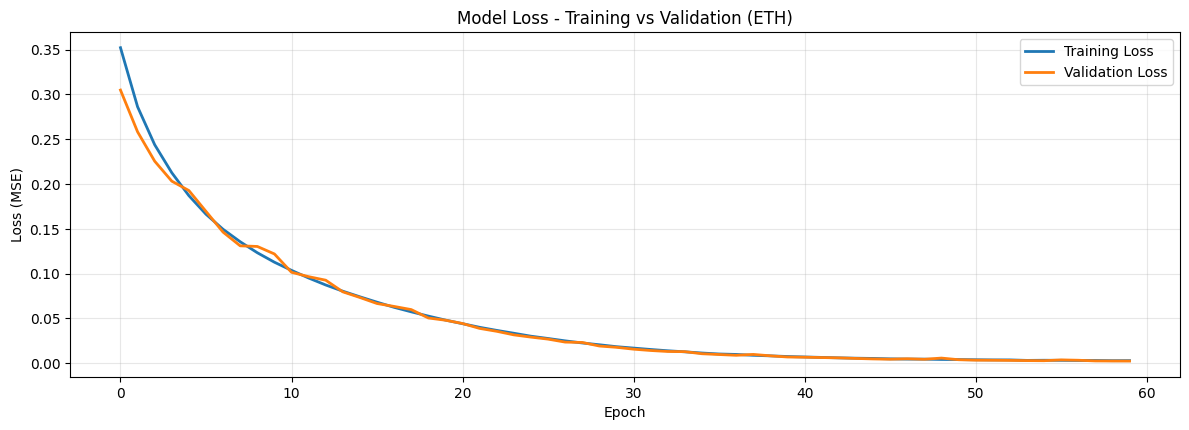

Epoch tốt nhất: 60 với val_loss: 0.002405


In [58]:
# Cell: Vẽ val_loss để đánh giá overfitting cho ETH
import matplotlib.pyplot as plt
import numpy as np

# Trực quan hóa lịch sử huấn luyện để đánh giá overfitting
plt.figure(figsize=(12, 8))

# Subplot 1: Loss
plt.subplot(2, 1, 1)
plt.plot(history_eth.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_eth.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss - Training vs Validation (ETH)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất
best_epoch = np.argmin(history_eth.history['val_loss']) + 1
best_val_loss = min(history_eth.history['val_loss'])
print(f"Epoch tốt nhất: {best_epoch} với val_loss: {best_val_loss:.6f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


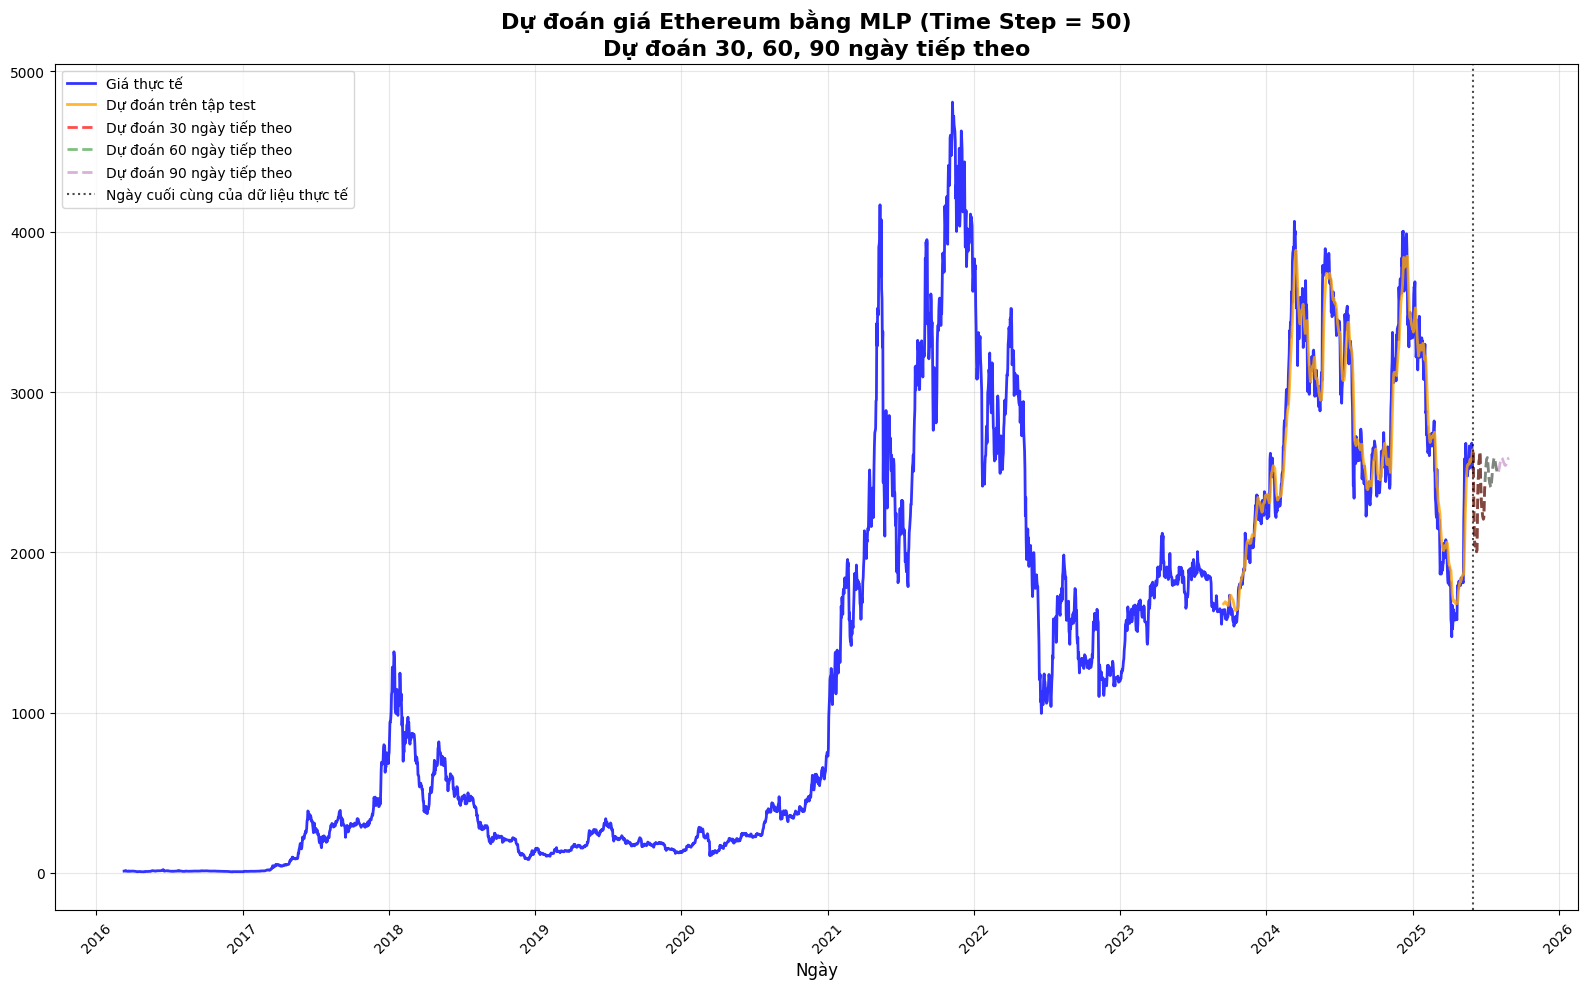

In [59]:
# Dự đoán 30, 60, 90 ngày tiếp theo
last_data_scaled = scaled_test_input[-time_step:]

# Sử dụng model_eth đã huấn luyện và scaler_target_eth
forecasted_prices_30 = forecast_multivariate_prices(model_eth, last_data_scaled, time_step, 30, scaler_target)
forecasted_prices_60 = forecast_multivariate_prices(model_eth, last_data_scaled, time_step, 60, scaler_target)
forecasted_prices_90 = forecast_multivariate_prices(model_eth, last_data_scaled, time_step, 90, scaler_target)

# Dự đoán giá trên tập test
test_predict_scaled = model_eth.predict(X_test)
test_predict_eth = scaler_target.inverse_transform(test_predict_scaled)

# Tạo DataFrame cho các dự đoán
forecast_dates_30 = pd.date_range(start=ETH.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=ETH.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=ETH.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30 = pd.DataFrame(forecasted_prices_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecasted_prices_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecasted_prices_90, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa kết quả với tất cả các dự đoán
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế ETH
plt.plot(ETH.index, ETH['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test
plt.plot(test_eth.index[time_step:], test_predict_eth,
         label='Dự đoán trên tập test', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'],
         label='Dự đoán 30 ngày tiếp theo', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60.index, forecast_df_60['Price'],
         label='Dự đoán 60 ngày tiếp theo', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90.index, forecast_df_90['Price'],
         label='Dự đoán 90 ngày tiếp theo', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Đường phân cách vùng dữ liệu
plt.axvline(x=ETH.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá Ethereum bằng MLP (Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [60]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Lấy giá trị thực tế của Price trong tập test ETH (bỏ qua time_step đầu tiên)
y_test_actual = test_eth['Price'].values[time_step:]

# Dự đoán giá đã inverse_transform ở bước trước: test_predict_eth
mape = mean_absolute_percentage_error(y_test_actual, test_predict_eth.flatten())
mse = mean_squared_error(y_test_actual, test_predict_eth.flatten())
rmse = np.sqrt(mse)

print(f'Kết quả đánh giá mô hình Multivariate MLP cho Ethereum (Time Step = {time_step}):')
print(f'MAPE: {mape:.2f}%')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Số epochs huấn luyện: {len(history_eth.history["loss"])}')

# Thông tin dự đoán 30 ngày
print(f'\nDự đoán giá Ethereum 30 ngày tiếp theo:')
print(f'Giá cao nhất: {forecasted_prices_30.max():.2f}')
print(f'Giá thấp nhất: {forecasted_prices_30.min():.2f}')
print(f'Giá trung bình: {forecasted_prices_30.mean():.2f}')

Kết quả đánh giá mô hình Multivariate MLP cho Ethereum (Time Step = 50):
MAPE: 0.04%
MSE: 24226.60
RMSE: 155.65
Số epochs huấn luyện: 60

Dự đoán giá Ethereum 30 ngày tiếp theo:
Giá cao nhất: 2626.83
Giá thấp nhất: 2003.43
Giá trung bình: 2296.44


#### *Chọn 70% dữ liệu cho training*

In [61]:
# Cell: Chia dữ liệu train/test cho Ethereum

# Chia tập train, test
train_size = int(len(ETH) * 0.7)
train_eth = ETH.iloc[0:train_size, :]
test_eth = ETH.iloc[train_size:len(ETH), :]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input = scaled_input[0:train_size, :]
scaled_test_input = scaled_input[train_size:, :]
scaled_train_target = scaled_target[0:train_size, :]
scaled_test_target = scaled_target[train_size:, :]

print(f"Kích thước tập train: {len(train_eth)}")
print(f"Kích thước tập test: {len(test_eth)}")

Kích thước tập train: 2359
Kích thước tập test: 1011


In [62]:
# Cell: Huấn luyện mô hình cho Ethereum

# Tạo dữ liệu train và test với time_step = 50
time_step = 50
X_train, y_train = create_multivariate_time_series_data(scaled_train_input, scaled_train_target, time_step)
X_test, y_test = create_multivariate_time_series_data(scaled_test_input, scaled_test_target, time_step)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Xây dựng mô hình MLP cho ETH
model_eth = build_mlp_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

# Callbacks tối ưu hóa
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model_eth_optimized.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

# Huấn luyện mô hình
history_eth = model_eth.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

X_train shape: (2309, 50, 3)
y_train shape: (2309,)
X_test shape: (961, 50, 3)
y_test shape: (961,)
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3895 - mae: 0.0933
Epoch 1: val_loss improved from inf to 0.30973, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.3891 - mae: 0.0930 - val_loss: 0.3097 - val_mae: 0.0408 - learning_rate: 1.0000e-04
Epoch 2/60
141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3082 - mae: 0.0517
Epoch 2: val_loss improved from 0.30973 to 0.27280, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3079 - mae: 0.0516 - val_loss: 0.2728 - val_mae: 0.0594 - learning_rate: 1.0000e-04
Epoch 3/60
138/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2676 - mae: 0.0424
Epoch 3: val_loss improved from 0.27280 to 0.24216, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2672 - mae: 0.0424 - val_loss: 0.2422 - val_mae: 0.0646 - learning_rate: 1.0000e-04
Epoch 4/60
136/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2361 - mae: 0.0380
Epoch 4: val_loss improved from 0.24216 to 0.21426, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2356 - mae: 0.0379 - val_loss: 0.2143 - val_mae: 0.0474 - learning_rate: 1.0000e-04
Epoch 5/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2103 - mae: 0.0356
Epoch 5: val_loss improved from 0.21426 to 0.19383, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2102 - mae: 0.0356 - val_loss: 0.1938 - val_mae: 0.0542 - learning_rate: 1.0000e-04
Epoch 6/60
133/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1892 - mae: 0.0295
Epoch 6: val_loss improved from 0.19383 to 0.17478, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1888 - mae: 0.0296 - val_loss: 0.1748 - val_mae: 0.0424 - learning_rate: 1.0000e-04
Epoch 7/60
135/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1717 - mae: 0.0294
Epoch 7: val_loss improved from 0.17478 to 0.16072, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1714 - mae: 0.0294 - val_loss: 0.1607 - val_mae: 0.0514 - learning_rate: 1.0000e-04
Epoch 8/60
138/145 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1572 - mae: 0.0296
Epoch 8: val_loss improved from 0.16072 to 0.14954, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1570 - mae: 0.0295 - val_loss: 0.1495 - val_mae: 0.0653 - learning_rate: 1.0000e-04
Epoch 9/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1443 - mae: 0.0285
Epoch 9: val_loss improved from 0.14954 to 0.13727, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1443 - mae: 0.0285 - val_loss: 0.1373 - val_mae: 0.0587 - learning_rate: 1.0000e-04
Epoch 10/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1333 - mae: 0.0278
Epoch 10: val_loss improved from 0.13727 to 0.12834, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1333 - mae: 0.0278 - val_loss: 0.1283 - val_mae: 0.0666 - learning_rate: 1.0000e-04
Epoch 11/60
138/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1231 - mae: 0.0257
Epoch 11: val_loss improved from 0.12834 to 0.12338, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1229 - mae: 0.0257 - val_loss: 0.1234 - val_mae: 0.0908 - learning_rate: 1.0000e-04
Epoch 12/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1143 - mae: 0.0260
Epoch 12: val_loss improved from 0.12338 to 0.10989, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1142 - mae: 0.0260 - val_loss: 0.1099 - val_mae: 0.0579 - learning_rate: 1.0000e-04
Epoch 13/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1060 - mae: 0.0260
Epoch 13: val_loss improved from 0.10989 to 0.10090, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1060 - mae: 0.0260 - val_loss: 0.1009 - val_mae: 0.0454 - learning_rate: 1.0000e-04
Epoch 14/60
131/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0989 - mae: 0.0259
Epoch 14: val_loss improved from 0.10090 to 0.09814, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0987 - mae: 0.0258 - val_loss: 0.0981 - val_mae: 0.0761 - learning_rate: 1.0000e-04
Epoch 15/60
136/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0914 - mae: 0.0224
Epoch 15: val_loss improved from 0.09814 to 0.09017, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0913 - mae: 0.0225 - val_loss: 0.0902 - val_mae: 0.0668 - learning_rate: 1.0000e-04
Epoch 16/60
130/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0854 - mae: 0.0249
Epoch 16: val_loss improved from 0.09017 to 0.08364, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0852 - mae: 0.0247 - val_loss: 0.0836 - val_mae: 0.0632 - learning_rate: 1.0000e-04
Epoch 17/60
142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0790 - mae: 0.0234
Epoch 17: val_loss improved from 0.08364 to 0.07558, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0789 - mae: 0.0234 - val_loss: 0.0756 - val_mae: 0.0427 - learning_rate: 1.0000e-04
Epoch 18/60
138/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0739 - mae: 0.0236
Epoch 18: val_loss improved from 0.07558 to 0.07184, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0739 - mae: 0.0235 - val_loss: 0.0718 - val_mae: 0.0563 - learning_rate: 1.0000e-04
Epoch 19/60
137/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0683 - mae: 0.0225
Epoch 19: val_loss improved from 0.07184 to 0.06540, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0682 - mae: 0.0226 - val_loss: 0.0654 - val_mae: 0.0432 - learning_rate: 1.0000e-04
Epoch 20/60
137/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0634 - mae: 0.0233
Epoch 20: val_loss improved from 0.06540 to 0.06318, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0633 - mae: 0.0233 - val_loss: 0.0632 - val_mae: 0.0637 - learning_rate: 1.0000e-04
Epoch 21/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0591 - mae: 0.0245
Epoch 21: val_loss improved from 0.06318 to 0.05657, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0591 - mae: 0.0245 - val_loss: 0.0566 - val_mae: 0.0446 - learning_rate: 1.0000e-04
Epoch 22/60
137/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0545 - mae: 0.0222
Epoch 22: val_loss improved from 0.05657 to 0.05249, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0545 - mae: 0.0222 - val_loss: 0.0525 - val_mae: 0.0448 - learning_rate: 1.0000e-04
Epoch 23/60
141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0502 - mae: 0.0208
Epoch 23: val_loss improved from 0.05249 to 0.04712, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0501 - mae: 0.0208 - val_loss: 0.0471 - val_mae: 0.0276 - learning_rate: 1.0000e-04
Epoch 24/60
140/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0462 - mae: 0.0202
Epoch 24: val_loss improved from 0.04712 to 0.04405, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0462 - mae: 0.0202 - val_loss: 0.0440 - val_mae: 0.0343 - learning_rate: 1.0000e-04
Epoch 25/60
132/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0429 - mae: 0.0214
Epoch 25: val_loss improved from 0.04405 to 0.04250, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0429 - mae: 0.0214 - val_loss: 0.0425 - val_mae: 0.0523 - learning_rate: 1.0000e-04
Epoch 26/60
130/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0395 - mae: 0.0216
Epoch 26: val_loss improved from 0.04250 to 0.03636, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0394 - mae: 0.0216 - val_loss: 0.0364 - val_mae: 0.0193 - learning_rate: 1.0000e-04
Epoch 27/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0366 - mae: 0.0218
Epoch 27: val_loss improved from 0.03636 to 0.03623, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0366 - mae: 0.0218 - val_loss: 0.0362 - val_mae: 0.0517 - learning_rate: 1.0000e-04
Epoch 28/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0336 - mae: 0.0219
Epoch 28: val_loss improved from 0.03623 to 0.03073, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0336 - mae: 0.0219 - val_loss: 0.0307 - val_mae: 0.0197 - learning_rate: 1.0000e-04
Epoch 29/60
134/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0308 - mae: 0.0215
Epoch 29: val_loss improved from 0.03073 to 0.02974, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0308 - mae: 0.0216 - val_loss: 0.0297 - val_mae: 0.0388 - learning_rate: 1.0000e-04
Epoch 30/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0283 - mae: 0.0212
Epoch 30: val_loss improved from 0.02974 to 0.02817, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0283 - mae: 0.0212 - val_loss: 0.0282 - val_mae: 0.0461 - learning_rate: 1.0000e-04
Epoch 31/60
140/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0262 - mae: 0.0215
Epoch 31: val_loss improved from 0.02817 to 0.02410, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0262 - mae: 0.0215 - val_loss: 0.0241 - val_mae: 0.0258 - learning_rate: 1.0000e-04
Epoch 32/60
142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0238 - mae: 0.0208
Epoch 32: val_loss improved from 0.02410 to 0.02167, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0238 - mae: 0.0208 - val_loss: 0.0217 - val_mae: 0.0197 - learning_rate: 1.0000e-04
Epoch 33/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0219 - mae: 0.0208
Epoch 33: val_loss improved from 0.02167 to 0.02004, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0219 - mae: 0.0208 - val_loss: 0.0200 - val_mae: 0.0220 - learning_rate: 1.0000e-04
Epoch 34/60
142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0201 - mae: 0.0213
Epoch 34: val_loss improved from 0.02004 to 0.01881, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0201 - mae: 0.0213 - val_loss: 0.0188 - val_mae: 0.0283 - learning_rate: 1.0000e-04
Epoch 35/60
138/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0184 - mae: 0.0206
Epoch 35: val_loss improved from 0.01881 to 0.01705, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0184 - mae: 0.0206 - val_loss: 0.0171 - val_mae: 0.0245 - learning_rate: 1.0000e-04
Epoch 36/60
135/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0171 - mae: 0.0219
Epoch 36: val_loss improved from 0.01705 to 0.01585, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0171 - mae: 0.0219 - val_loss: 0.0158 - val_mae: 0.0309 - learning_rate: 1.0000e-04
Epoch 37/60
141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0157 - mae: 0.0211
Epoch 37: val_loss improved from 0.01585 to 0.01393, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0157 - mae: 0.0210 - val_loss: 0.0139 - val_mae: 0.0193 - learning_rate: 1.0000e-04
Epoch 38/60
134/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143 - mae: 0.0201
Epoch 38: val_loss improved from 0.01393 to 0.01365, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0143 - mae: 0.0201 - val_loss: 0.0137 - val_mae: 0.0306 - learning_rate: 1.0000e-04
Epoch 39/60
141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0132 - mae: 0.0212
Epoch 39: val_loss improved from 0.01365 to 0.01195, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0132 - mae: 0.0212 - val_loss: 0.0120 - val_mae: 0.0213 - learning_rate: 1.0000e-04
Epoch 40/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123 - mae: 0.0218
Epoch 40: val_loss improved from 0.01195 to 0.01083, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0123 - mae: 0.0218 - val_loss: 0.0108 - val_mae: 0.0202 - learning_rate: 1.0000e-04
Epoch 41/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 - mae: 0.0204
Epoch 41: val_loss did not improve from 0.01083
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0113 - mae: 0.0204 - val_loss: 0.0112 - val_mae: 0.0348 - learning_rate: 1.0000e-04
Epoch 42/60
135/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - mae: 0.0217
Epoch 42: val_loss improved from 0.01083 to 0.00920, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0105 - mae: 0.0217 - val_loss: 0.0092 - val_mae: 0.0201 - learning_rate: 1.0000e-04
Epoch 43/60
129/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098 - mae: 0.0211
Epoch 43: val_loss improved from 0.00920 to 0.00885, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0097 - mae: 0.0212 - val_loss: 0.0089 - val_mae: 0.0234 - learning_rate: 1.0000e-04
Epoch 44/60
138/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - mae: 0.0209
Epoch 44: val_loss improved from 0.00885 to 0.00784, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0090 - mae: 0.0209 - val_loss: 0.0078 - val_mae: 0.0190 - learning_rate: 1.0000e-04
Epoch 45/60
131/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - mae: 0.0221
Epoch 45: val_loss did not improve from 0.00784
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0087 - mae: 0.0222 - val_loss: 0.0085 - val_mae: 0.0340 - learning_rate: 1.0000e-04
Epoch 46/60
142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 - mae: 0.0223
Epoch 46: val_loss improved from 0.00784 to 0.00682, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0082 - mae: 0.0222 - val_loss: 0.0068 - val_mae: 0.0194 - learning_rate: 1.0000e-04
Epoch 47/60
142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0075 - mae: 0.0219
Epoch 47: val_loss improved from 0.00682 to 0.00660, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0075 - mae: 0.0218 - val_loss: 0.0066 - val_mae: 0.0253 - learning_rate: 1.0000e-04
Epoch 48/60
137/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - mae: 0.0204
Epoch 48: val_loss improved from 0.00660 to 0.00626, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0069 - mae: 0.0204 - val_loss: 0.0063 - val_mae: 0.0263 - learning_rate: 1.0000e-04
Epoch 49/60
137/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - mae: 0.0204
Epoch 49: val_loss improved from 0.00626 to 0.00570, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0064 - mae: 0.0204 - val_loss: 0.0057 - val_mae: 0.0209 - learning_rate: 1.0000e-04
Epoch 50/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - mae: 0.0209
Epoch 50: val_loss did not improve from 0.00570
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0062 - mae: 0.0210 - val_loss: 0.0058 - val_mae: 0.0267 - learning_rate: 1.0000e-04
Epoch 51/60
131/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - mae: 0.0210
Epoch 51: val_loss improved from 0.00570 to 0.00491, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0059 - mae: 0.0211 - val_loss: 0.0049 - val_mae: 0.0193 - learning_rate: 1.0000e-04
Epoch 52/60
131/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - mae: 0.0216
Epoch 52: val_loss improved from 0.00491 to 0.00483, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0055 - mae: 0.0214 - val_loss: 0.0048 - val_mae: 0.0218 - learning_rate: 1.0000e-04
Epoch 53/60
133/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - mae: 0.0204
Epoch 53: val_loss did not improve from 0.00483
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0051 - mae: 0.0204 - val_loss: 0.0058 - val_mae: 0.0375 - learning_rate: 1.0000e-04
Epoch 54/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 - mae: 0.0209
Epoch 54: val_loss improved from 0.00483 to 0.00410, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0048 - mae: 0.0209 - val_loss: 0.0041 - val_mae: 0.0200 - learning_rate: 1.0000e-04
Epoch 55/60
131/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - mae: 0.0202
Epoch 55: val_loss improved from 0.00410 to 0.00390, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0045 - mae: 0.0203 - val_loss: 0.0039 - val_mae: 0.0203 - learning_rate: 1.0000e-04
Epoch 56/60
128/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - mae: 0.0206
Epoch 56: val_loss improved from 0.00390 to 0.00389, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0045 - mae: 0.0207 - val_loss: 0.0039 - val_mae: 0.0216 - learning_rate: 1.0000e-04
Epoch 57/60
137/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - mae: 0.0197
Epoch 57: val_loss improved from 0.00389 to 0.00376, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0042 - mae: 0.0197 - val_loss: 0.0038 - val_mae: 0.0222 - learning_rate: 1.0000e-04
Epoch 58/60
140/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - mae: 0.0224
Epoch 58: val_loss improved from 0.00376 to 0.00372, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0043 - mae: 0.0224 - val_loss: 0.0037 - val_mae: 0.0242 - learning_rate: 1.0000e-04
Epoch 59/60
129/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - mae: 0.0202
Epoch 59: val_loss improved from 0.00372 to 0.00331, saving model to best_model_eth_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0039 - mae: 0.0204 - val_loss: 0.0033 - val_mae: 0.0203 - learning_rate: 1.0000e-04
Epoch 60/60
134/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - mae: 0.0198
Epoch 60: val_loss did not improve from 0.00331
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0036 - mae: 0.0199 - val_loss: 0.0038 - val_mae: 0.0326 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 59.


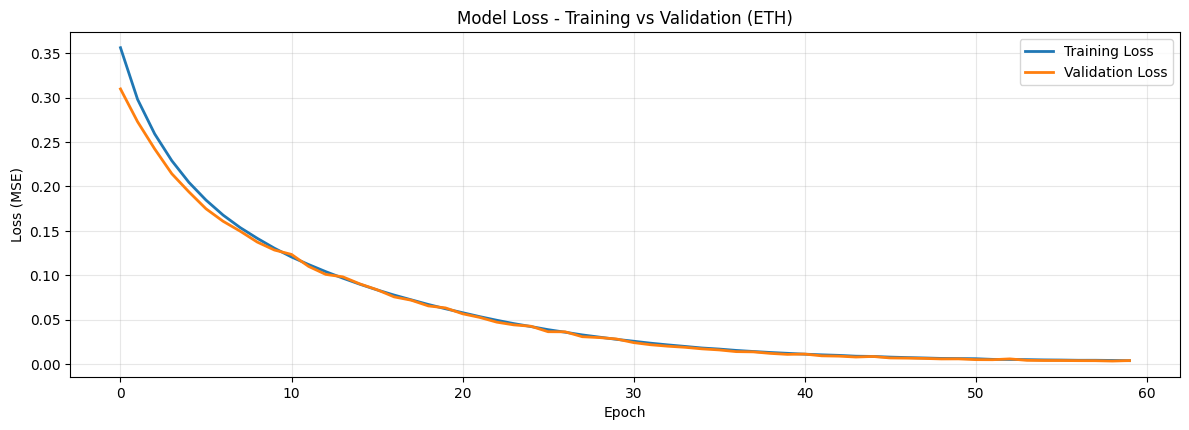

Epoch tốt nhất: 59 với val_loss: 0.003310


In [63]:
# Cell: Vẽ val_loss để đánh giá overfitting cho ETH
import matplotlib.pyplot as plt
import numpy as np

# Trực quan hóa lịch sử huấn luyện để đánh giá overfitting
plt.figure(figsize=(12, 8))

# Subplot 1: Loss
plt.subplot(2, 1, 1)
plt.plot(history_eth.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_eth.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss - Training vs Validation (ETH)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất
best_epoch = np.argmin(history_eth.history['val_loss']) + 1
best_val_loss = min(history_eth.history['val_loss'])
print(f"Epoch tốt nhất: {best_epoch} với val_loss: {best_val_loss:.6f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


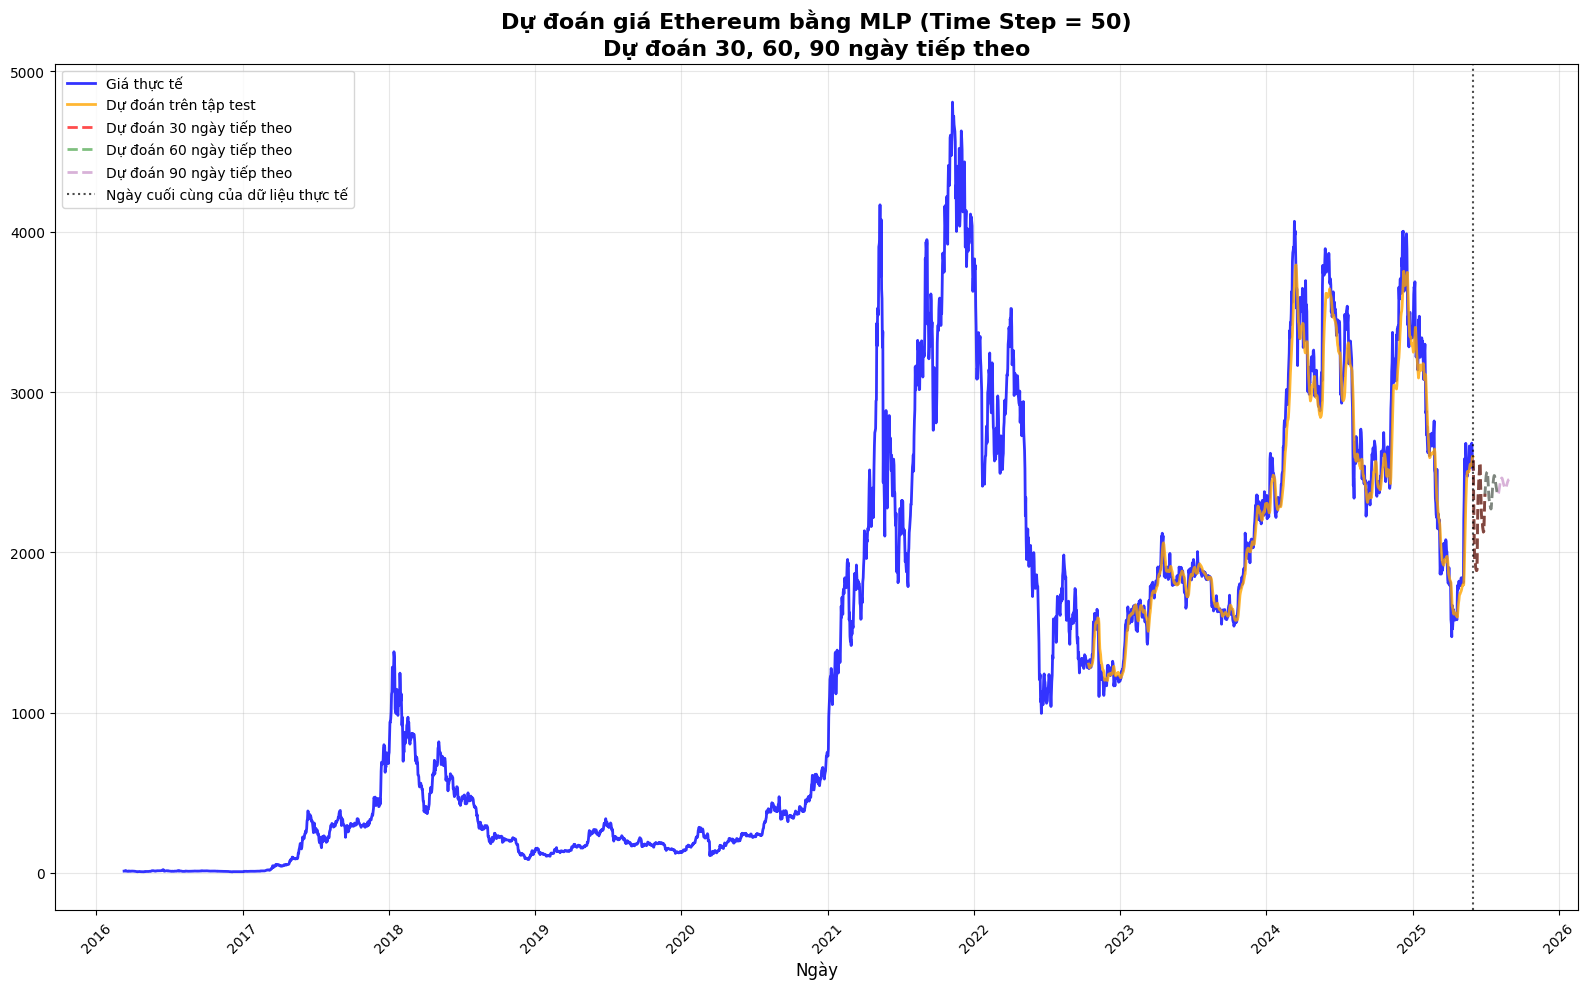

In [64]:
# Dự đoán 30, 60, 90 ngày tiếp theo
last_data_scaled = scaled_test_input[-time_step:]

# Sử dụng model_eth đã huấn luyện và scaler_target_eth
forecasted_prices_30 = forecast_multivariate_prices(model_eth, last_data_scaled, time_step, 30, scaler_target)
forecasted_prices_60 = forecast_multivariate_prices(model_eth, last_data_scaled, time_step, 60, scaler_target)
forecasted_prices_90 = forecast_multivariate_prices(model_eth, last_data_scaled, time_step, 90, scaler_target)

# Dự đoán giá trên tập test
test_predict_scaled = model_eth.predict(X_test)
test_predict_eth = scaler_target.inverse_transform(test_predict_scaled)

# Tạo DataFrame cho các dự đoán
forecast_dates_30 = pd.date_range(start=ETH.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=ETH.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=ETH.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30 = pd.DataFrame(forecasted_prices_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecasted_prices_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecasted_prices_90, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa kết quả với tất cả các dự đoán
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế ETH
plt.plot(ETH.index, ETH['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test
plt.plot(test_eth.index[time_step:], test_predict_eth,
         label='Dự đoán trên tập test', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'],
         label='Dự đoán 30 ngày tiếp theo', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60.index, forecast_df_60['Price'],
         label='Dự đoán 60 ngày tiếp theo', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90.index, forecast_df_90['Price'],
         label='Dự đoán 90 ngày tiếp theo', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Đường phân cách vùng dữ liệu
plt.axvline(x=ETH.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá Ethereum bằng MLP (Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [65]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Lấy giá trị thực tế của Price trong tập test ETH (bỏ qua time_step đầu tiên)
y_test_actual = test_eth['Price'].values[time_step:]

# Dự đoán giá đã inverse_transform ở bước trước: test_predict_eth
mape = mean_absolute_percentage_error(y_test_actual, test_predict_eth.flatten())
mse = mean_squared_error(y_test_actual, test_predict_eth.flatten())
rmse = np.sqrt(mse)

print(f'Kết quả đánh giá mô hình Multivariate MLP cho Ethereum (Time Step = {time_step}):')
print(f'MAPE: {mape:.2f}%')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Số epochs huấn luyện: {len(history_eth.history["loss"])}')

# Thông tin dự đoán 30 ngày
print(f'\nDự đoán giá Ethereum 30 ngày tiếp theo:')
print(f'Giá cao nhất: {forecasted_prices_30.max():.2f}')
print(f'Giá thấp nhất: {forecasted_prices_30.min():.2f}')
print(f'Giá trung bình: {forecasted_prices_30.mean():.2f}')

Kết quả đánh giá mô hình Multivariate MLP cho Ethereum (Time Step = 50):
MAPE: 0.04%
MSE: 20465.49
RMSE: 143.06
Số epochs huấn luyện: 60

Dự đoán giá Ethereum 30 ngày tiếp theo:
Giá cao nhất: 2573.87
Giá thấp nhất: 1885.65
Giá trung bình: 2212.03


#### *Chọn 90% dữ liệu cho training*

In [66]:
# Cell: Chia dữ liệu train/test cho Ethereum

# Chia tập train, test
train_size = int(len(ETH) * 0.9)
train_eth = ETH.iloc[0:train_size, :]
test_eth = ETH.iloc[train_size:len(ETH), :]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input = scaled_input[0:train_size, :]
scaled_test_input = scaled_input[train_size:, :]
scaled_train_target = scaled_target[0:train_size, :]
scaled_test_target = scaled_target[train_size:, :]

print(f"Kích thước tập train: {len(train_eth)}")
print(f"Kích thước tập test: {len(test_eth)}")

Kích thước tập train: 3033
Kích thước tập test: 337


In [67]:
# Cell: Huấn luyện mô hình cho Ethereum

# Tạo dữ liệu train và test với time_step = 50
time_step = 50
X_train, y_train = create_multivariate_time_series_data(scaled_train_input, scaled_train_target, time_step)
X_test, y_test = create_multivariate_time_series_data(scaled_test_input, scaled_test_target, time_step)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Xây dựng mô hình MLP cho ETH
model_eth = build_mlp_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

# Callbacks tối ưu hóa
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model_eth_optimized.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

# Huấn luyện mô hình
history_eth = model_eth.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

X_train shape: (2983, 50, 3)
y_train shape: (2983,)
X_test shape: (287, 50, 3)
y_test shape: (287,)
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3682 - mae: 0.0939
Epoch 1: val_loss improved from inf to 0.28906, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3663 - mae: 0.0929 - val_loss: 0.2891 - val_mae: 0.0524 - learning_rate: 1.0000e-04
Epoch 2/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2810 - mae: 0.0584
Epoch 2: val_loss improved from 0.28906 to 0.23656, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2809 - mae: 0.0584 - val_loss: 0.2366 - val_mae: 0.0517 - learning_rate: 1.0000e-04
Epoch 3/60
174/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2289 - mae: 0.0462
Epoch 3: val_loss improved from 0.23656 to 0.20385, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2281 - mae: 0.0460 - val_loss: 0.2039 - val_mae: 0.0929 - learning_rate: 1.0000e-04
Epoch 4/60
177/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1905 - mae: 0.0376
Epoch 4: val_loss improved from 0.20385 to 0.17262, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1900 - mae: 0.0376 - val_loss: 0.1726 - val_mae: 0.0831 - learning_rate: 1.0000e-04
Epoch 5/60
177/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1621 - mae: 0.0348
Epoch 5: val_loss improved from 0.17262 to 0.15441, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1617 - mae: 0.0348 - val_loss: 0.1544 - val_mae: 0.1067 - learning_rate: 1.0000e-04
Epoch 6/60
184/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1404 - mae: 0.0337
Epoch 6: val_loss improved from 0.15441 to 0.13495, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1403 - mae: 0.0337 - val_loss: 0.1349 - val_mae: 0.0994 - learning_rate: 1.0000e-04
Epoch 7/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1229 - mae: 0.0301
Epoch 7: val_loss improved from 0.13495 to 0.11451, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1228 - mae: 0.0301 - val_loss: 0.1145 - val_mae: 0.0620 - learning_rate: 1.0000e-04
Epoch 8/60
176/187 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1098 - mae: 0.0326
Epoch 8: val_loss improved from 0.11451 to 0.10397, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1096 - mae: 0.0325 - val_loss: 0.1040 - val_mae: 0.0703 - learning_rate: 1.0000e-04
Epoch 9/60
179/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0982 - mae: 0.0309
Epoch 9: val_loss improved from 0.10397 to 0.09290, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0981 - mae: 0.0309 - val_loss: 0.0929 - val_mae: 0.0608 - learning_rate: 1.0000e-04
Epoch 10/60
178/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0882 - mae: 0.0276
Epoch 10: val_loss improved from 0.09290 to 0.08673, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0881 - mae: 0.0276 - val_loss: 0.0867 - val_mae: 0.0781 - learning_rate: 1.0000e-04
Epoch 11/60
177/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0800 - mae: 0.0277
Epoch 11: val_loss improved from 0.08673 to 0.07626, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0799 - mae: 0.0278 - val_loss: 0.0763 - val_mae: 0.0559 - learning_rate: 1.0000e-04
Epoch 12/60
177/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0723 - mae: 0.0263
Epoch 12: val_loss improved from 0.07626 to 0.07015, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0722 - mae: 0.0263 - val_loss: 0.0702 - val_mae: 0.0622 - learning_rate: 1.0000e-04
Epoch 13/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0656 - mae: 0.0259
Epoch 13: val_loss improved from 0.07015 to 0.06252, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0656 - mae: 0.0259 - val_loss: 0.0625 - val_mae: 0.0489 - learning_rate: 1.0000e-04
Epoch 14/60
182/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0601 - mae: 0.0272
Epoch 14: val_loss improved from 0.06252 to 0.05691, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0600 - mae: 0.0272 - val_loss: 0.0569 - val_mae: 0.0482 - learning_rate: 1.0000e-04
Epoch 15/60
183/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0541 - mae: 0.0250
Epoch 15: val_loss improved from 0.05691 to 0.05033, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0541 - mae: 0.0250 - val_loss: 0.0503 - val_mae: 0.0332 - learning_rate: 1.0000e-04
Epoch 16/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0496 - mae: 0.0269
Epoch 16: val_loss improved from 0.05033 to 0.04611, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0495 - mae: 0.0269 - val_loss: 0.0461 - val_mae: 0.0373 - learning_rate: 1.0000e-04
Epoch 17/60
176/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0447 - mae: 0.0250
Epoch 17: val_loss improved from 0.04611 to 0.04288, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0446 - mae: 0.0250 - val_loss: 0.0429 - val_mae: 0.0484 - learning_rate: 1.0000e-04
Epoch 18/60
177/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0406 - mae: 0.0258
Epoch 18: val_loss improved from 0.04288 to 0.03764, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0406 - mae: 0.0257 - val_loss: 0.0376 - val_mae: 0.0338 - learning_rate: 1.0000e-04
Epoch 19/60
178/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0367 - mae: 0.0250
Epoch 19: val_loss improved from 0.03764 to 0.03447, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0367 - mae: 0.0250 - val_loss: 0.0345 - val_mae: 0.0381 - learning_rate: 1.0000e-04
Epoch 20/60
177/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0334 - mae: 0.0253
Epoch 20: val_loss improved from 0.03447 to 0.03358, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0333 - mae: 0.0253 - val_loss: 0.0336 - val_mae: 0.0596 - learning_rate: 1.0000e-04
Epoch 21/60
184/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0303 - mae: 0.0271
Epoch 21: val_loss improved from 0.03358 to 0.02816, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0303 - mae: 0.0271 - val_loss: 0.0282 - val_mae: 0.0364 - learning_rate: 1.0000e-04
Epoch 22/60
182/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0272 - mae: 0.0254
Epoch 22: val_loss improved from 0.02816 to 0.02449, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0272 - mae: 0.0254 - val_loss: 0.0245 - val_mae: 0.0239 - learning_rate: 1.0000e-04
Epoch 23/60
171/187 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0248 - mae: 0.0261
Epoch 23: val_loss improved from 0.02449 to 0.02243, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0247 - mae: 0.0260 - val_loss: 0.0224 - val_mae: 0.0288 - learning_rate: 1.0000e-04
Epoch 24/60
181/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0222 - mae: 0.0251
Epoch 24: val_loss improved from 0.02243 to 0.02040, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0222 - mae: 0.0251 - val_loss: 0.0204 - val_mae: 0.0300 - learning_rate: 1.0000e-04
Epoch 25/60
172/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0202 - mae: 0.0260
Epoch 25: val_loss did not improve from 0.02040
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0201 - mae: 0.0259 - val_loss: 0.0206 - val_mae: 0.0523 - learning_rate: 1.0000e-04
Epoch 26/60
180/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0183 - mae: 0.0254
Epoch 26: val_loss improved from 0.02040 to 0.01794, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0183 - mae: 0.0254 - val_loss: 0.0179 - val_mae: 0.0433 - learning_rate: 1.0000e-04
Epoch 27/60
172/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0164 - mae: 0.0243
Epoch 27: val_loss improved from 0.01794 to 0.01472, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0163 - mae: 0.0243 - val_loss: 0.0147 - val_mae: 0.0248 - learning_rate: 1.0000e-04
Epoch 28/60
182/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 - mae: 0.0262
Epoch 28: val_loss improved from 0.01472 to 0.01335, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0152 - mae: 0.0261 - val_loss: 0.0134 - val_mae: 0.0252 - learning_rate: 1.0000e-04
Epoch 29/60
181/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135 - mae: 0.0241
Epoch 29: val_loss improved from 0.01335 to 0.01210, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0135 - mae: 0.0241 - val_loss: 0.0121 - val_mae: 0.0263 - learning_rate: 1.0000e-04
Epoch 30/60
174/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122 - mae: 0.0245
Epoch 30: val_loss improved from 0.01210 to 0.01085, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0122 - mae: 0.0245 - val_loss: 0.0109 - val_mae: 0.0239 - learning_rate: 1.0000e-04
Epoch 31/60
174/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - mae: 0.0243
Epoch 31: val_loss improved from 0.01085 to 0.00994, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0111 - mae: 0.0243 - val_loss: 0.0099 - val_mae: 0.0252 - learning_rate: 1.0000e-04
Epoch 32/60
181/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0104 - mae: 0.0250
Epoch 32: val_loss improved from 0.00994 to 0.00912, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0104 - mae: 0.0250 - val_loss: 0.0091 - val_mae: 0.0259 - learning_rate: 1.0000e-04
Epoch 33/60
177/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - mae: 0.0252
Epoch 33: val_loss improved from 0.00912 to 0.00825, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0095 - mae: 0.0251 - val_loss: 0.0082 - val_mae: 0.0241 - learning_rate: 1.0000e-04
Epoch 34/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - mae: 0.0241
Epoch 34: val_loss did not improve from 0.00825
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0087 - mae: 0.0241 - val_loss: 0.0092 - val_mae: 0.0432 - learning_rate: 1.0000e-04
Epoch 35/60
174/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - mae: 0.0263
Epoch 35: val_loss improved from 0.00825 to 0.00760, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0082 - mae: 0.0263 - val_loss: 0.0076 - val_mae: 0.0330 - learning_rate: 1.0000e-04
Epoch 36/60
172/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - mae: 0.0264
Epoch 36: val_loss improved from 0.00760 to 0.00647, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0077 - mae: 0.0262 - val_loss: 0.0065 - val_mae: 0.0238 - learning_rate: 1.0000e-04
Epoch 37/60
183/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - mae: 0.0239
Epoch 37: val_loss improved from 0.00647 to 0.00598, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0068 - mae: 0.0239 - val_loss: 0.0060 - val_mae: 0.0234 - learning_rate: 1.0000e-04
Epoch 38/60
174/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - mae: 0.0265
Epoch 38: val_loss improved from 0.00598 to 0.00569, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0068 - mae: 0.0264 - val_loss: 0.0057 - val_mae: 0.0258 - learning_rate: 1.0000e-04
Epoch 39/60
182/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - mae: 0.0241
Epoch 39: val_loss did not improve from 0.00569
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0061 - mae: 0.0241 - val_loss: 0.0076 - val_mae: 0.0495 - learning_rate: 1.0000e-04
Epoch 40/60
183/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 - mae: 0.0247
Epoch 40: val_loss improved from 0.00569 to 0.00505, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0057 - mae: 0.0247 - val_loss: 0.0050 - val_mae: 0.0251 - learning_rate: 1.0000e-04
Epoch 41/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - mae: 0.0246
Epoch 41: val_loss improved from 0.00505 to 0.00469, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0055 - mae: 0.0246 - val_loss: 0.0047 - val_mae: 0.0241 - learning_rate: 1.0000e-04
Epoch 42/60
174/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - mae: 0.0250
Epoch 42: val_loss improved from 0.00469 to 0.00433, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0052 - mae: 0.0249 - val_loss: 0.0043 - val_mae: 0.0235 - learning_rate: 1.0000e-04
Epoch 43/60
176/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 - mae: 0.0235
Epoch 43: val_loss did not improve from 0.00433
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0047 - mae: 0.0235 - val_loss: 0.0050 - val_mae: 0.0340 - learning_rate: 1.0000e-04
Epoch 44/60
178/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 - mae: 0.0262
Epoch 44: val_loss did not improve from 0.00433
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0047 - mae: 0.0262 - val_loss: 0.0049 - val_mae: 0.0374 - learning_rate: 1.0000e-04
Epoch 45/60
177/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - mae: 0.0260
Epoch 45: val_loss improved from 0.00433 to 0.00415, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0047 - mae: 0.0259 - val_loss: 0.0041 - val_mae: 0.0285 - learning_rate: 1.0000e-04
Epoch 46/60
181/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - mae: 0.0246
Epoch 46: val_loss did not improve from 0.00415
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0042 - mae: 0.0247 - val_loss: 0.0045 - val_mae: 0.0371 - learning_rate: 1.0000e-04
Epoch 47/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - mae: 0.0249
Epoch 47: val_loss improved from 0.00415 to 0.00345, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0040 - mae: 0.0249 - val_loss: 0.0034 - val_mae: 0.0241 - learning_rate: 1.0000e-04
Epoch 48/60
182/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - mae: 0.0248
Epoch 48: val_loss did not improve from 0.00345
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0039 - mae: 0.0248 - val_loss: 0.0039 - val_mae: 0.0330 - learning_rate: 1.0000e-04
Epoch 49/60
177/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - mae: 0.0263
Epoch 49: val_loss improved from 0.00345 to 0.00331, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0041 - mae: 0.0262 - val_loss: 0.0033 - val_mae: 0.0259 - learning_rate: 1.0000e-04
Epoch 50/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - mae: 0.0242
Epoch 50: val_loss improved from 0.00331 to 0.00293, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0036 - mae: 0.0242 - val_loss: 0.0029 - val_mae: 0.0229 - learning_rate: 1.0000e-04
Epoch 51/60
172/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - mae: 0.0239
Epoch 51: val_loss improved from 0.00293 to 0.00285, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0034 - mae: 0.0239 - val_loss: 0.0028 - val_mae: 0.0234 - learning_rate: 1.0000e-04
Epoch 52/60
183/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - mae: 0.0242
Epoch 52: val_loss did not improve from 0.00285
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0033 - mae: 0.0242 - val_loss: 0.0033 - val_mae: 0.0325 - learning_rate: 1.0000e-04
Epoch 53/60
174/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - mae: 0.0252
Epoch 53: val_loss improved from 0.00285 to 0.00281, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0034 - mae: 0.0251 - val_loss: 0.0028 - val_mae: 0.0265 - learning_rate: 1.0000e-04
Epoch 54/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mae: 0.0234
Epoch 54: val_loss improved from 0.00281 to 0.00258, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0031 - mae: 0.0234 - val_loss: 0.0026 - val_mae: 0.0236 - learning_rate: 1.0000e-04
Epoch 55/60
181/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - mae: 0.0236
Epoch 55: val_loss improved from 0.00258 to 0.00250, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030 - mae: 0.0236 - val_loss: 0.0025 - val_mae: 0.0232 - learning_rate: 1.0000e-04
Epoch 56/60
175/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - mae: 0.0256
Epoch 56: val_loss did not improve from 0.00250
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0032 - mae: 0.0255 - val_loss: 0.0026 - val_mae: 0.0276 - learning_rate: 1.0000e-04
Epoch 57/60
175/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - mae: 0.0246
Epoch 57: val_loss improved from 0.00250 to 0.00242, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0029 - mae: 0.0246 - val_loss: 0.0024 - val_mae: 0.0239 - learning_rate: 1.0000e-04
Epoch 58/60
180/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - mae: 0.0244
Epoch 58: val_loss improved from 0.00242 to 0.00229, saving model to best_model_eth_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0028 - mae: 0.0244 - val_loss: 0.0023 - val_mae: 0.0232 - learning_rate: 1.0000e-04
Epoch 59/60
181/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - mae: 0.0242
Epoch 59: val_loss did not improve from 0.00229
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028 - mae: 0.0242 - val_loss: 0.0024 - val_mae: 0.0270 - learning_rate: 1.0000e-04
Epoch 60/60
183/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - mae: 0.0235
Epoch 60: val_loss did not improve from 0.00229
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0027 - mae: 0.0235 - val_loss: 0.0030 - val_mae: 0.0330 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 58.


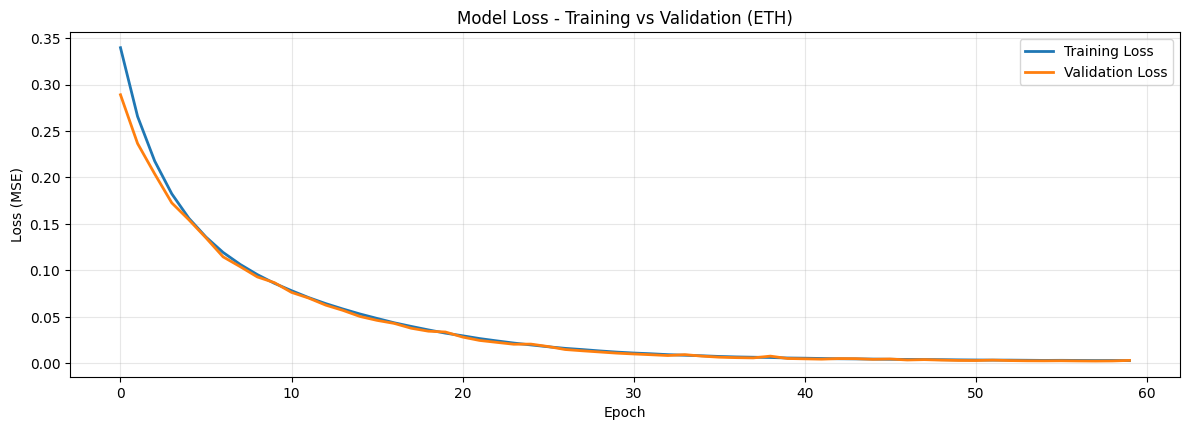

Epoch tốt nhất: 58 với val_loss: 0.002294


In [68]:
# Cell: Vẽ val_loss để đánh giá overfitting cho ETH
import matplotlib.pyplot as plt
import numpy as np

# Trực quan hóa lịch sử huấn luyện để đánh giá overfitting
plt.figure(figsize=(12, 8))

# Subplot 1: Loss
plt.subplot(2, 1, 1)
plt.plot(history_eth.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_eth.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss - Training vs Validation (ETH)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất
best_epoch = np.argmin(history_eth.history['val_loss']) + 1
best_val_loss = min(history_eth.history['val_loss'])
print(f"Epoch tốt nhất: {best_epoch} với val_loss: {best_val_loss:.6f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


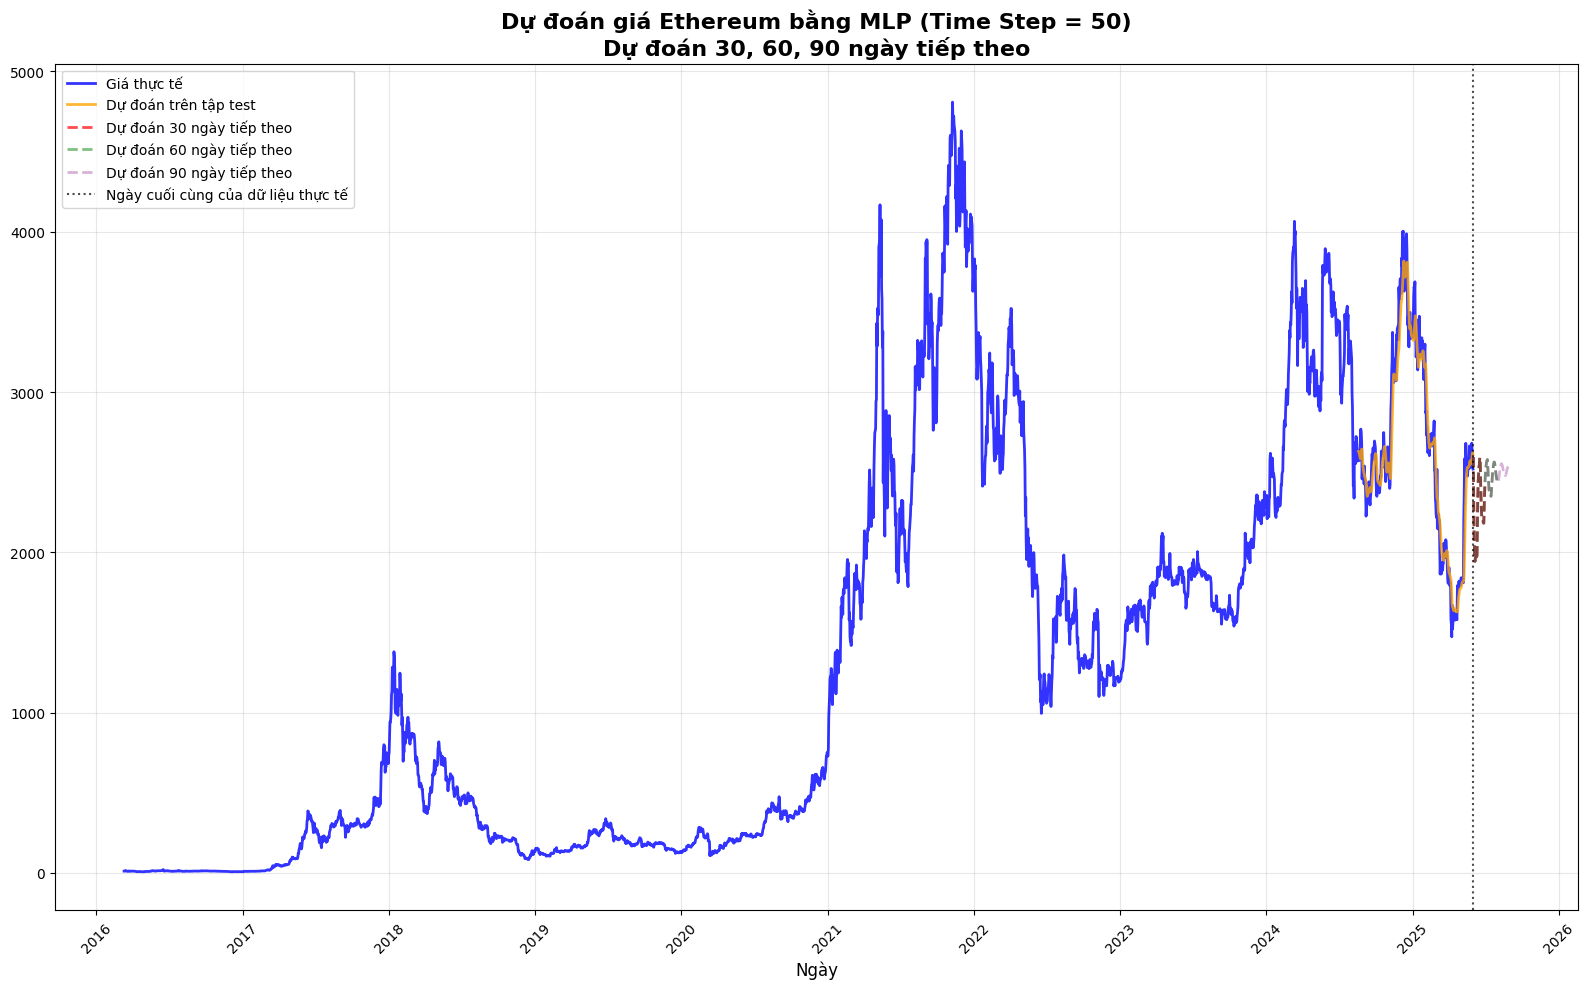

In [69]:
# Dự đoán 30, 60, 90 ngày tiếp theo
last_data_scaled = scaled_test_input[-time_step:]

# Sử dụng model_eth đã huấn luyện và scaler_target_eth
forecasted_prices_30 = forecast_multivariate_prices(model_eth, last_data_scaled, time_step, 30, scaler_target)
forecasted_prices_60 = forecast_multivariate_prices(model_eth, last_data_scaled, time_step, 60, scaler_target)
forecasted_prices_90 = forecast_multivariate_prices(model_eth, last_data_scaled, time_step, 90, scaler_target)

# Dự đoán giá trên tập test
test_predict_scaled = model_eth.predict(X_test)
test_predict_eth = scaler_target.inverse_transform(test_predict_scaled)

# Tạo DataFrame cho các dự đoán
forecast_dates_30 = pd.date_range(start=ETH.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=ETH.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=ETH.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30 = pd.DataFrame(forecasted_prices_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecasted_prices_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecasted_prices_90, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa kết quả với tất cả các dự đoán
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế ETH
plt.plot(ETH.index, ETH['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test
plt.plot(test_eth.index[time_step:], test_predict_eth,
         label='Dự đoán trên tập test', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'],
         label='Dự đoán 30 ngày tiếp theo', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60.index, forecast_df_60['Price'],
         label='Dự đoán 60 ngày tiếp theo', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90.index, forecast_df_90['Price'],
         label='Dự đoán 90 ngày tiếp theo', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Đường phân cách vùng dữ liệu
plt.axvline(x=ETH.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá Ethereum bằng MLP (Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [70]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Lấy giá trị thực tế của Price trong tập test ETH (bỏ qua time_step đầu tiên)
y_test_actual = test_eth['Price'].values[time_step:]

# Dự đoán giá đã inverse_transform ở bước trước: test_predict_eth
mape = mean_absolute_percentage_error(y_test_actual, test_predict_eth.flatten())
mse = mean_squared_error(y_test_actual, test_predict_eth.flatten())
rmse = np.sqrt(mse)

print(f'Kết quả đánh giá mô hình Multivariate MLP cho Ethereum (Time Step = {time_step}):')
print(f'MAPE: {mape:.2f}%')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Số epochs huấn luyện: {len(history_eth.history["loss"])}')

# Thông tin dự đoán 30 ngày
print(f'\nDự đoán giá Ethereum 30 ngày tiếp theo:')
print(f'Giá cao nhất: {forecasted_prices_30.max():.2f}')
print(f'Giá thấp nhất: {forecasted_prices_30.min():.2f}')
print(f'Giá trung bình: {forecasted_prices_30.mean():.2f}')

Kết quả đánh giá mô hình Multivariate MLP cho Ethereum (Time Step = 50):
MAPE: 0.04%
MSE: 22918.55
RMSE: 151.39
Số epochs huấn luyện: 60

Dự đoán giá Ethereum 30 ngày tiếp theo:
Giá cao nhất: 2594.83
Giá thấp nhất: 1943.43
Giá trung bình: 2259.24


### **XRP**

#### *Tiền xử lý dữ liệu*

In [71]:
# Đọc file XRP
XRP = pd.read_csv('XRP Historical Data.csv')

# Loại bỏ dấu phẩy và chuyển đổi thành float cho các cột Price và Open
for col in ['Price', 'Open']:
    XRP[col] = XRP[col].astype(str).str.replace(',', '', regex=False).astype(float)

# Hàm xử lý cột 'Vol.' chứa hậu tố 'K', 'M', 'B'
def convert_volume(val):
    val = str(val).replace(',', '').strip()
    if 'K' in val:
        return float(val.replace('K', '')) * 1_000
    elif 'M' in val:
        return float(val.replace('M', '')) * 1_000_000
    elif 'B' in val:
        return float(val.replace('B', '')) * 1_000_000_000
    else:
        try:
            return float(val)
        except ValueError:
            return np.nan  # Nếu chuỗi rỗng hoặc không hợp lệ

# Áp dụng xử lý cho cột 'Vol.'
XRP['Vol.'] = XRP['Vol.'].apply(convert_volume)

# Kiểm tra NaN trước xử lý
print(f"Trước khi xử lý, số NaN ở Vol.: {XRP['Vol.'].isna().sum()}")

# Nội suy và điền 0 nếu còn thiếu
XRP['Vol.'] = XRP['Vol.'].interpolate(method='linear')
XRP['Vol.'] = XRP['Vol.'].fillna(0)

# Kiểm tra NaN sau xử lý
print(f"Sau khi xử lý, số NaN ở Vol.: {XRP['Vol.'].isna().sum()}")

# Chuyển cột Date sang datetime và đặt làm index
XRP['Date'] = pd.to_datetime(XRP['Date'])
XRP.set_index('Date', inplace=True)
XRP.sort_index(inplace=True)

# Thông tin dữ liệu
print("Data shape:", XRP.shape)
print("Columns:", XRP.columns.tolist())
print("\nFirst 5 rows:")
print(XRP[['Price', 'Open', 'Vol.']].head())

print(f"Tổng số dữ liệu: {len(XRP)} dòng")

Trước khi xử lý, số NaN ở Vol.: 12
Sau khi xử lý, số NaN ở Vol.: 0
Data shape: (3369, 6)
Columns: ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

First 5 rows:
             Price    Open     Vol.
Date                               
2016-03-10  0.0082  0.0081  59130.0
2016-03-11  0.0092  0.0082  25820.0
2016-03-12  0.0081  0.0092  78230.0
2016-03-13  0.0082  0.0081    620.0
2016-03-14  0.0083  0.0082  19310.0
Tổng số dữ liệu: 3369 dòng


#### *Chuẩn hóa dữ liệu*

In [72]:
from sklearn.preprocessing import MinMaxScaler

# Lấy 3 cột Price, Open, Vol. từ XRP để làm đầu vào và Price làm đầu ra
input_features = XRP[['Price', 'Open', 'Vol.']].values
target_feature = XRP[['Price']].values

# Chuẩn hóa input features
scaler_input = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler_input.fit_transform(input_features)

# Chuẩn hóa target feature
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_feature)

#### *Chọn 80% dữ liệu cho training*

In [73]:
# Chia tập train, test
train_size = int(len(XRP) * 0.8)
train_xrp = XRP.iloc[0:train_size, :]
test_xrp = XRP.iloc[train_size:, :]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input = scaled_input[0:train_size, :]
scaled_test_input = scaled_input[train_size:, :]
scaled_train_target = scaled_target[0:train_size, :]
scaled_test_target = scaled_target[train_size:, :]

print(f"Kích thước tập train: {len(train_xrp)}")
print(f"Kích thước tập test: {len(test_xrp)}")

Kích thước tập train: 2695
Kích thước tập test: 674


In [74]:
# Tạo dữ liệu time series
time_step = 50
X_train, y_train = create_multivariate_time_series_data(scaled_train_input, scaled_train_target, time_step)
X_test, y_test = create_multivariate_time_series_data(scaled_test_input, scaled_test_target, time_step)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Xây dựng mô hình và huấn luyện
model_xrp = build_mlp_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model_xrp_optimized.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

history_xrp = model_xrp.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

X_train shape: (2645, 50, 3)
y_train shape: (2645,)
X_test shape: (624, 50, 3)
y_test shape: (624,)
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3561 - mae: 0.0675
Epoch 1: val_loss improved from inf to 0.30112, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.3549 - mae: 0.0668 - val_loss: 0.3011 - val_mae: 0.0387 - learning_rate: 1.0000e-04
Epoch 2/60
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2892 - mae: 0.0412
Epoch 2: val_loss improved from 0.30112 to 0.25165, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2882 - mae: 0.0410 - val_loss: 0.2516 - val_mae: 0.0551 - learning_rate: 1.0000e-04
Epoch 3/60
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2368 - mae: 0.0314
Epoch 3: val_loss improved from 0.25165 to 0.21309, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2360 - mae: 0.0313 - val_loss: 0.2131 - val_mae: 0.0782 - learning_rate: 1.0000e-04
Epoch 4/60
151/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1946 - mae: 0.0275
Epoch 4: val_loss improved from 0.21309 to 0.16912, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1937 - mae: 0.0274 - val_loss: 0.1691 - val_mae: 0.0424 - learning_rate: 1.0000e-04
Epoch 5/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1586 - mae: 0.0234
Epoch 5: val_loss improved from 0.16912 to 0.14178, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1585 - mae: 0.0234 - val_loss: 0.1418 - val_mae: 0.0568 - learning_rate: 1.0000e-04
Epoch 6/60
152/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1308 - mae: 0.0225
Epoch 6: val_loss improved from 0.14178 to 0.11529, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1303 - mae: 0.0225 - val_loss: 0.1153 - val_mae: 0.0449 - learning_rate: 1.0000e-04
Epoch 7/60
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1069 - mae: 0.0198
Epoch 7: val_loss improved from 0.11529 to 0.09520, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1067 - mae: 0.0197 - val_loss: 0.0952 - val_mae: 0.0412 - learning_rate: 1.0000e-04
Epoch 8/60
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0879 - mae: 0.0200
Epoch 8: val_loss improved from 0.09520 to 0.08028, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0878 - mae: 0.0199 - val_loss: 0.0803 - val_mae: 0.0496 - learning_rate: 1.0000e-04
Epoch 9/60
154/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0723 - mae: 0.0175
Epoch 9: val_loss improved from 0.08028 to 0.06645, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0721 - mae: 0.0175 - val_loss: 0.0664 - val_mae: 0.0478 - learning_rate: 1.0000e-04
Epoch 10/60
152/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0597 - mae: 0.0188
Epoch 10: val_loss improved from 0.06645 to 0.05333, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0595 - mae: 0.0187 - val_loss: 0.0533 - val_mae: 0.0310 - learning_rate: 1.0000e-04
Epoch 11/60
149/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0490 - mae: 0.0171
Epoch 11: val_loss improved from 0.05333 to 0.04453, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0488 - mae: 0.0171 - val_loss: 0.0445 - val_mae: 0.0345 - learning_rate: 1.0000e-04
Epoch 12/60
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0404 - mae: 0.0179
Epoch 12: val_loss improved from 0.04453 to 0.03619, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0403 - mae: 0.0179 - val_loss: 0.0362 - val_mae: 0.0261 - learning_rate: 1.0000e-04
Epoch 13/60
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0330 - mae: 0.0164
Epoch 13: val_loss improved from 0.03619 to 0.02913, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0330 - mae: 0.0165 - val_loss: 0.0291 - val_mae: 0.0196 - learning_rate: 1.0000e-04
Epoch 14/60
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0273 - mae: 0.0174
Epoch 14: val_loss improved from 0.02913 to 0.02586, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0272 - mae: 0.0174 - val_loss: 0.0259 - val_mae: 0.0327 - learning_rate: 1.0000e-04
Epoch 15/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0225 - mae: 0.0180
Epoch 15: val_loss improved from 0.02586 to 0.02040, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0225 - mae: 0.0180 - val_loss: 0.0204 - val_mae: 0.0238 - learning_rate: 1.0000e-04
Epoch 16/60
149/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184 - mae: 0.0154
Epoch 16: val_loss improved from 0.02040 to 0.01665, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0183 - mae: 0.0155 - val_loss: 0.0166 - val_mae: 0.0216 - learning_rate: 1.0000e-04
Epoch 17/60
155/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0151 - mae: 0.0167
Epoch 17: val_loss improved from 0.01665 to 0.01412, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0151 - mae: 0.0167 - val_loss: 0.0141 - val_mae: 0.0239 - learning_rate: 1.0000e-04
Epoch 18/60
151/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124 - mae: 0.0164
Epoch 18: val_loss improved from 0.01412 to 0.01174, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0123 - mae: 0.0164 - val_loss: 0.0117 - val_mae: 0.0229 - learning_rate: 1.0000e-04
Epoch 19/60
155/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 - mae: 0.0160
Epoch 19: val_loss improved from 0.01174 to 0.00987, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0101 - mae: 0.0160 - val_loss: 0.0099 - val_mae: 0.0244 - learning_rate: 1.0000e-04
Epoch 20/60
155/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 - mae: 0.0148
Epoch 20: val_loss improved from 0.00987 to 0.00789, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0082 - mae: 0.0149 - val_loss: 0.0079 - val_mae: 0.0199 - learning_rate: 1.0000e-04
Epoch 21/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - mae: 0.0152
Epoch 21: val_loss improved from 0.00789 to 0.00784, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0067 - mae: 0.0152 - val_loss: 0.0078 - val_mae: 0.0293 - learning_rate: 1.0000e-04
Epoch 22/60
156/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - mae: 0.0154
Epoch 22: val_loss did not improve from 0.00784
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0056 - mae: 0.0154 - val_loss: 0.0079 - val_mae: 0.0352 - learning_rate: 1.0000e-04
Epoch 23/60
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 - mae: 0.0155
Epoch 23: val_loss improved from 0.00784 to 0.00750, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0047 - mae: 0.0155 - val_loss: 0.0075 - val_mae: 0.0385 - learning_rate: 1.0000e-04
Epoch 24/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - mae: 0.0154
Epoch 24: val_loss improved from 0.00750 to 0.00446, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0040 - mae: 0.0154 - val_loss: 0.0045 - val_mae: 0.0219 - learning_rate: 1.0000e-04
Epoch 25/60
163/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - mae: 0.0151
Epoch 25: val_loss did not improve from 0.00446
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033 - mae: 0.0151 - val_loss: 0.0052 - val_mae: 0.0296 - learning_rate: 1.0000e-04
Epoch 26/60
152/166 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029 - mae: 0.0154
Epoch 26: val_loss did not improve from 0.00446
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - mae: 0.0154 - val_loss: 0.0047 - val_mae: 0.0304 - learning_rate: 1.0000e-04
Epoch 27/60
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - mae: 0.0159
Epoch 27: val_loss improved from 0.00446 to 0.00301, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0026 - mae: 0.0158 - val_loss: 0.0030 - val_mae: 0.0230 - learning_rate: 1.0000e-04
Epoch 28/60
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - mae: 0.0154
Epoch 28: val_loss did not improve from 0.00301
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0023 - mae: 0.0154 - val_loss: 0.0030 - val_mae: 0.0236 - learning_rate: 1.0000e-04
Epoch 29/60
153/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - mae: 0.0157
Epoch 29: val_loss improved from 0.00301 to 0.00297, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0021 - mae: 0.0157 - val_loss: 0.0030 - val_mae: 0.0231 - learning_rate: 1.0000e-04
Epoch 30/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - mae: 0.0163
Epoch 30: val_loss did not improve from 0.00297
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0019 - mae: 0.0163 - val_loss: 0.0056 - val_mae: 0.0414 - learning_rate: 1.0000e-04
Epoch 31/60
158/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - mae: 0.0148
Epoch 31: val_loss did not improve from 0.00297
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017 - mae: 0.0148 - val_loss: 0.0049 - val_mae: 0.0375 - learning_rate: 1.0000e-04
Epoch 32/60
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - mae: 0.0159
Epoch 32: val_loss improved from 0.00297 to 0.00288, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017 - mae: 0.0159 - val_loss: 0.0029 - val_mae: 0.0238 - learning_rate: 1.0000e-04
Epoch 33/60
150/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - mae: 0.0164
Epoch 33: val_loss improved from 0.00288 to 0.00247, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - mae: 0.0163 - val_loss: 0.0025 - val_mae: 0.0219 - learning_rate: 1.0000e-04
Epoch 34/60
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - mae: 0.0160
Epoch 34: val_loss did not improve from 0.00247
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - mae: 0.0160 - val_loss: 0.0047 - val_mae: 0.0360 - learning_rate: 1.0000e-04
Epoch 35/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - mae: 0.0152
Epoch 35: val_loss did not improve from 0.00247
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0014 - mae: 0.0152 - val_loss: 0.0046 - val_mae: 0.0379 - learning_rate: 1.0000e-04
Epoch 36/60
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - mae: 0.0152
Epoch 36: val_loss did not improve from 0.00247
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013 - mae: 0.0152 - val_loss: 0.0029 - val_mae: 0.0266 - learning_rate: 1.0000e-04
Epoch 37/60
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - 

166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0012 - mae: 0.0156 - val_loss: 0.0024 - val_mae: 0.0231 - learning_rate: 1.0000e-04
Epoch 41/60
155/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mae: 0.0155
Epoch 41: val_loss did not improve from 0.00242
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - mae: 0.0155 - val_loss: 0.0049 - val_mae: 0.0373 - learning_rate: 1.0000e-04
Epoch 42/60
153/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mae: 0.0158
Epoch 42: val_loss improved from 0.00242 to 0.00236, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - mae: 0.0158 - val_loss: 0.0024 - val_mae: 0.0244 - learning_rate: 1.0000e-04
Epoch 43/60
162/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - mae: 0.0146
Epoch 43: val_loss improved from 0.00236 to 0.00224, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011 - mae: 0.0146 - val_loss: 0.0022 - val_mae: 0.0228 - learning_rate: 1.0000e-04
Epoch 44/60
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - mae: 0.0152
Epoch 44: val_loss did not improve from 0.00224
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - mae: 0.0152 - val_loss: 0.0034 - val_mae: 0.0292 - learning_rate: 1.0000e-04
Epoch 45/60
149/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - mae: 0.0158
Epoch 45: val_loss did not improve from 0.00224
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - mae: 0.0157 - val_loss: 0.0033 - val_mae: 0.0303 - learning_rate: 1.0000e-04
Epoch 46/60
157/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - mae: 0.0154
Epoch 46: val_loss did not improve from 0.00224
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011 - mae: 0.0154 - val_loss: 0.0028 - val_mae: 0.0276 - learning_rate: 1.0000e-04
Epoch 47/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - 

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011 - mae: 0.0142 - val_loss: 0.0018 - val_mae: 0.0240 - learning_rate: 1.0000e-04
Epoch 50/60
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - mae: 0.0160
Epoch 50: val_loss did not improve from 0.00175
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012 - mae: 0.0160 - val_loss: 0.0038 - val_mae: 0.0321 - learning_rate: 1.0000e-04
Epoch 51/60
151/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - mae: 0.0147
Epoch 51: val_loss improved from 0.00175 to 0.00170, saving model to best_model_xrp_optimized.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011 - mae: 0.0147 - val_loss: 0.0017 - val_mae: 0.0224 - learning_rate: 1.0000e-04
Epoch 52/60
155/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mae: 0.0170
Epoch 52: val_loss did not improve from 0.00170
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - mae: 0.0170 - val_loss: 0.0022 - val_mae: 0.0246 - learning_rate: 1.0000e-04
Epoch 53/60
159/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.8134e-04 - mae: 0.0144
Epoch 53: val_loss did not improve from 0.00170
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.8656e-04 - mae: 0.0144 - val_loss: 0.0030 - val_mae: 0.0272 - learning_rate: 1.0000e-04
Epoch 54/60
151/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - mae: 0.0146
Epoch 54: val_loss did not improve from 0.00170
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011 - mae: 0.0147 - val_loss: 0.0035 - val_mae: 0.0303 - learning_rate: 1.0000e-04
Epoch 55/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0

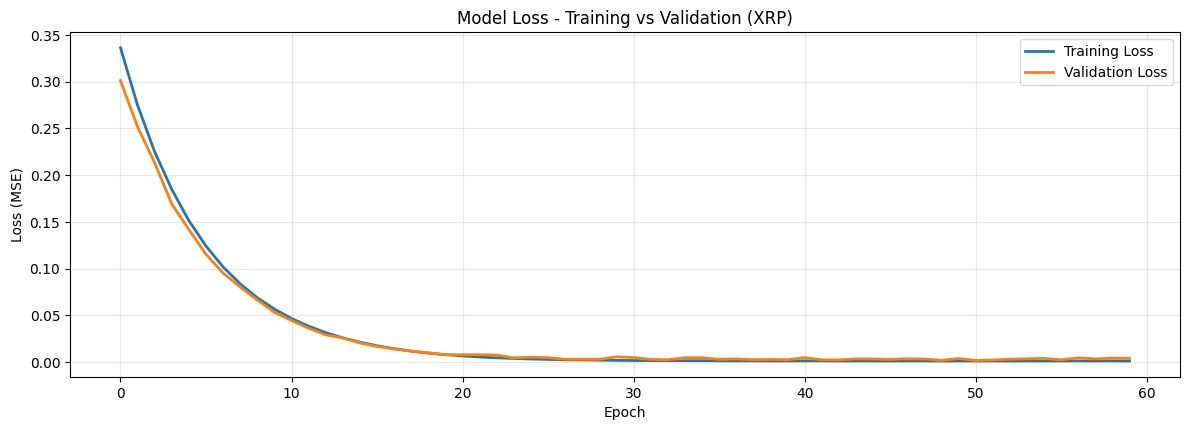

Epoch tốt nhất: 51 với val_loss: 0.001703


In [75]:
# Cell: Vẽ val_loss để đánh giá overfitting cho XRP
import matplotlib.pyplot as plt
import numpy as np

# Trực quan hóa lịch sử huấn luyện để đánh giá overfitting
plt.figure(figsize=(12, 8))

# Subplot 1: Loss
plt.subplot(2, 1, 1)
plt.plot(history_xrp.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_xrp.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss - Training vs Validation (XRP)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất
best_epoch = np.argmin(history_xrp.history['val_loss']) + 1
best_val_loss = min(history_xrp.history['val_loss'])
print(f"Epoch tốt nhất: {best_epoch} với val_loss: {best_val_loss:.6f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


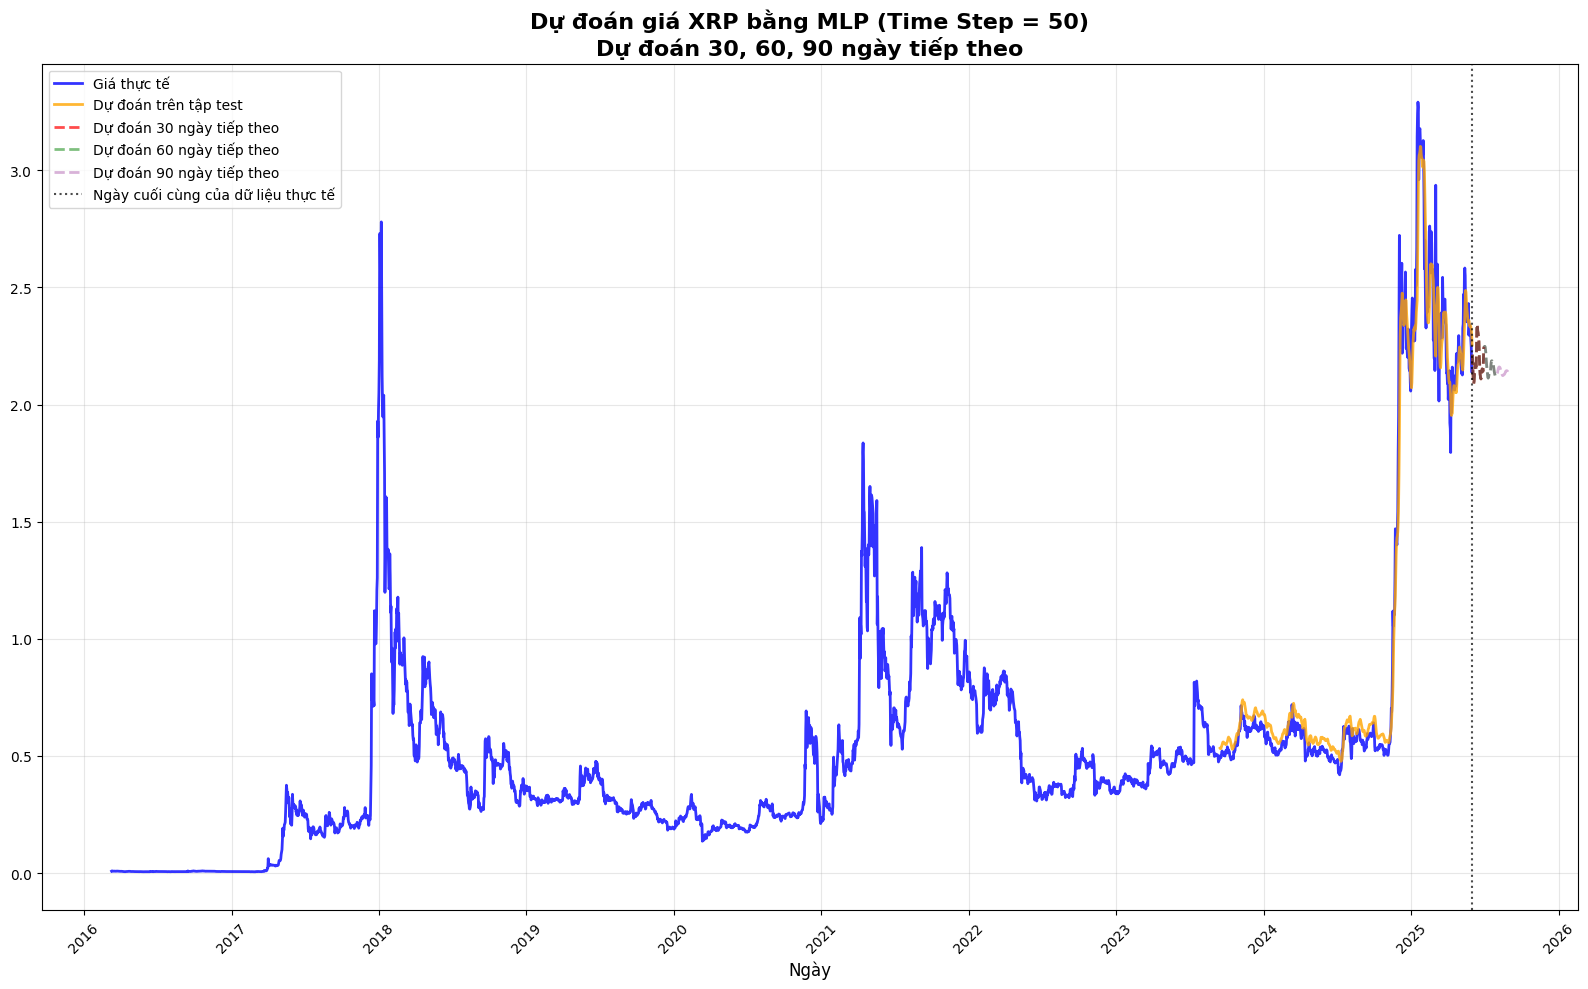

In [76]:
# Dự đoán 30, 60, 90 ngày tiếp theo
# Sử dụng scaled_test_input thay vì scaled_test_xrp_82
last_data_scaled = scaled_test_input[-time_step:]

# Sử dụng hàm forecast_multivariate_prices và model_xrp
# Sử dụng scaler_target cho inverse_transform
forecasted_prices_30 = forecast_multivariate_prices(model_xrp, last_data_scaled, time_step, 30, scaler_target)
forecasted_prices_60 = forecast_multivariate_prices(model_xrp, last_data_scaled, time_step, 60, scaler_target)
forecasted_prices_90 = forecast_multivariate_prices(model_xrp, last_data_scaled, time_step, 90, scaler_target)

# Dự đoán giá trên tập kiểm tra
# Sử dụng X_test và model_xrp
test_predict_scaled = model_xrp.predict(X_test)
# Sử dụng scaler_target cho inverse_transform
test_predict_xrp = scaler_target.inverse_transform(test_predict_scaled)

# Tạo DataFrame cho các dự đoán
forecast_dates_30 = pd.date_range(start=XRP.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=XRP.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=XRP.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30 = pd.DataFrame(forecasted_prices_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecasted_prices_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecasted_prices_90, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa kết quả với tất cả các dự đoán
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế
plt.plot(XRP.index, XRP['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test
# Sử dụng test_xrp
plt.plot(test_xrp.index[time_step:], test_predict_xrp,
         label='Dự đoán trên tập test', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'],
         label='Dự đoán 30 ngày tiếp theo', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60.index, forecast_df_60['Price'],
         label='Dự đoán 60 ngày tiếp theo', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90.index, forecast_df_90['Price'],
         label='Dự đoán 90 ngày tiếp theo', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Thêm đường thẳng đứng để phân biệt vùng dữ liệu
plt.axvline(x=XRP.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá XRP bằng MLP (Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

# Cải thiện hiển thị trục x
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [77]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Lấy giá trị thực tế của Price trong tập test XRP (bỏ qua time_step đầu tiên)
y_test_actual_xrp = test_xrp['Price'].values[time_step:]

# Dự đoán giá đã inverse_transform ở bước trước: test_predict_xrp
mape_xrp = mean_absolute_percentage_error(y_test_actual_xrp, test_predict_xrp.flatten())
mse_xrp = mean_squared_error(y_test_actual_xrp, test_predict_xrp.flatten())
rmse_xrp = np.sqrt(mse_xrp)

print(f'Kết quả đánh giá mô hình Multivariate MLP cho XRP (Time Step = {time_step}):')
print(f'MAPE: {mape_xrp:.2f}%')
print(f'MSE: {mse_xrp:.2f}')
print(f'RMSE: {rmse_xrp:.2f}')
print(f'Số epochs huấn luyện: {len(history_xrp.history["loss"])}')

# Thông tin dự đoán 30 ngày
print(f'\nDự đoán giá XRP 30 ngày tiếp theo:')
print(f'Giá cao nhất: {forecasted_prices_30.max():.2f}')
print(f'Giá thấp nhất: {forecasted_prices_30.min():.2f}')
print(f'Giá trung bình: {forecasted_prices_30.mean():.2f}')

Kết quả đánh giá mô hình Multivariate MLP cho XRP (Time Step = 50):
MAPE: 0.08%
MSE: 0.01
RMSE: 0.11
Số epochs huấn luyện: 60

Dự đoán giá XRP 30 ngày tiếp theo:
Giá cao nhất: 2.34
Giá thấp nhất: 2.09
Giá trung bình: 2.19


#### *Chọn 70% dữ liệu cho training*

In [78]:
# Chia tập train, test
train_size = int(len(XRP) * 0.7)
train_xrp = XRP.iloc[0:train_size, :]
test_xrp = XRP.iloc[train_size:, :]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input = scaled_input[0:train_size, :]
scaled_test_input = scaled_input[train_size:, :]
scaled_train_target = scaled_target[0:train_size, :]
scaled_test_target = scaled_target[train_size:, :]

print(f"Kích thước tập train: {len(train_xrp)}")
print(f"Kích thước tập test: {len(test_xrp)}")

Kích thước tập train: 2358
Kích thước tập test: 1011


In [79]:
# Tạo dữ liệu time series
time_step = 50
X_train, y_train = create_multivariate_time_series_data(scaled_train_input, scaled_train_target, time_step)
X_test, y_test = create_multivariate_time_series_data(scaled_test_input, scaled_test_target, time_step)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Xây dựng mô hình và huấn luyện
model_xrp = build_mlp_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model_xrp_optimized.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

history_xrp = model_xrp.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

X_train shape: (2308, 50, 3)
y_train shape: (2308,)
X_test shape: (961, 50, 3)
y_test shape: (961,)
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3545 - mae: 0.0660
Epoch 1: val_loss improved from inf to 0.30464, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.3528 - mae: 0.0653 - val_loss: 0.3046 - val_mae: 0.0393 - learning_rate: 1.0000e-04
Epoch 2/60
134/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2930 - mae: 0.0427
Epoch 2: val_loss improved from 0.30464 to 0.26157, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2920 - mae: 0.0426 - val_loss: 0.2616 - val_mae: 0.0701 - learning_rate: 1.0000e-04
Epoch 3/60
135/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2440 - mae: 0.0330
Epoch 3: val_loss improved from 0.26157 to 0.21434, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2432 - mae: 0.0330 - val_loss: 0.2143 - val_mae: 0.0412 - learning_rate: 1.0000e-04
Epoch 4/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2032 - mae: 0.0296
Epoch 4: val_loss improved from 0.21434 to 0.18217, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2031 - mae: 0.0295 - val_loss: 0.1822 - val_mae: 0.0548 - learning_rate: 1.0000e-04
Epoch 5/60
137/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1697 - mae: 0.0264
Epoch 5: val_loss improved from 0.18217 to 0.15208, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1692 - mae: 0.0264 - val_loss: 0.1521 - val_mae: 0.0505 - learning_rate: 1.0000e-04
Epoch 6/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1411 - mae: 0.0244
Epoch 6: val_loss improved from 0.15208 to 0.12853, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1409 - mae: 0.0244 - val_loss: 0.1285 - val_mae: 0.0574 - learning_rate: 1.0000e-04
Epoch 7/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1175 - mae: 0.0226
Epoch 7: val_loss improved from 0.12853 to 0.10618, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1175 - mae: 0.0226 - val_loss: 0.1062 - val_mae: 0.0448 - learning_rate: 1.0000e-04
Epoch 8/60
133/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0983 - mae: 0.0216
Epoch 8: val_loss improved from 0.10618 to 0.08860, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0979 - mae: 0.0216 - val_loss: 0.0886 - val_mae: 0.0413 - learning_rate: 1.0000e-04
Epoch 9/60
139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0818 - mae: 0.0207
Epoch 9: val_loss improved from 0.08860 to 0.07266, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0816 - mae: 0.0206 - val_loss: 0.0727 - val_mae: 0.0279 - learning_rate: 1.0000e-04
Epoch 10/60
139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0680 - mae: 0.0193
Epoch 10: val_loss improved from 0.07266 to 0.06105, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0679 - mae: 0.0193 - val_loss: 0.0611 - val_mae: 0.0298 - learning_rate: 1.0000e-04
Epoch 11/60
131/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0567 - mae: 0.0177
Epoch 11: val_loss improved from 0.06105 to 0.05106, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0564 - mae: 0.0178 - val_loss: 0.0511 - val_mae: 0.0264 - learning_rate: 1.0000e-04
Epoch 12/60
138/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0474 - mae: 0.0193
Epoch 12: val_loss improved from 0.05106 to 0.04326, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0473 - mae: 0.0193 - val_loss: 0.0433 - val_mae: 0.0320 - learning_rate: 1.0000e-04
Epoch 13/60
131/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0397 - mae: 0.0184
Epoch 13: val_loss improved from 0.04326 to 0.03566, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0395 - mae: 0.0184 - val_loss: 0.0357 - val_mae: 0.0255 - learning_rate: 1.0000e-04
Epoch 14/60
131/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0329 - mae: 0.0162
Epoch 14: val_loss improved from 0.03566 to 0.02880, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0327 - mae: 0.0163 - val_loss: 0.0288 - val_mae: 0.0184 - learning_rate: 1.0000e-04
Epoch 15/60
131/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0278 - mae: 0.0187
Epoch 15: val_loss improved from 0.02880 to 0.02560, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0276 - mae: 0.0186 - val_loss: 0.0256 - val_mae: 0.0275 - learning_rate: 1.0000e-04
Epoch 16/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0233 - mae: 0.0195
Epoch 16: val_loss improved from 0.02560 to 0.02134, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0233 - mae: 0.0195 - val_loss: 0.0213 - val_mae: 0.0228 - learning_rate: 1.0000e-04
Epoch 17/60
137/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0192 - mae: 0.0169
Epoch 17: val_loss improved from 0.02134 to 0.01761, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0192 - mae: 0.0169 - val_loss: 0.0176 - val_mae: 0.0193 - learning_rate: 1.0000e-04
Epoch 18/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0160 - mae: 0.0159
Epoch 18: val_loss improved from 0.01761 to 0.01443, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0160 - mae: 0.0159 - val_loss: 0.0144 - val_mae: 0.0161 - learning_rate: 1.0000e-04
Epoch 19/60
139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135 - mae: 0.0165
Epoch 19: val_loss improved from 0.01443 to 0.01258, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0135 - mae: 0.0165 - val_loss: 0.0126 - val_mae: 0.0187 - learning_rate: 1.0000e-04
Epoch 20/60
134/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 - mae: 0.0158
Epoch 20: val_loss improved from 0.01258 to 0.01035, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0112 - mae: 0.0158 - val_loss: 0.0103 - val_mae: 0.0173 - learning_rate: 1.0000e-04
Epoch 21/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - mae: 0.0150
Epoch 21: val_loss improved from 0.01035 to 0.00950, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0094 - mae: 0.0150 - val_loss: 0.0095 - val_mae: 0.0211 - learning_rate: 1.0000e-04
Epoch 22/60
135/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - mae: 0.0160
Epoch 22: val_loss improved from 0.00950 to 0.00836, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0080 - mae: 0.0159 - val_loss: 0.0084 - val_mae: 0.0259 - learning_rate: 1.0000e-04
Epoch 23/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - mae: 0.0173
Epoch 23: val_loss improved from 0.00836 to 0.00736, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0070 - mae: 0.0173 - val_loss: 0.0074 - val_mae: 0.0227 - learning_rate: 1.0000e-04
Epoch 24/60
137/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - mae: 0.0161
Epoch 24: val_loss improved from 0.00736 to 0.00602, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0059 - mae: 0.0160 - val_loss: 0.0060 - val_mae: 0.0189 - learning_rate: 1.0000e-04
Epoch 25/60
136/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - mae: 0.0169
Epoch 25: val_loss improved from 0.00602 to 0.00566, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0052 - mae: 0.0168 - val_loss: 0.0057 - val_mae: 0.0212 - learning_rate: 1.0000e-04
Epoch 26/60
129/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - mae: 0.0156
Epoch 26: val_loss did not improve from 0.00566
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0043 - mae: 0.0157 - val_loss: 0.0073 - val_mae: 0.0429 - learning_rate: 1.0000e-04
Epoch 27/60
138/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - mae: 0.0157
Epoch 27: val_loss improved from 0.00566 to 0.00385, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0037 - mae: 0.0157 - val_loss: 0.0039 - val_mae: 0.0200 - learning_rate: 1.0000e-04
Epoch 28/60
137/145 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - mae: 0.0154
Epoch 28: val_loss did not improve from 0.00385
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0033 - mae: 0.0154 - val_loss: 0.0054 - val_mae: 0.0316 - learning_rate: 1.0000e-04
Epoch 29/60
143/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - mae: 0.0170
Epoch 29: val_loss did not improve from 0.00385
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031 - mae: 0.0170 - val_loss: 0.0040 - val_mae: 0.0235 - learning_rate: 1.0000e-04
Epoch 30/60
142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - mae: 0.0159
Epoch 30: val_loss improved from 0.00385 to 0.00373, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0028 - mae: 0.0159 - val_loss: 0.0037 - val_mae: 0.0215 - learning_rate: 1.0000e-04
Epoch 31/60
139/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - mae: 0.0150
Epoch 31: val_loss did not improve from 0.00373
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - mae: 0.0150 - val_loss: 0.0042 - val_mae: 0.0281 - learning_rate: 1.0000e-04
Epoch 32/60
136/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - mae: 0.0153
Epoch 32: val_loss improved from 0.00373 to 0.00262, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022 - mae: 0.0153 - val_loss: 0.0026 - val_mae: 0.0209 - learning_rate: 1.0000e-04
Epoch 33/60
140/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - mae: 0.0154
Epoch 33: val_loss improved from 0.00262 to 0.00255, saving model to best_model_xrp_optimized.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020 - mae: 0.0154 - val_loss: 0.0026 - val_mae: 0.0171 - learning_rate: 1.0000e-04
Epoch 34/60
141/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - mae: 0.0147
Epoch 34: val_loss did not improve from 0.00255
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018 - mae: 0.0147 - val_loss: 0.0032 - val_mae: 0.0216 - learning_rate: 1.0000e-04
Epoch 35/60
136/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - mae: 0.0156
Epoch 35: val_loss did not improve from 0.00255
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018 - mae: 0.0156 - val_loss: 0.0031 - val_mae: 0.0226 - learning_rate: 1.0000e-04
Epoch 36/60
130/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - mae: 0.0147
Epoch 36: val_loss did not improve from 0.00255
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017 - mae: 0.0148 - val_loss: 0.0039 - val_mae: 0.0307 - learning_rate: 1.0000e-04
Epoch 37/60
142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - 

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0018 - mae: 0.0163 - val_loss: 0.0022 - val_mae: 0.0175 - learning_rate: 1.0000e-04
Epoch 38/60
126/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - mae: 0.0157
Epoch 38: val_loss did not improve from 0.00220
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - mae: 0.0156 - val_loss: 0.0027 - val_mae: 0.0204 - learning_rate: 1.0000e-04
Epoch 39/60
132/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - mae: 0.0157
Epoch 39: val_loss did not improve from 0.00220
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - mae: 0.0157 - val_loss: 0.0040 - val_mae: 0.0301 - learning_rate: 1.0000e-04
Epoch 40/60
138/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - mae: 0.0157
Epoch 40: val_loss did not improve from 0.00220
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - mae: 0.0157 - val_loss: 0.0046 - val_mae: 0.0364 - learning_rate: 1.0000e-04
Epoch 41/60
140/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - 

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015 - mae: 0.0164 - val_loss: 0.0016 - val_mae: 0.0153 - learning_rate: 1.0000e-04
Epoch 43/60
142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - mae: 0.0147
Epoch 43: val_loss did not improve from 0.00164
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0013 - mae: 0.0147 - val_loss: 0.0018 - val_mae: 0.0180 - learning_rate: 1.0000e-04
Epoch 44/60
136/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - mae: 0.0152
Epoch 44: val_loss did not improve from 0.00164
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - mae: 0.0153 - val_loss: 0.0018 - val_mae: 0.0225 - learning_rate: 1.0000e-04
Epoch 45/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - mae: 0.0149
Epoch 45: val_loss did not improve from 0.00164
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012 - mae: 0.0149 - val_loss: 0.0053 - val_mae: 0.0431 - learning_rate: 1.0000e-04
Epoch 46/60
137/145 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - 

145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0012 - mae: 0.0146 - val_loss: 0.0015 - val_mae: 0.0167 - learning_rate: 1.0000e-04
Epoch 53/60
142/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - mae: 0.0154
Epoch 53: val_loss did not improve from 0.00145
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - mae: 0.0154 - val_loss: 0.0032 - val_mae: 0.0268 - learning_rate: 1.0000e-04
Epoch 54/60
130/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - mae: 0.0150
Epoch 54: val_loss did not improve from 0.00145
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012 - mae: 0.0151 - val_loss: 0.0027 - val_mae: 0.0228 - learning_rate: 1.0000e-04
Epoch 55/60
130/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - mae: 0.0159
Epoch 55: val_loss did not improve from 0.00145
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - mae: 0.0159 - val_loss: 0.0025 - val_mae: 0.0212 - learning_rate: 1.0000e-04
Epoch 56/60
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - 

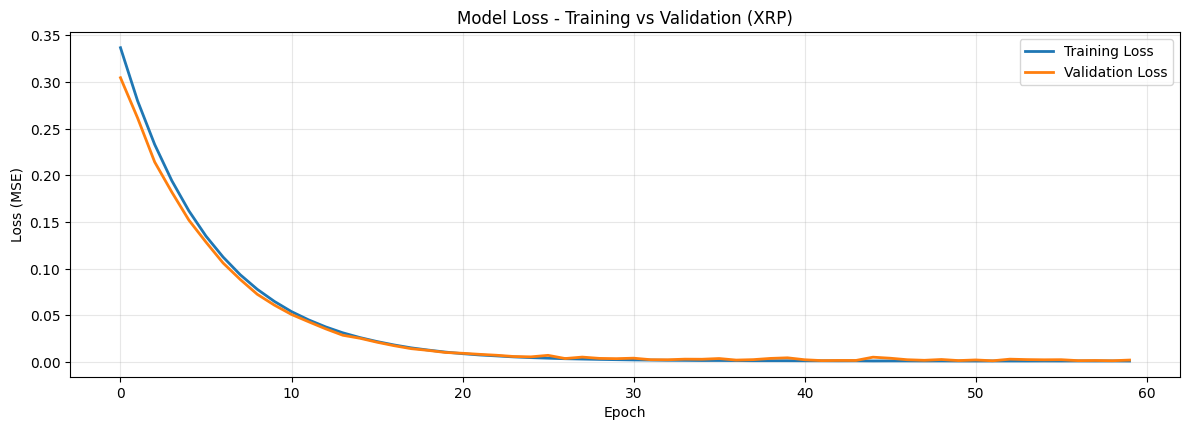

Epoch tốt nhất: 52 với val_loss: 0.001451


In [80]:
# Cell: Vẽ val_loss để đánh giá overfitting cho XRP
import matplotlib.pyplot as plt
import numpy as np

# Trực quan hóa lịch sử huấn luyện để đánh giá overfitting
plt.figure(figsize=(12, 8))

# Subplot 1: Loss
plt.subplot(2, 1, 1)
plt.plot(history_xrp.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_xrp.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss - Training vs Validation (XRP)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất
best_epoch = np.argmin(history_xrp.history['val_loss']) + 1
best_val_loss = min(history_xrp.history['val_loss'])
print(f"Epoch tốt nhất: {best_epoch} với val_loss: {best_val_loss:.6f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


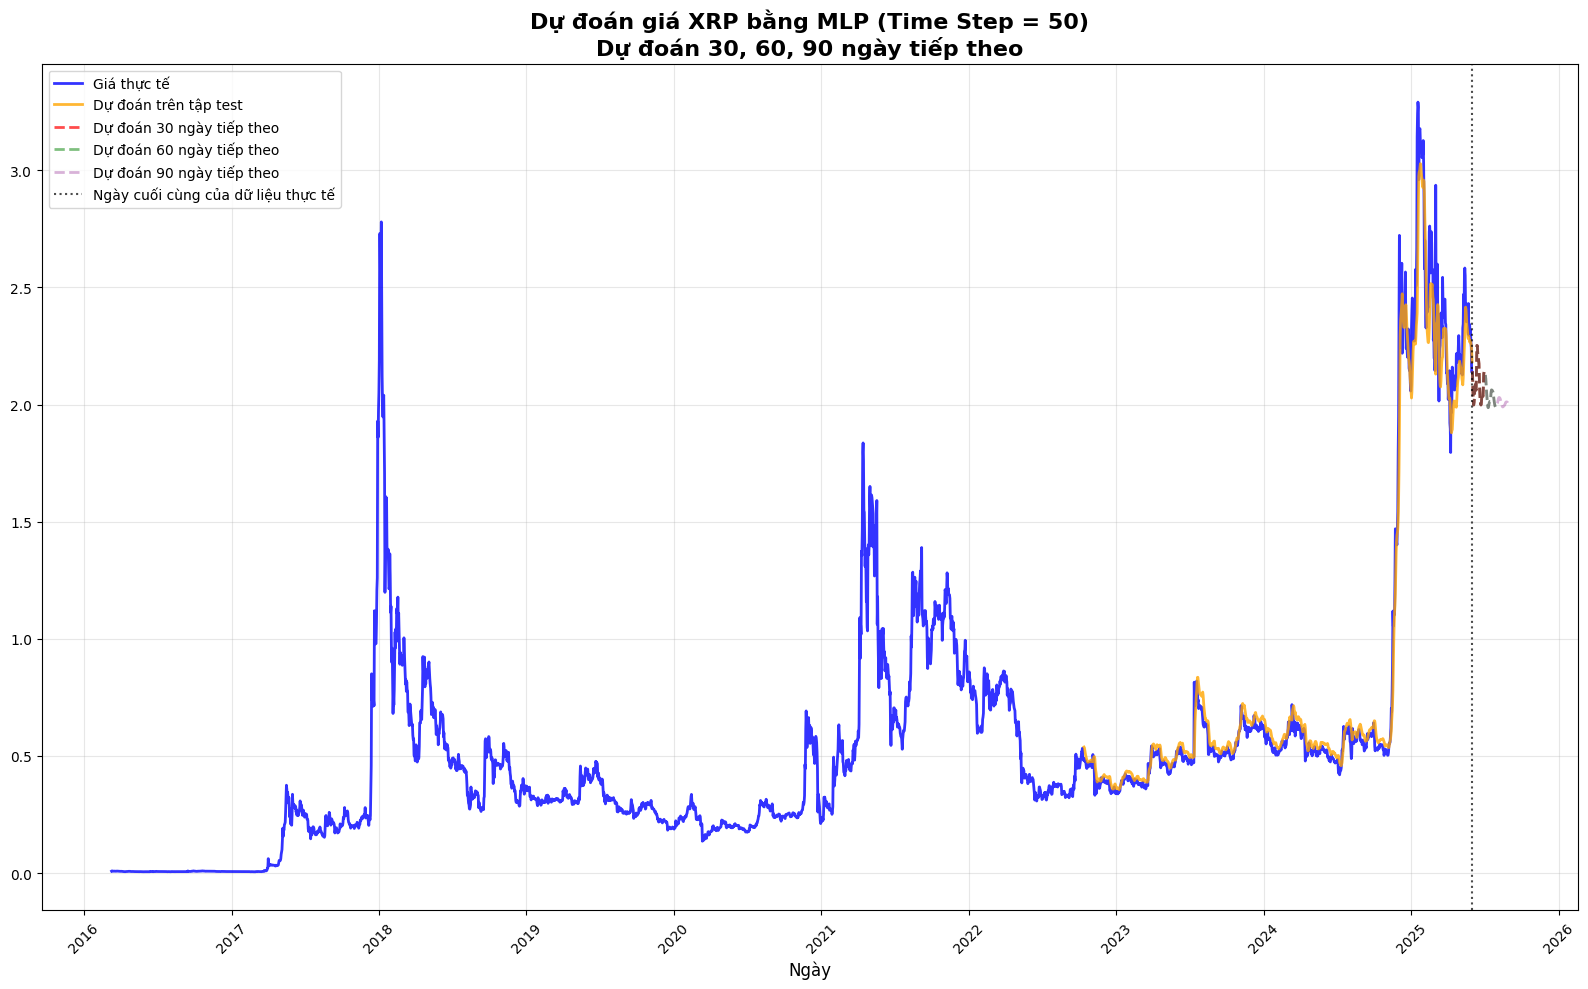

In [81]:
# Dự đoán 30, 60, 90 ngày tiếp theo
# Sử dụng scaled_test_input thay vì scaled_test_xrp_82
last_data_scaled = scaled_test_input[-time_step:]

# Sử dụng hàm forecast_multivariate_prices và model_xrp
# Sử dụng scaler_target cho inverse_transform
forecasted_prices_30 = forecast_multivariate_prices(model_xrp, last_data_scaled, time_step, 30, scaler_target)
forecasted_prices_60 = forecast_multivariate_prices(model_xrp, last_data_scaled, time_step, 60, scaler_target)
forecasted_prices_90 = forecast_multivariate_prices(model_xrp, last_data_scaled, time_step, 90, scaler_target)

# Dự đoán giá trên tập kiểm tra
# Sử dụng X_test và model_xrp
test_predict_scaled = model_xrp.predict(X_test)
# Sử dụng scaler_target cho inverse_transform
test_predict_xrp = scaler_target.inverse_transform(test_predict_scaled)

# Tạo DataFrame cho các dự đoán
forecast_dates_30 = pd.date_range(start=XRP.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=XRP.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=XRP.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30 = pd.DataFrame(forecasted_prices_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecasted_prices_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecasted_prices_90, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa kết quả với tất cả các dự đoán
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế
plt.plot(XRP.index, XRP['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test
# Sử dụng test_xrp
plt.plot(test_xrp.index[time_step:], test_predict_xrp,
         label='Dự đoán trên tập test', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'],
         label='Dự đoán 30 ngày tiếp theo', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60.index, forecast_df_60['Price'],
         label='Dự đoán 60 ngày tiếp theo', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90.index, forecast_df_90['Price'],
         label='Dự đoán 90 ngày tiếp theo', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Thêm đường thẳng đứng để phân biệt vùng dữ liệu
plt.axvline(x=XRP.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá XRP bằng MLP (Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

# Cải thiện hiển thị trục x
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [82]:
# Lấy giá trị thực tế của Price trong tập test XRP (bỏ qua time_step đầu tiên)
y_test_actual_xrp = test_xrp['Price'].values[time_step:]

# Dự đoán giá đã inverse_transform ở bước trước: test_predict_xrp
mape_xrp = mean_absolute_percentage_error(y_test_actual_xrp, test_predict_xrp.flatten())
mse_xrp = mean_squared_error(y_test_actual_xrp, test_predict_xrp.flatten())
rmse_xrp = np.sqrt(mse_xrp)

print(f'Kết quả đánh giá mô hình Multivariate MLP cho XRP (Time Step = {time_step}):')
print(f'MAPE: {mape_xrp:.2f}%')
print(f'MSE: {mse_xrp:.2f}')
print(f'RMSE: {rmse_xrp:.2f}')
print(f'Số epochs huấn luyện: {len(history_xrp.history["loss"])}')

# Thông tin dự đoán 30 ngày
print(f'\nDự đoán giá XRP 30 ngày tiếp theo:')
print(f'Giá cao nhất: {forecasted_prices_30.max():.2f}')
print(f'Giá thấp nhất: {forecasted_prices_30.min():.2f}')
print(f'Giá trung bình: {forecasted_prices_30.mean():.2f}')

Kết quả đánh giá mô hình Multivariate MLP cho XRP (Time Step = 50):
MAPE: 0.06%
MSE: 0.01
RMSE: 0.10
Số epochs huấn luyện: 60

Dự đoán giá XRP 30 ngày tiếp theo:
Giá cao nhất: 2.25
Giá thấp nhất: 2.00
Giá trung bình: 2.09


#### *Chọn 90% dữ liệu cho training*

In [83]:
# Chia tập train, test
train_size = int(len(XRP) * 0.9)
train_xrp = XRP.iloc[0:train_size, :]
test_xrp = XRP.iloc[train_size:, :]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input = scaled_input[0:train_size, :]
scaled_test_input = scaled_input[train_size:, :]
scaled_train_target = scaled_target[0:train_size, :]
scaled_test_target = scaled_target[train_size:, :]

print(f"Kích thước tập train: {len(train_xrp)}")
print(f"Kích thước tập test: {len(test_xrp)}")

Kích thước tập train: 3032
Kích thước tập test: 337


In [84]:
# Tạo dữ liệu time series
time_step = 50
X_train, y_train = create_multivariate_time_series_data(scaled_train_input, scaled_train_target, time_step)
X_test, y_test = create_multivariate_time_series_data(scaled_test_input, scaled_test_target, time_step)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Xây dựng mô hình và huấn luyện
model_xrp = build_mlp_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model_xrp_optimized.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

history_xrp = model_xrp.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

X_train shape: (2982, 50, 3)
y_train shape: (2982,)
X_test shape: (287, 50, 3)
y_test shape: (287,)
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


176/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3573 - mae: 0.0790
Epoch 1: val_loss improved from inf to 0.29996, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3557 - mae: 0.0777 - val_loss: 0.3000 - val_mae: 0.0857 - learning_rate: 1.0000e-04
Epoch 2/60
172/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2769 - mae: 0.0399
Epoch 2: val_loss improved from 0.29996 to 0.24315, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2756 - mae: 0.0396 - val_loss: 0.2431 - val_mae: 0.0980 - learning_rate: 1.0000e-04
Epoch 3/60
182/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2184 - mae: 0.0305
Epoch 3: val_loss improved from 0.24315 to 0.19891, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2180 - mae: 0.0304 - val_loss: 0.1989 - val_mae: 0.1108 - learning_rate: 1.0000e-04
Epoch 4/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1729 - mae: 0.0263
Epoch 4: val_loss improved from 0.19891 to 0.15812, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1727 - mae: 0.0263 - val_loss: 0.1581 - val_mae: 0.0996 - learning_rate: 1.0000e-04
Epoch 5/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1368 - mae: 0.0237
Epoch 5: val_loss improved from 0.15812 to 0.12708, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1367 - mae: 0.0237 - val_loss: 0.1271 - val_mae: 0.0932 - learning_rate: 1.0000e-04
Epoch 6/60
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1085 - mae: 0.0217
Epoch 6: val_loss improved from 0.12708 to 0.10123, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1084 - mae: 0.0216 - val_loss: 0.1012 - val_mae: 0.0834 - learning_rate: 1.0000e-04
Epoch 7/60
181/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0863 - mae: 0.0200
Epoch 7: val_loss improved from 0.10123 to 0.08146, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0861 - mae: 0.0200 - val_loss: 0.0815 - val_mae: 0.0768 - learning_rate: 1.0000e-04
Epoch 8/60
179/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0687 - mae: 0.0189
Epoch 8: val_loss improved from 0.08146 to 0.06922, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0685 - mae: 0.0189 - val_loss: 0.0692 - val_mae: 0.0891 - learning_rate: 1.0000e-04
Epoch 9/60
176/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0547 - mae: 0.0189
Epoch 9: val_loss improved from 0.06922 to 0.05895, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0545 - mae: 0.0189 - val_loss: 0.0589 - val_mae: 0.0946 - learning_rate: 1.0000e-04
Epoch 10/60
184/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0435 - mae: 0.0179
Epoch 10: val_loss improved from 0.05895 to 0.04161, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0435 - mae: 0.0179 - val_loss: 0.0416 - val_mae: 0.0537 - learning_rate: 1.0000e-04
Epoch 11/60
178/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0347 - mae: 0.0176
Epoch 11: val_loss improved from 0.04161 to 0.03652, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0346 - mae: 0.0176 - val_loss: 0.0365 - val_mae: 0.0680 - learning_rate: 1.0000e-04
Epoch 12/60
180/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0276 - mae: 0.0164
Epoch 12: val_loss improved from 0.03652 to 0.03413, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0275 - mae: 0.0165 - val_loss: 0.0341 - val_mae: 0.0855 - learning_rate: 1.0000e-04
Epoch 13/60
178/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0221 - mae: 0.0170
Epoch 13: val_loss improved from 0.03413 to 0.02535, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0220 - mae: 0.0170 - val_loss: 0.0254 - val_mae: 0.0643 - learning_rate: 1.0000e-04
Epoch 14/60
184/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0174 - mae: 0.0158
Epoch 14: val_loss improved from 0.02535 to 0.01873, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0173 - mae: 0.0158 - val_loss: 0.0187 - val_mae: 0.0470 - learning_rate: 1.0000e-04
Epoch 15/60
181/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139 - mae: 0.0163
Epoch 15: val_loss improved from 0.01873 to 0.01513, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0139 - mae: 0.0163 - val_loss: 0.0151 - val_mae: 0.0429 - learning_rate: 1.0000e-04
Epoch 16/60
182/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - mae: 0.0158
Epoch 16: val_loss did not improve from 0.01513
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0111 - mae: 0.0158 - val_loss: 0.0168 - val_mae: 0.0685 - learning_rate: 1.0000e-04
Epoch 17/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - mae: 0.0172
Epoch 17: val_loss improved from 0.01513 to 0.01056, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0089 - mae: 0.0172 - val_loss: 0.0106 - val_mae: 0.0417 - learning_rate: 1.0000e-04
Epoch 18/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - mae: 0.0165
Epoch 18: val_loss did not improve from 0.01056
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0072 - mae: 0.0165 - val_loss: 0.0116 - val_mae: 0.0572 - learning_rate: 1.0000e-04
Epoch 19/60
180/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - mae: 0.0152
Epoch 19: val_loss improved from 0.01056 to 0.00720, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0056 - mae: 0.0152 - val_loss: 0.0072 - val_mae: 0.0356 - learning_rate: 1.0000e-04
Epoch 20/60
181/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046 - mae: 0.0161
Epoch 20: val_loss did not improve from 0.00720
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0046 - mae: 0.0161 - val_loss: 0.0079 - val_mae: 0.0471 - learning_rate: 1.0000e-04
Epoch 21/60
173/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - mae: 0.0158
Epoch 21: val_loss did not improve from 0.00720
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0038 - mae: 0.0159 - val_loss: 0.0086 - val_mae: 0.0547 - learning_rate: 1.0000e-04
Epoch 22/60
175/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - mae: 0.0158
Epoch 22: val_loss improved from 0.00720 to 0.00652, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0032 - mae: 0.0158 - val_loss: 0.0065 - val_mae: 0.0451 - learning_rate: 1.0000e-04
Epoch 23/60
170/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - mae: 0.0158
Epoch 23: val_loss did not improve from 0.00652
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0028 - mae: 0.0158 - val_loss: 0.0072 - val_mae: 0.0520 - learning_rate: 1.0000e-04
Epoch 24/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - mae: 0.0159
Epoch 24: val_loss did not improve from 0.00652
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0024 - mae: 0.0159 - val_loss: 0.0113 - val_mae: 0.0759 - learning_rate: 1.0000e-04
Epoch 25/60
173/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - mae: 0.0153
Epoch 25: val_loss did not improve from 0.00652
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0021 - mae: 0.0153 - val_loss: 0.0095 - val_mae: 0.0685 - learning_rate: 1.0000e-04
Epoch 26/60
178/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - 

187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014 - mae: 0.0158 - val_loss: 0.0062 - val_mae: 0.0530 - learning_rate: 1.0000e-04
Epoch 32/60
185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mae: 0.0158
Epoch 32: val_loss did not improve from 0.00617
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - mae: 0.0158 - val_loss: 0.0103 - val_mae: 0.0760 - learning_rate: 1.0000e-04
Epoch 33/60
184/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - mae: 0.0156
Epoch 33: val_loss did not improve from 0.00617
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - mae: 0.0156 - val_loss: 0.0085 - val_mae: 0.0659 - learning_rate: 1.0000e-04
Epoch 34/60
174/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - mae: 0.0146
Epoch 34: val_loss did not improve from 0.00617
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - mae: 0.0147 - val_loss: 0.0079 - val_mae: 0.0642 - learning_rate: 1.0000e-04
Epoch 35/60
179/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - 

187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - mae: 0.0149 - val_loss: 0.0061 - val_mae: 0.0533 - learning_rate: 1.0000e-04
Epoch 37/60
174/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - mae: 0.0160
Epoch 37: val_loss improved from 0.00612 to 0.00455, saving model to best_model_xrp_optimized.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - mae: 0.0160 - val_loss: 0.0045 - val_mae: 0.0429 - learning_rate: 1.0000e-04
Epoch 38/60
177/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - mae: 0.0145
Epoch 38: val_loss did not improve from 0.00455
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011 - mae: 0.0145 - val_loss: 0.0057 - val_mae: 0.0513 - learning_rate: 1.0000e-04
Epoch 39/60
183/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - mae: 0.0142
Epoch 39: val_loss did not improve from 0.00455
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011 - mae: 0.0142 - val_loss: 0.0060 - val_mae: 0.0535 - learning_rate: 1.0000e-04
Epoch 40/60
183/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - mae: 0.0146
Epoch 40: val_loss did not improve from 0.00455
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - mae: 0.0146 - val_loss: 0.0116 - val_mae: 0.0829 - learning_rate: 1.0000e-04
Epoch 41/60
181/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - 

187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - mae: 0.0151 - val_loss: 0.0035 - val_mae: 0.0366 - learning_rate: 1.0000e-04
Epoch 47/60
184/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - mae: 0.0155
Epoch 47: val_loss did not improve from 0.00354
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011 - mae: 0.0155 - val_loss: 0.0058 - val_mae: 0.0525 - learning_rate: 1.0000e-04
Epoch 48/60
184/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - mae: 0.0167
Epoch 48: val_loss did not improve from 0.00354
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - mae: 0.0167 - val_loss: 0.0121 - val_mae: 0.0842 - learning_rate: 1.0000e-04
Epoch 49/60
177/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - mae: 0.0163
Epoch 49: val_loss did not improve from 0.00354
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - mae: 0.0163 - val_loss: 0.0083 - val_mae: 0.0662 - learning_rate: 1.0000e-04
Epoch 50/60
178/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - 

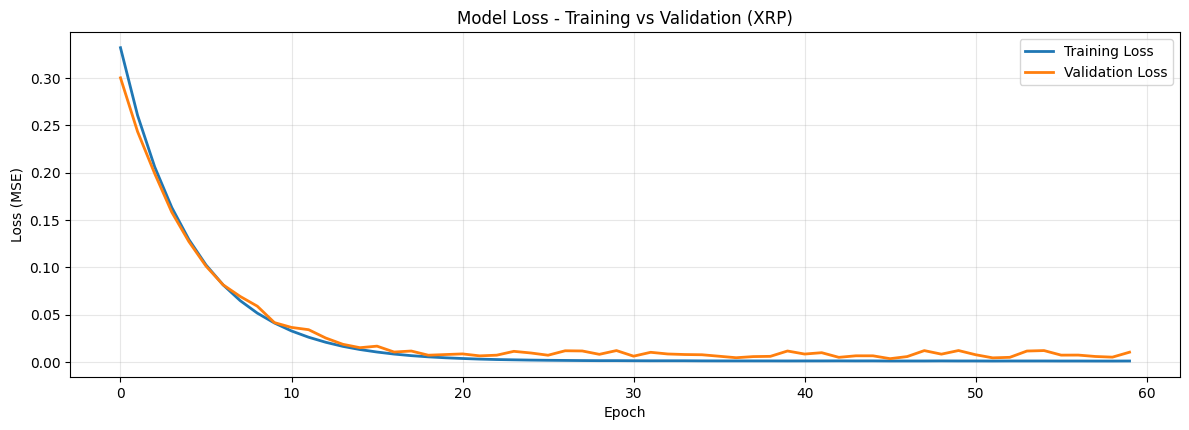

Epoch tốt nhất: 46 với val_loss: 0.003541


In [85]:
# Cell: Vẽ val_loss để đánh giá overfitting cho XRP
# Trực quan hóa lịch sử huấn luyện để đánh giá overfitting
plt.figure(figsize=(12, 8))

# Subplot 1: Loss
plt.subplot(2, 1, 1)
plt.plot(history_xrp.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_xrp.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss - Training vs Validation (XRP)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất
best_epoch = np.argmin(history_xrp.history['val_loss']) + 1
best_val_loss = min(history_xrp.history['val_loss'])
print(f"Epoch tốt nhất: {best_epoch} với val_loss: {best_val_loss:.6f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


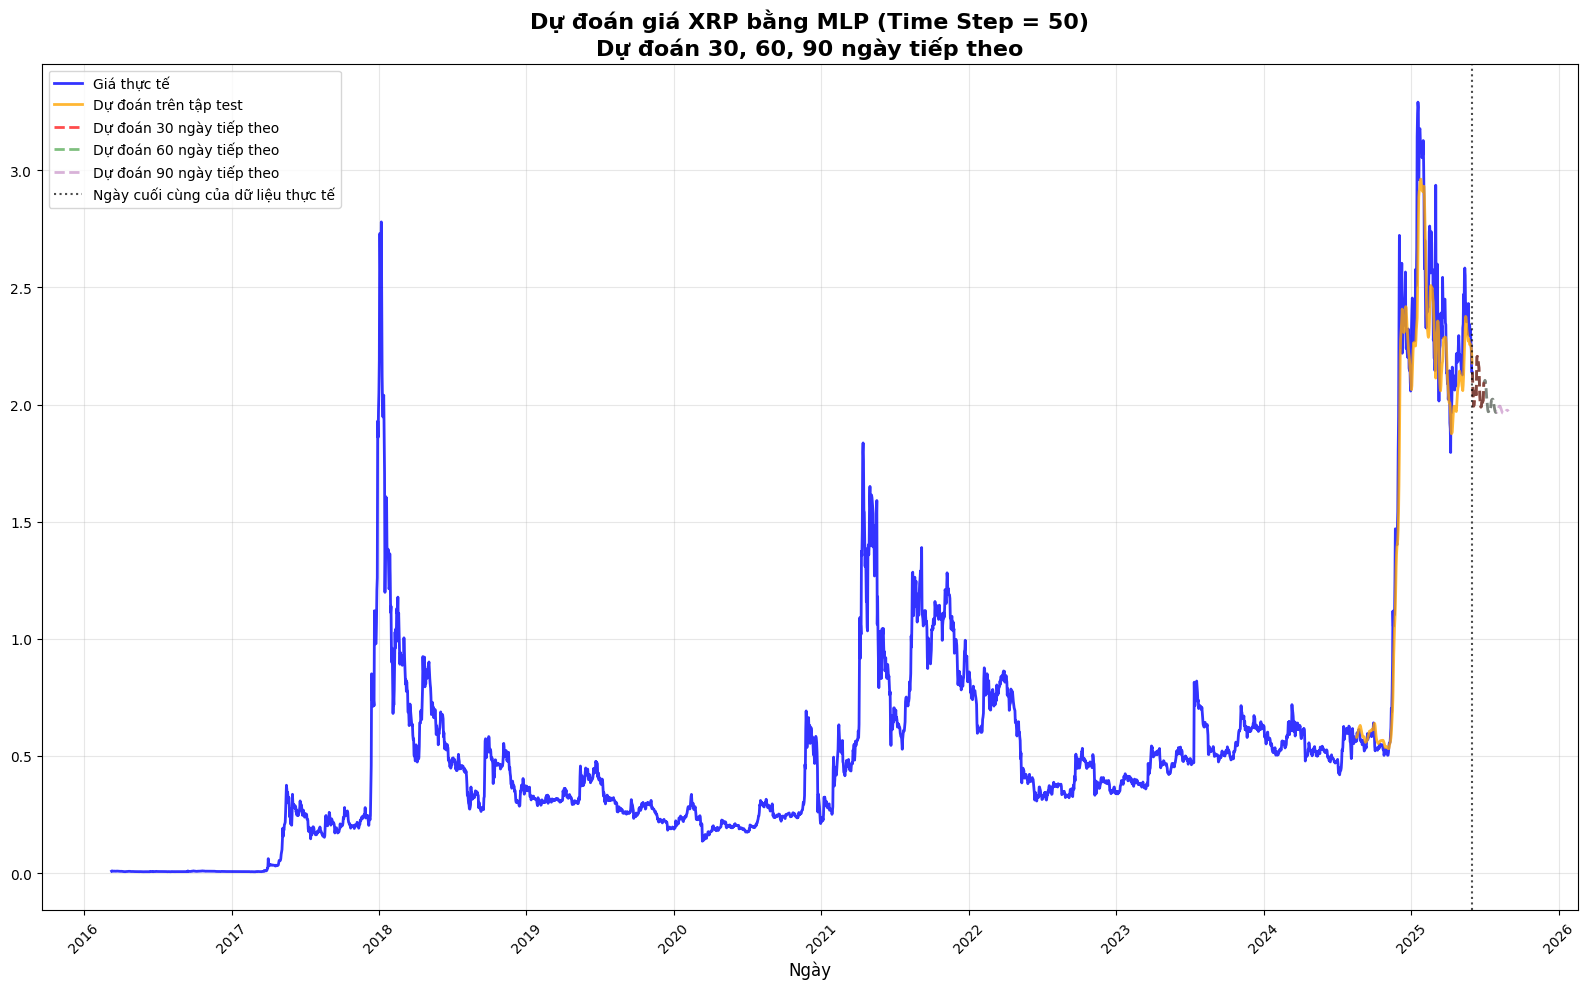

In [86]:
# Dự đoán 30, 60, 90 ngày tiếp theo
# Sử dụng scaled_test_input thay vì scaled_test_xrp_82
last_data_scaled = scaled_test_input[-time_step:]

# Sử dụng hàm forecast_multivariate_prices và model_xrp
# Sử dụng scaler_target cho inverse_transform
forecasted_prices_30 = forecast_multivariate_prices(model_xrp, last_data_scaled, time_step, 30, scaler_target)
forecasted_prices_60 = forecast_multivariate_prices(model_xrp, last_data_scaled, time_step, 60, scaler_target)
forecasted_prices_90 = forecast_multivariate_prices(model_xrp, last_data_scaled, time_step, 90, scaler_target)

# Dự đoán giá trên tập kiểm tra
# Sử dụng X_test và model_xrp
test_predict_scaled = model_xrp.predict(X_test)
# Sử dụng scaler_target cho inverse_transform
test_predict_xrp = scaler_target.inverse_transform(test_predict_scaled)

# Tạo DataFrame cho các dự đoán
forecast_dates_30 = pd.date_range(start=XRP.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=XRP.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=XRP.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30 = pd.DataFrame(forecasted_prices_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecasted_prices_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecasted_prices_90, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa kết quả với tất cả các dự đoán
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế
plt.plot(XRP.index, XRP['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test
# Sử dụng test_xrp
plt.plot(test_xrp.index[time_step:], test_predict_xrp,
         label='Dự đoán trên tập test', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'],
         label='Dự đoán 30 ngày tiếp theo', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60.index, forecast_df_60['Price'],
         label='Dự đoán 60 ngày tiếp theo', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90.index, forecast_df_90['Price'],
         label='Dự đoán 90 ngày tiếp theo', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Thêm đường thẳng đứng để phân biệt vùng dữ liệu
plt.axvline(x=XRP.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá XRP bằng MLP (Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

# Cải thiện hiển thị trục x
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [87]:
# Lấy giá trị thực tế của Price trong tập test XRP (bỏ qua time_step đầu tiên)
y_test_actual_xrp = test_xrp['Price'].values[time_step:]

# Dự đoán giá đã inverse_transform ở bước trước: test_predict_xrp
mape_xrp = mean_absolute_percentage_error(y_test_actual_xrp, test_predict_xrp.flatten())
mse_xrp = mean_squared_error(y_test_actual_xrp, test_predict_xrp.flatten())
rmse_xrp = np.sqrt(mse_xrp)

print(f'Kết quả đánh giá mô hình Multivariate MLP cho XRP (Time Step = {time_step}):')
print(f'MAPE: {mape_xrp:.2f}%')
print(f'MSE: {mse_xrp:.2f}')
print(f'RMSE: {rmse_xrp:.2f}')
print(f'Số epochs huấn luyện: {len(history_xrp.history["loss"])}')

# Thông tin dự đoán 30 ngày
print(f'\nDự đoán giá XRP 30 ngày tiếp theo:')
print(f'Giá cao nhất: {forecasted_prices_30.max():.2f}')
print(f'Giá thấp nhất: {forecasted_prices_30.min():.2f}')
print(f'Giá trung bình: {forecasted_prices_30.mean():.2f}')

Kết quả đánh giá mô hình Multivariate MLP cho XRP (Time Step = 50):
MAPE: 0.06%
MSE: 0.03
RMSE: 0.18
Số epochs huấn luyện: 60

Dự đoán giá XRP 30 ngày tiếp theo:
Giá cao nhất: 2.21
Giá thấp nhất: 1.99
Giá trung bình: 2.07
